In [18]:
# Importing and setup
import pandas as pd
import matplotlib
import sklearn
import numpy as np
%matplotlib inline
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.svm import LinearSVC
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import TruncatedSVD
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import confusion_matrix, accuracy_score, recall_score, precision_score, f1_score, roc_curve, auc
import matplotlib.pyplot as plt
from nltk.stem import WordNetLemmatizer, PorterStemmer
from nltk import pos_tag, word_tokenize, sent_tokenize
import string
import nltk
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/snawshad26/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/snawshad26/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/snawshad26/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

There are 3150 samples, and 8 features.


'\nThe following interpretations can be drawn from the histograms:\n\n1. From (a), the overwhelming majority of articles (>50%) contain between 0 and 5000 characters, some (~30%) contain between 5000 and 10000 characters\n2. From (b), it can be observed that there is an even split among the data between all 9 leaf labels\n3. From (c), it can be observed that there are exactly 350 more articles with sports as the root label than climate as the root label. This makes sense because there are 5 leaf labels under sports and only 4 leaf labels under climate.\n'

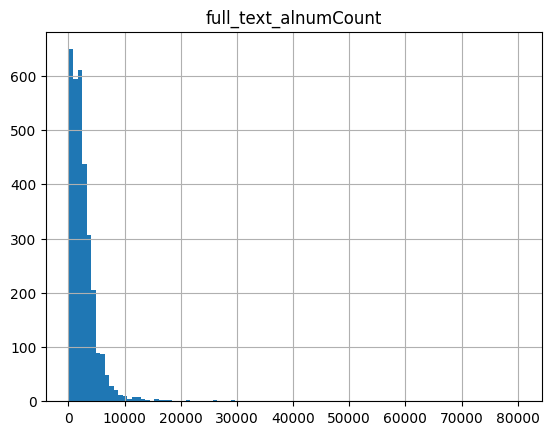

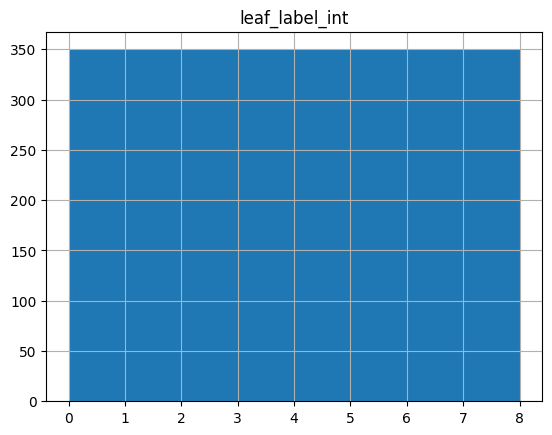

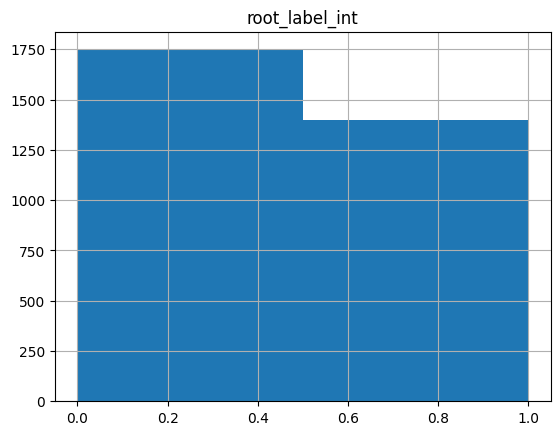

In [2]:
########## Question 1
df = pd.read_csv('Project1-Classification.csv')

########## Overview
print("There are " + str(df.shape[0]) + " samples, and " + str(df.shape[1]) + " features.")

########## Histograms
##### a
# define lambda function to count alpha-numeric characters
count_alpha_numeric = lambda s: sum(c.isalnum() for c in s)

# apply lambda function to each row of full_text
df['full_text_alnumCount'] = df['full_text'].apply(count_alpha_numeric)

# generate histogram
df.hist(column="full_text_alnumCount", bins=100)

##### b
# create a dictionary to map  labels to unique integer values
leaf_label_map = {label: i for i, label in enumerate(df['leaf_label'].unique())}

# create a new column in the DataFrame with the integer values
df['leaf_label_int'] = df['leaf_label'].map(leaf_label_map)

# generate histogram
df.hist(column="leaf_label_int", bins=9)

##### c
# create a dictionary to map  labels to unique integer values
root_label_map = {label: i for i, label in enumerate(df['root_label'].unique())}

# create a new column in the DataFrame with the integer values
df['root_label_int'] = df['root_label'].map(root_label_map)

df.hist(column="root_label_int", bins=2)

########## Interpret Plots
"""
The following interpretations can be drawn from the histograms:

1. From (a), the overwhelming majority of articles (>50%) contain between 0 and 5000 characters, some (~30%) contain between 5000 and 10000 characters
2. From (b), it can be observed that there is an even split among the data between all 9 leaf labels
3. From (c), it can be observed that there are exactly 350 more articles with sports as the root label than climate as the root label. This makes sense because there are 5 leaf labels under sports and only 4 leaf labels under climate.
"""

In [3]:
########## Question 2
import numpy as np
import random
np.random.seed(42)
random.seed(42)
from sklearn.model_selection import train_test_split
train, test = train_test_split(df[["full_text","root_label_int"]], test_size=0.2)


print("There are " + str(train.shape[0]) + " training samples and " + str(test.shape[0]) + " test samples.")

There are 2520 training samples and 630 test samples.


In [4]:
########### Question 3
# Cleaner code:
import re
def clean(text):
    text = re.sub(r'^https?:\/\/.*[\r\n]*', '', text, flags=re.MULTILINE)
    texter = re.sub(r"<br />", " ", text)
    texter = re.sub(r"&quot;", "\"",texter)
    texter = re.sub('&#39;', "\"", texter)
    texter = re.sub('\n', " ", texter)
    texter = re.sub(' u '," you ", texter)
    texter = re.sub('`',"", texter)
    texter = re.sub(' +', ' ', texter)
    texter = re.sub(r"(!)\1+", r"!", texter)
    texter = re.sub(r"(\?)\1+", r"?", texter)
    texter = re.sub('&amp;', 'and', texter)
    texter = re.sub('\r', ' ',texter)
    clean = re.compile('<.*?>')
    texter = texter.encode('ascii', 'ignore').decode('ascii')
    texter = re.sub(clean, '', texter)
    if texter == "":
        texter = ""
    return texter

def penn2morphy(penntag): 
    morphy_tag = {'NN':'n', 'JJ':'a',
                  'VB':'v', 'RB':'r'}
    try:
        return morphy_tag[penntag[:2]]
    except:
        return 'n'

def lemmatized(text):
    lemmatizer = WordNetLemmatizer()

    sent_pos_tags = [pos_tag(word_tokenize(sent)) for sent in sent_tokenize(text)]
    pos_tags = []
    for sentence_tags in sent_pos_tags:
        for tags in sentence_tags:
            pos_tags.append(tags)
    
    lemmatized_words = []
    lemm_text = [lemmatizer.lemmatize(word, pos = penn2morphy(tag)) for word, tag in pos_tags]
    for lemma in lemm_text:
        if (not any(char in lemma for char in string.punctuation)):
            lemmatized_words.append(lemma.lower())
    return ' '.join(lemmatized_words)

def preprocess(text):
  return lemmatized(clean(text))
  

# processing data by using provided cleaner code
train["cleaned"] = train['full_text'].apply(lambda x:preprocess(x))
test["cleaned"] = test['full_text'].apply(lambda x:preprocess(x))

# Using english stopwords of the CountVectorizer and excluding terms that are numbers with the token pattern argument
from sklearn.feature_extraction.text import CountVectorizer
tfidf_transformer = TfidfTransformer(use_idf=True)
pattern = r'\b[A-Za-z]+\b'
vectorizer = CountVectorizer(stop_words='english',token_pattern = pattern, min_df=3)

# Creating vector representations from the CountVectorizer created of the processed training and test data
Xtrain_vec = vectorizer.fit_transform(train['cleaned'])
Xtrain_tf = tfidf_transformer.fit_transform(Xtrain_vec)
Xtrain_array_tf = Xtrain_tf.toarray()
Xtrain = pd.DataFrame(data = Xtrain_array_tf, columns = vectorizer.get_feature_names_out())

Xtest_vec = vectorizer.transform(test['cleaned'])
Xtest_tf = tfidf_transformer.transform(Xtest_vec)
Xtest_array_tf = Xtest_tf.toarray()
Xtest = pd.DataFrame(data = Xtest_array_tf, columns = vectorizer.get_feature_names_out())

ytrain_true = train['root_label_int'].values
ytest_true = test['root_label_int'].values

print('TF-IDF Processed train matrix shape:', Xtrain.shape)
print('TF-IDF Processed test matrix shape:', Xtest.shape)


TF-IDF Processed train matrix shape: (2520, 14084)
TF-IDF Processed test matrix shape: (630, 14084)


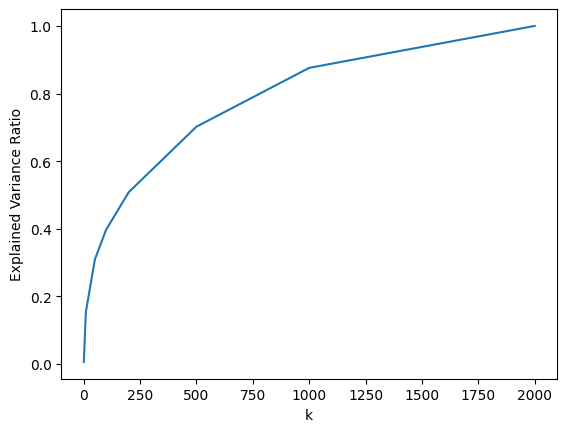

In [5]:
########## Question 4
import matplotlib.pyplot as plt
from sklearn.decomposition import TruncatedSVD, NMF

k = [1, 10, 50, 100, 200, 500, 1000, 2000]
explained_variance_ratio = []

for i in range(len(k)):
    svd_t = TruncatedSVD(n_components=k[i], random_state=42)
    svd_t.fit(Xtrain)
    explained_variance_ratio.append(sum(svd_t.explained_variance_ratio_))

plt.plot(k, explained_variance_ratio)
plt.ylabel("Explained Variance Ratio")
plt.xlabel("k")
plt.show()

In [6]:
k = 50
svd = TruncatedSVD(n_components = k)
#Fit the model on training data and then perform dimensionality reduction
Xtrain_lsi = svd.fit_transform(Xtrain)
Xtest_lsi = svd.transform(Xtest)

print('Dimensionality Reduction: '+str(Xtrain.shape[1])+' features was reduced to '+str(Xtrain_lsi.shape[1]))

Dimensionality Reduction: 14084 features was reduced to 50


In [7]:
u, s, vh = np.linalg.svd(Xtrain)
sd = np.diag(s)
vht = np.transpose(vh)

k = 50
LSI_FN = np.sum(np.square(np.array(Xtrain - u[:,:k] @ sd[0:k,0:k] @ vh[:k,:])))
SIGMA_V = svd.components_
LSI_err = np.sum(np.square(np.array(Xtrain - (Xtrain_lsi @SIGMA_V))))

print("LSI Frobenius Norm:",LSI_FN)

model = NMF(n_components=50, init='random', random_state=42)
W = model.fit_transform(Xtrain)
H = model.components_

NMF_FN = np.sum(np.square(np.array(Xtrain - (W @ H))))
#NMF_MSE = MSE(word_counts_train, (W @ H))
print("NMF Frobenius Norm:",NMF_FN)
#We need value in 4000

if LSI_FN > NMF_FN:
    print('Loss of LSI is larger')
elif LSI_FN < NMF_FN:
    print('Loss of NMF is larger')

LSI Frobenius Norm: 1683.6670208184883


/opt/homebrew/lib/python3.10/site-packages/sklearn/decomposition/_nmf.py:1665: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


NMF Frobenius Norm: 1711.2402419439723
Loss of NMF is larger


/opt/homebrew/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


SVM with gamma=1000 (hard margin):
Confusion matrix:



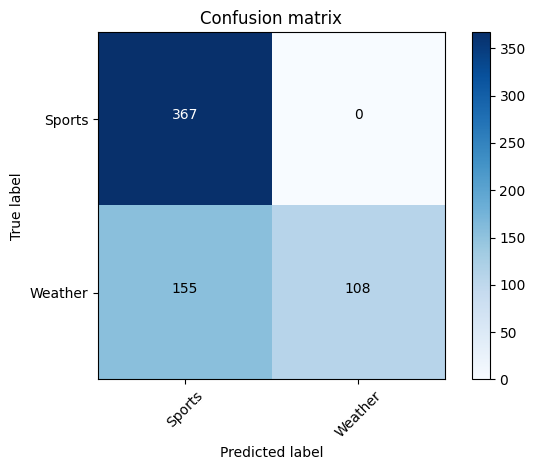

Accuracy: 0.753968253968254
Precision: 0.8515325670498084
Recall: 0.7053231939163498
F1 score: 0.7039285183691661

SVM with gamma=0.0001 (soft margin):
Confusion matrix:



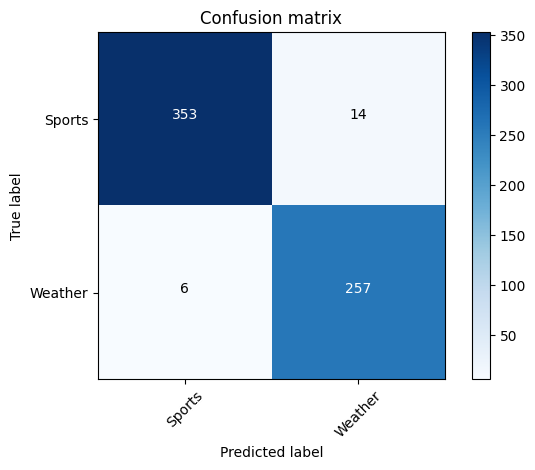

Accuracy: 0.9682539682539683
Precision: 0.9658131957364142
Recall: 0.9695195864112474
F1 score: 0.9674993035565048


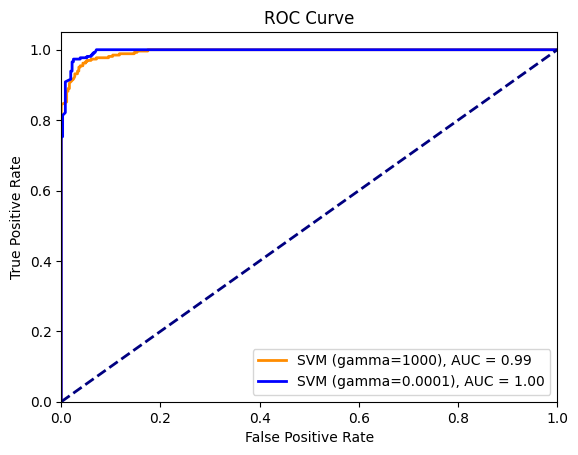

In [8]:
import itertools
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),horizontalalignment="center",color="white" if cm[i, j] > thresh else "black")
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

########## Question 5


# Train linear SVM with gamma=1000 (hard margin)
svm_hard = LinearSVC(C=1/1000, max_iter=10000)
svm_hard.fit(Xtrain, ytrain_true)

# Train linear SVM with gamma=0.0001 (soft margin)
svm_soft = LinearSVC(C=1/0.0001, max_iter=10000)
svm_soft.fit(Xtrain, ytrain_true)

# Predict class labels of test data using the two SVMs
y_pred_hard = svm_hard.predict(Xtest)
y_pred_soft = svm_soft.predict(Xtest)

# Evaluate performance of the two SVMs
print("SVM with gamma=1000 (hard margin):")
print("Confusion matrix:\n")
plt.figure()
plot_confusion_matrix(confusion_matrix(ytest_true, y_pred_hard), classes = ['Sports', 'Weather'])
plt.show()
print("Accuracy:", accuracy_score(ytest_true, y_pred_hard))
print("Precision:", precision_score(ytest_true, y_pred_hard, average='macro'))
print("Recall:", recall_score(ytest_true, y_pred_hard, average='macro'))
print("F1 score:", f1_score(ytest_true, y_pred_hard, average='macro'))

print("\nSVM with gamma=0.0001 (soft margin):")
print("Confusion matrix:\n") 
plt.figure()
plot_confusion_matrix(confusion_matrix(ytest_true, y_pred_soft), classes = ['Sports', 'Weather'])
plt.show()
print("Accuracy:", accuracy_score(ytest_true, y_pred_soft))
print("Precision:", precision_score(ytest_true, y_pred_soft, average='macro'))
print("Recall:", recall_score(ytest_true, y_pred_soft, average='macro'))
print("F1 score:", f1_score(ytest_true, y_pred_soft, average='macro'))

# Plot ROC curve for both SVMs
fpr_hard, tpr_hard, _ = roc_curve(ytest_true, svm_hard.decision_function(Xtest))
fpr_soft, tpr_soft, _ = roc_curve(ytest_true, svm_soft.decision_function(Xtest))
roc_auc_hard = auc(fpr_hard, tpr_hard)
roc_auc_soft = auc(fpr_soft, tpr_soft)

import matplotlib.pyplot as plt
plt.figure()
plt.plot(fpr_hard, tpr_hard, color='darkorange', lw=2, label='SVM (gamma=1000), AUC = %0.2f' % roc_auc_hard)
plt.plot(fpr_soft, tpr_soft, color='blue', lw=2, label='SVM (gamma=0.0001), AUC = %0.2f' % roc_auc_soft)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()


/opt/homebrew/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(


Accuracy score for Logistic Regression without regularization: 0.958730
Recall score for Logistic Regression without regularization: 0.977186
Precision score for Logistic Regression without regularization: 0.927798
F-1 score for Logistic Regression without regularization: 0.951852


/opt/homebrew/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


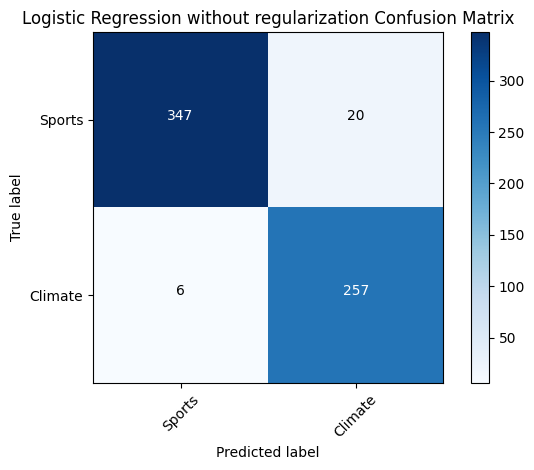

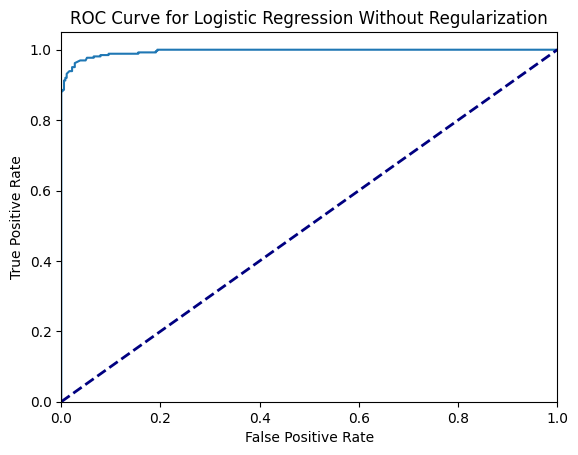

In [9]:
########## Question 6 - Logistic regression no regularization
def Classifier_Metric_printer(y_test,y_pred,name="",average='binary'):
    print("Accuracy score for %s: %f" %(name,accuracy_score(y_test,y_pred)))
    print("Recall score for %s: %f" % (name,recall_score(y_test,y_pred,average=average)))
    print("Precision score for %s: %f" % (name,precision_score(y_test,y_pred,average=average)))
    print("F-1 score for %s: %f" % (name,f1_score(y_test,y_pred,average=average)))

class_names = ["Sports","Climate"]
LR = LogisticRegression(penalty = 'none', random_state = 42)
pred_lr = LR.fit(Xtrain_lsi,ytrain_true).predict(Xtest_lsi)

Classifier_Metric_printer(ytest_true, pred_lr, name="Logistic Regression without regularization")
Logistics_Regression_cm = confusion_matrix(ytest_true,pred_lr)
plt.figure() 
plot_confusion_matrix(Logistics_Regression_cm, classes=class_names, title='Logistic Regression without regularization Confusion Matrix') 

fpr_lr, tpr_lr, _ = roc_curve(ytest_true,LR.decision_function(Xtest_lsi))
plt.figure()
plt.plot(fpr_lr,tpr_lr)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Logistic Regression Without Regularization')
plt.show()

In [10]:
########## Question 6 - Finding the best L1 regularization term
from prettytable import PrettyTable

regularizations = [0.00001, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000, 100000]

acc_l1 = []
mean_coeff_l1 = []
acc_l2 = []
mean_coeff_l2 = []
peak_accuracy_l1 = 0
peak_l1 = 0

table_l1 = PrettyTable()
table_l1.field_names = ["L1 Value", "Accuracy", "Standard Deviation"]
table_l1.title = "L1 Reg Scores"

for l1 in regularizations:
    LR = LogisticRegression(penalty="l1", random_state=42, solver="liblinear", C=l1)
    pred_lr = LR.fit(Xtrain_lsi, ytrain_true).predict(Xtest_lsi)
    scores = cross_val_score(LR, Xtrain_lsi, ytrain_true, cv = 5)
    acc_l1.append(accuracy_score(ytest_true, pred_lr))
    mean_coeff_l1.append(np.mean(LR.coef_))
    if scores.mean() > peak_accuracy_l1:
        peak_accuracy_l1 = scores.mean()
        peak_l1 = l1
    table_l1.add_row([l1, scores.mean(), scores.std()])

print(table_l1)
print("Best l1 is "+str(peak_l1))




+-------------------------------------------------------+
|                     L1 Reg Scores                     |
+----------+--------------------+-----------------------+
| L1 Value |      Accuracy      |   Standard Deviation  |
+----------+--------------------+-----------------------+
|  1e-05   | 0.5488095238095239 | 0.0009720197391996703 |
|  0.0001  | 0.5488095238095239 | 0.0009720197391996703 |
|  0.001   | 0.5488095238095239 | 0.0009720197391996703 |
|   0.01   | 0.5488095238095239 | 0.0009720197391996703 |
|   0.1    | 0.923015873015873  |  0.017808575930410207 |
|    1     | 0.9424603174603174 |  0.01011710220950946  |
|    10    | 0.9519841269841269 |  0.004593586072535839 |
|   100    | 0.9519841269841269 |  0.00580505509457455  |
|   1000   | 0.9511904761904761 |   0.0071648690814555  |
|  10000   | 0.9511904761904761 |   0.0071648690814555  |
|  100000  | 0.9511904761904761 |   0.0071648690814555  |
+----------+--------------------+-----------------------+
Best l1 is 10


In [11]:
########## Question 6 - Finding the best L2 regularization term
peak_l2 = 0
peak_accuracy_l2 = 0
table_l2 = PrettyTable()
table_l2.field_names = ["L2 Value", "Accuracy", "Standard Deviation"]
table_l2.title = "L2 Reg Scores"

for l2 in regularizations:
    LR = LogisticRegression(penalty="l2", random_state=42, solver="liblinear", C=l2)
    pred_lr = LR.fit(Xtrain_lsi, ytrain_true).predict(Xtest_lsi)
    scores = cross_val_score(LR, Xtrain_lsi, ytrain_true, cv = 5)
    acc_l2.append(accuracy_score(ytest_true, pred_lr))
    mean_coeff_l2.append(np.mean(LR.coef_))
    if scores.mean() > peak_accuracy_l2:
        peak_accuracy_l2 = scores.mean()
        peak_l2 = l2
    table_l2.add_row([l2, scores.mean(), scores.std()])

print(table_l2)
print("Best l2 is "+str(peak_l2))


+-------------------------------------------------------+
|                     L2 Reg Scores                     |
+----------+--------------------+-----------------------+
| L2 Value |      Accuracy      |   Standard Deviation  |
+----------+--------------------+-----------------------+
|  1e-05   | 0.5488095238095239 | 0.0009720197391996703 |
|  0.0001  | 0.5488095238095239 | 0.0009720197391996703 |
|  0.001   | 0.5488095238095239 | 0.0009720197391996703 |
|   0.01   | 0.7273809523809524 | 0.0075917168530590965 |
|   0.1    | 0.9226190476190477 |  0.015110660924333148 |
|    1     | 0.9436507936507936 |  0.009928568256505392 |
|    10    | 0.9472222222222223 | 0.0062239631513326165 |
|   100    | 0.9492063492063492 |  0.005112737589970301 |
|   1000   | 0.9515873015873015 |  0.00609614741894337  |
|  10000   | 0.9511904761904761 |   0.0071648690814555  |
|  100000  | 0.9511904761904761 |   0.0071648690814555  |
+----------+--------------------+-----------------------+
Best l2 is 100

Performance with L1 Regularization
Accuracy score for Logistic Regression with L1 regularization: 0.955556
Recall score for Logistic Regression with L1 regularization: 0.969582
Precision score for Logistic Regression with L1 regularization: 0.927273
F-1 score for Logistic Regression with L1 regularization: 0.947955


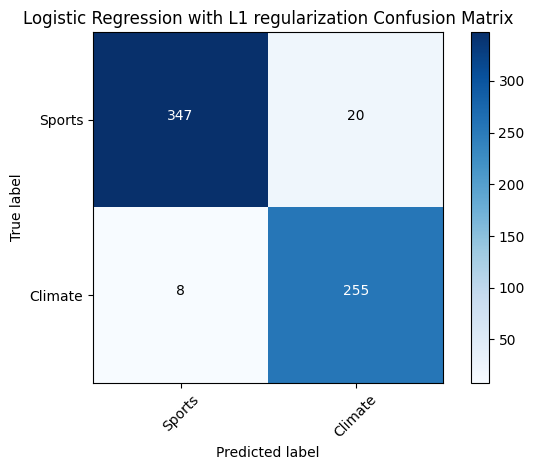

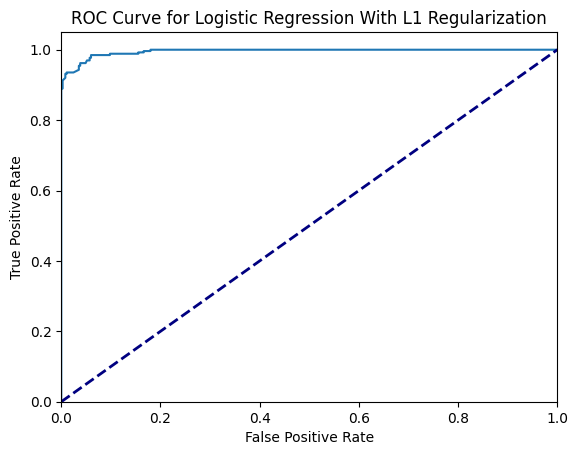

Performance with L2 Regularization
Accuracy score for Logistic Regression with L2 regularization: 0.958730
Recall score for Logistic Regression with L2 regularization: 0.977186
Precision score for Logistic Regression with L2 regularization: 0.927798
F-1 score for Logistic Regression with L2 regularization: 0.951852


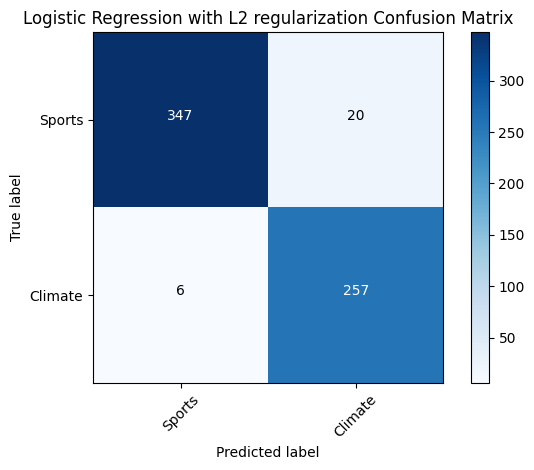

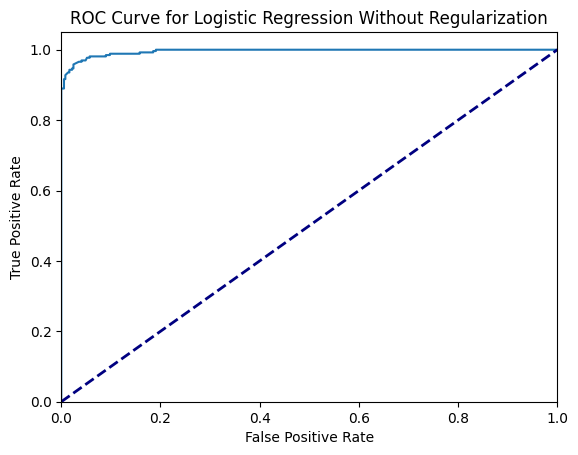

Performance without Regularization


/opt/homebrew/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(


Accuracy score for Logistic Regression with no regularization: 0.958730
Recall score for Logistic Regression with no regularization: 0.977186
Precision score for Logistic Regression with no regularization: 0.927798
F-1 score for Logistic Regression with no regularization: 0.951852


/opt/homebrew/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


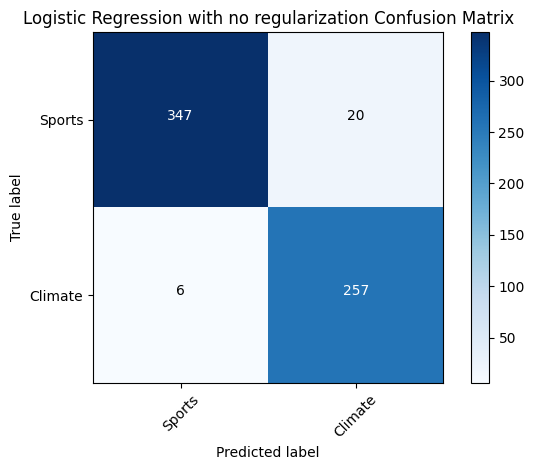

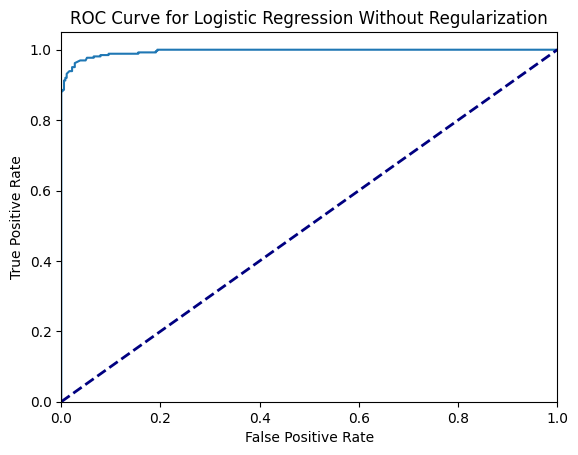

In [12]:
########## Question 6 - Stating Performance for L1, L2, and no regularization
#Performance with L1 Regularization
print("Performance with L1 Regularization")
LR = LogisticRegression(penalty='l1',random_state = 42,solver='liblinear', C=peak_l1)
pred_lr = LR.fit(Xtrain_lsi,ytrain_true).predict(Xtest_lsi)
Classifier_Metric_printer(ytest_true, pred_lr, name="Logistic Regression with L1 regularization")
Logistics_Regression_cm = confusion_matrix(ytest_true, pred_lr) 
plt.figure() 
plot_confusion_matrix(Logistics_Regression_cm, classes=class_names, title='Logistic Regression with L1 regularization Confusion Matrix') 
fpr_lr, tpr_lr, _ = roc_curve(ytest_true,LR.decision_function(Xtest_lsi))
plt.figure()
plt.plot(fpr_lr,tpr_lr)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Logistic Regression With L1 Regularization')
plt.show()

#Performance with L2 Regularization
print("Performance with L2 Regularization")
LR = LogisticRegression(penalty='l2',random_state = 42,solver='liblinear', C=peak_l2)
pred_lr = LR.fit(Xtrain_lsi,ytrain_true).predict(Xtest_lsi)
Classifier_Metric_printer(ytest_true, pred_lr, name="Logistic Regression with L2 regularization")
Logistics_Regression_cm = confusion_matrix(ytest_true, pred_lr) 
plt.figure() 
plot_confusion_matrix(Logistics_Regression_cm, classes=class_names, title='Logistic Regression with L2 regularization Confusion Matrix') 
fpr_lr, tpr_lr, _ = roc_curve(ytest_true,LR.decision_function(Xtest_lsi))
plt.figure()
plt.plot(fpr_lr,tpr_lr)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Logistic Regression Without Regularization')
plt.show()

#Performance with no Regularization
print("Performance without Regularization")
LR = LogisticRegression(penalty='none',random_state = 42)
pred_lr = LR.fit(Xtrain_lsi,ytrain_true).predict(Xtest_lsi)
Classifier_Metric_printer(ytest_true, pred_lr, name="Logistic Regression with no regularization")
Logistics_Regression_cm = confusion_matrix(ytest_true, pred_lr) 
plt.figure() 
plot_confusion_matrix(Logistics_Regression_cm, classes=class_names, title='Logistic Regression with no regularization Confusion Matrix') 
fpr_lr, tpr_lr, _ = roc_curve(ytest_true,LR.decision_function(Xtest_lsi))
plt.figure()
plt.plot(fpr_lr,tpr_lr)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Logistic Regression Without Regularization')
plt.show()


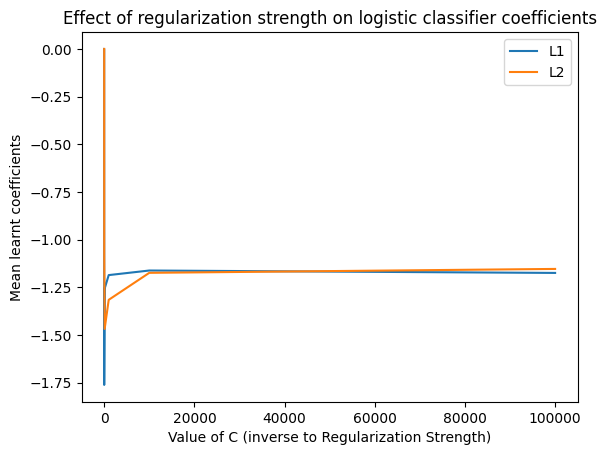

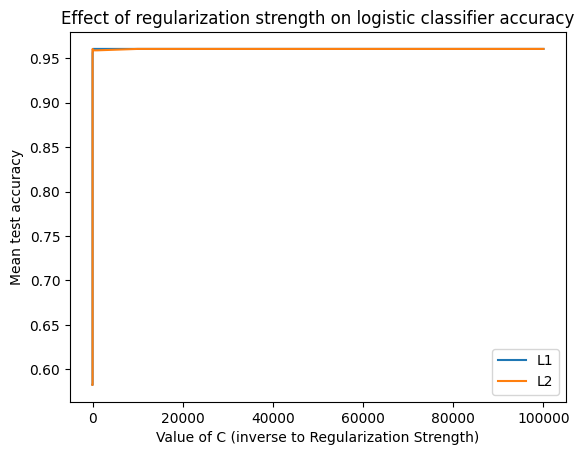

In [13]:
plt.title('Effect of regularization strength on logistic classifier coefficients')
plt.plot(regularizations,mean_coeff_l1,label='L1')
plt.plot(regularizations,mean_coeff_l2,label='L2')
plt.xlabel('Value of C (inverse to Regularization Strength)')
plt.ylabel('Mean learnt coefficients')
plt.legend()
plt.show()

fig, ax = plt.subplots()
plt.title('Effect of regularization strength on logistic classifier accuracy')
plt.plot(regularizations,acc_l1,label='L1')
plt.plot(regularizations,acc_l2,label='L2')
plt.xlabel('Value of C (inverse to Regularization Strength)')
plt.ylabel('Mean test accuracy')
plt.legend()
plt.show()

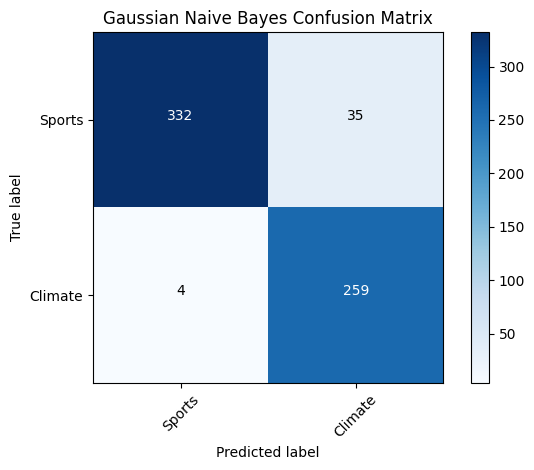

Accuracy:  0.9380952380952381
Recall:  0.9847908745247148
Precision:  0.8809523809523809
F-1 score:  0.9299820466786356


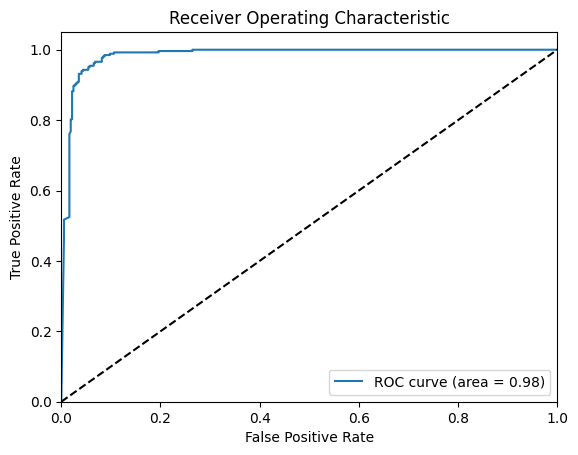

In [14]:
########## Question 7 - Gaussian Naive Bayes Classifier
# Train the GaussianNB classifier
gnb = GaussianNB()
gnb.fit(Xtrain_lsi, ytrain_true)

# Predict the labels of the testing set
y_pred = gnb.predict(Xtest_lsi)

# Compute the confusion matrix
cm = confusion_matrix(ytest_true, y_pred)

# Compute the accuracy, recall, precision and F-1 score
accuracy = accuracy_score(ytest_true, y_pred)
recall = recall_score(ytest_true, y_pred)
precision = precision_score(ytest_true, y_pred)
f1 = f1_score(ytest_true, y_pred)

plt.figure()
plot_confusion_matrix(cm, classes=class_names, title='Gaussian Naive Bayes Confusion Matrix') 
plt.show()

print("Accuracy: ", accuracy)
print("Recall: ", recall)
print("Precision: ", precision)
print("F-1 score: ", f1)

# Plot the ROC curve
y_prob = gnb.predict_proba(Xtest_lsi)[:, 1]
fpr, tpr, thresholds = roc_curve(ytest_true, y_prob)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, label="ROC curve (area = {:.2f})".format(roc_auc))
plt.plot([0, 1], [0, 1], "k--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic")
plt.legend(loc="lower right")
plt.show()


In [15]:
########## Question 8 - 
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.decomposition import TruncatedSVD, NMF
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
from nltk.stem import WordNetLemmatizer, SnowballStemmer
from nltk.tokenize import word_tokenize
import pandas as pd
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD, NMF
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report



# Define a function to lemmatize the text
def lemmatize_text(text):
    lemmatizer = WordNetLemmatizer()
    tokens = word_tokenize(text)
    lemmatized_tokens = [lemmatizer.lemmatize(token) for token in tokens]
    return " ".join(lemmatized_tokens)

# Define a function to stem the text
def stem_text(text):
    stemmer = SnowballStemmer("english")
    tokens = word_tokenize(text)
    stemmed_tokens = [stemmer.stem(token) for token in tokens]
    return " ".join(stemmed_tokens)


# Define the pipeline
pipeline = Pipeline([
    ('loading', None),
    ('vectorization', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
    ('dimensionality_reduction', None),
    ('classification', None)
])

# Define the parameter grid for GridSearchCV
param_grid = {
    'loading': [None, ('clean', clean)],
    'vectorization__min_df': [3, 5],
    'vectorization__tokenizer': [None, lemmatize_text, stem_text],
    'dimensionality_reduction': [TruncatedSVD(random_state=42), NMF(random_state=42)],
    'dimensionality_reduction__n_components': [5, 30, 80],
    'classification': [SVC(kernel='rbf', gamma=0.1, C=10), 
                        LogisticRegression(penalty='l1', C=1),
                        LogisticRegression(penalty='l2', C=1),
                        GaussianNB()]
}

# Perform GridSearchCV with 5-fold cross-validation
grid_search = GridSearchCV(pipeline, param_grid, cv=5, verbose=5, n_jobs=-1, scoring='accuracy')
grid_search.fit(train['cleaned'],ytrain_true)


Fitting 5 folds for each of 288 candidates, totalling 1440 fits


/opt/homebrew/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/opt/homebrew/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/opt/homebrew/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/opt/homebrew/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/opt/homebrew/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


[CV 2/5] END classification=SVC(C=10, gamma=0.1), dimensionality_reduction=TruncatedSVD(random_state=42), dimensionality_reduction__n_components=5, loading=None, vectorization__min_df=3, vectorization__tokenizer=None;, score=0.937 total time=   0.6s
[CV 1/5] END classification=SVC(C=10, gamma=0.1), dimensionality_reduction=TruncatedSVD(random_state=42), dimensionality_reduction__n_components=5, loading=None, vectorization__min_df=3, vectorization__tokenizer=None;, score=0.915 total time=   0.7s
[CV 3/5] END classification=SVC(C=10, gamma=0.1), dimensionality_reduction=TruncatedSVD(random_state=42), dimensionality_reduction__n_components=5, loading=None, vectorization__min_df=3, vectorization__tokenizer=None;, score=0.935 total time=   0.6s
[CV 4/5] END classification=SVC(C=10, gamma=0.1), dimensionality_reduction=TruncatedSVD(random_state=42), dimensionality_reduction__n_components=5, loading=None, vectorization__min_df=3, vectorization__tokenizer=None;, score=0.911 total time=   0.7s


/opt/homebrew/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/opt/homebrew/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/opt/homebrew/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/opt/homebrew/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/opt/homebrew/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


[CV 4/5] END classification=SVC(C=10, gamma=0.1), dimensionality_reduction=TruncatedSVD(random_state=42), dimensionality_reduction__n_components=5, loading=None, vectorization__min_df=3, vectorization__tokenizer=<function lemmatize_text at 0x1215b0dc0>;, score=0.704 total time=   6.3s
[CV 5/5] END classification=SVC(C=10, gamma=0.1), dimensionality_reduction=TruncatedSVD(random_state=42), dimensionality_reduction__n_components=5, loading=None, vectorization__min_df=3, vectorization__tokenizer=<function lemmatize_text at 0x122330dc0>;, score=0.696 total time=   6.3s
[CV 3/5] END classification=SVC(C=10, gamma=0.1), dimensionality_reduction=TruncatedSVD(random_state=42), dimensionality_reduction__n_components=5, loading=None, vectorization__min_df=3, vectorization__tokenizer=<function lemmatize_text at 0x10f2acdc0>;, score=0.690 total time=   6.4s
[CV 2/5] END classification=SVC(C=10, gamma=0.1), dimensionality_reduction=TruncatedSVD(random_state=42), dimensionality_reduction__n_componen

/opt/homebrew/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/opt/homebrew/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/opt/homebrew/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/opt/homebrew/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


[CV 5/5] END classification=SVC(C=10, gamma=0.1), dimensionality_reduction=TruncatedSVD(random_state=42), dimensionality_reduction__n_components=5, loading=None, vectorization__min_df=5, vectorization__tokenizer=None;, score=0.907 total time=   0.6s


/opt/homebrew/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


[CV 2/5] END classification=SVC(C=10, gamma=0.1), dimensionality_reduction=TruncatedSVD(random_state=42), dimensionality_reduction__n_components=5, loading=None, vectorization__min_df=3, vectorization__tokenizer=<function stem_text at 0x1224724d0>;, score=0.732 total time=  10.7s
[CV 4/5] END classification=SVC(C=10, gamma=0.1), dimensionality_reduction=TruncatedSVD(random_state=42), dimensionality_reduction__n_components=5, loading=None, vectorization__min_df=3, vectorization__tokenizer=<function stem_text at 0x10bb3e4d0>;, score=0.730 total time=  10.8s


/opt/homebrew/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/opt/homebrew/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


[CV 1/5] END classification=SVC(C=10, gamma=0.1), dimensionality_reduction=TruncatedSVD(random_state=42), dimensionality_reduction__n_components=5, loading=None, vectorization__min_df=3, vectorization__tokenizer=<function stem_text at 0x118c3e4d0>;, score=0.736 total time=  11.1s
[CV 5/5] END classification=SVC(C=10, gamma=0.1), dimensionality_reduction=TruncatedSVD(random_state=42), dimensionality_reduction__n_components=5, loading=None, vectorization__min_df=3, vectorization__tokenizer=<function stem_text at 0x1192464d0>;, score=0.718 total time=  10.9s
[CV 3/5] END classification=SVC(C=10, gamma=0.1), dimensionality_reduction=TruncatedSVD(random_state=42), dimensionality_reduction__n_components=5, loading=None, vectorization__min_df=3, vectorization__tokenizer=<function stem_text at 0x10d8564d0>;, score=0.708 total time=  11.2s


/opt/homebrew/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/opt/homebrew/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/opt/homebrew/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


[CV 1/5] END classification=SVC(C=10, gamma=0.1), dimensionality_reduction=TruncatedSVD(random_state=42), dimensionality_reduction__n_components=5, loading=None, vectorization__min_df=5, vectorization__tokenizer=<function lemmatize_text at 0x113d70dc0>;, score=0.748 total time=   5.7s
[CV 1/5] END classification=SVC(C=10, gamma=0.1), dimensionality_reduction=TruncatedSVD(random_state=42), dimensionality_reduction__n_components=5, loading=('clean', <function clean at 0x120957d00>), vectorization__min_df=3, vectorization__tokenizer=None;, score=nan total time=   0.0s
[CV 2/5] END classification=SVC(C=10, gamma=0.1), dimensionality_reduction=TruncatedSVD(random_state=42), dimensionality_reduction__n_components=5, loading=('clean', <function clean at 0x113d70dc0>), vectorization__min_df=3, vectorization__tokenizer=None;, score=nan total time=   0.0s
[CV 3/5] END classification=SVC(C=10, gamma=0.1), dimensionality_reduction=TruncatedSVD(random_state=42), dimensionality_reduction__n_componen

/opt/homebrew/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/opt/homebrew/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/opt/homebrew/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/opt/homebrew/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/opt/homebrew/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


[CV 2/5] END classification=SVC(C=10, gamma=0.1), dimensionality_reduction=TruncatedSVD(random_state=42), dimensionality_reduction__n_components=30, loading=None, vectorization__min_df=3, vectorization__tokenizer=<function lemmatize_text at 0x127657e20>;, score=0.821 total time=   5.5s
[CV 1/5] END classification=SVC(C=10, gamma=0.1), dimensionality_reduction=TruncatedSVD(random_state=42), dimensionality_reduction__n_components=30, loading=None, vectorization__min_df=3, vectorization__tokenizer=<function lemmatize_text at 0x113d4a4d0>;, score=0.815 total time=   5.7s
[CV 3/5] END classification=SVC(C=10, gamma=0.1), dimensionality_reduction=TruncatedSVD(random_state=42), dimensionality_reduction__n_components=30, loading=None, vectorization__min_df=3, vectorization__tokenizer=<function lemmatize_text at 0x125857e20>;, score=0.788 total time=   5.6s


/opt/homebrew/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/opt/homebrew/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/opt/homebrew/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


[CV 4/5] END classification=SVC(C=10, gamma=0.1), dimensionality_reduction=TruncatedSVD(random_state=42), dimensionality_reduction__n_components=30, loading=None, vectorization__min_df=3, vectorization__tokenizer=<function lemmatize_text at 0x118874dc0>;, score=0.819 total time=   5.7s
[CV 5/5] END classification=SVC(C=10, gamma=0.1), dimensionality_reduction=TruncatedSVD(random_state=42), dimensionality_reduction__n_components=30, loading=None, vectorization__min_df=3, vectorization__tokenizer=<function lemmatize_text at 0x12ba53d00>;, score=0.819 total time=   5.8s


/opt/homebrew/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/opt/homebrew/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


[CV 2/5] END classification=SVC(C=10, gamma=0.1), dimensionality_reduction=TruncatedSVD(random_state=42), dimensionality_reduction__n_components=5, loading=None, vectorization__min_df=5, vectorization__tokenizer=<function stem_text at 0x10e273d90>;, score=0.732 total time=  10.8s
[CV 5/5] END classification=SVC(C=10, gamma=0.1), dimensionality_reduction=TruncatedSVD(random_state=42), dimensionality_reduction__n_components=5, loading=None, vectorization__min_df=5, vectorization__tokenizer=<function stem_text at 0x10fe6bd90>;, score=0.718 total time=  10.5s
[CV 4/5] END classification=SVC(C=10, gamma=0.1), dimensionality_reduction=TruncatedSVD(random_state=42), dimensionality_reduction__n_components=5, loading=None, vectorization__min_df=5, vectorization__tokenizer=<function stem_text at 0x11c0c3d90>;, score=0.730 total time=  10.8s
[CV 1/5] END classification=SVC(C=10, gamma=0.1), dimensionality_reduction=TruncatedSVD(random_state=42), dimensionality_reduction__n_components=5, loading=N

/opt/homebrew/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/opt/homebrew/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/opt/homebrew/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/opt/homebrew/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/opt/homebrew/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


[CV 4/5] END classification=SVC(C=10, gamma=0.1), dimensionality_reduction=TruncatedSVD(random_state=42), dimensionality_reduction__n_components=30, loading=None, vectorization__min_df=5, vectorization__tokenizer=None;, score=0.933 total time=   0.7s
[CV 5/5] END classification=SVC(C=10, gamma=0.1), dimensionality_reduction=TruncatedSVD(random_state=42), dimensionality_reduction__n_components=30, loading=None, vectorization__min_df=5, vectorization__tokenizer=None;, score=0.919 total time=   0.6s
[CV 1/5] END classification=SVC(C=10, gamma=0.1), dimensionality_reduction=TruncatedSVD(random_state=42), dimensionality_reduction__n_components=30, loading=None, vectorization__min_df=5, vectorization__tokenizer=<function lemmatize_text at 0x10d8564d0>;, score=0.815 total time=   6.4s
[CV 4/5] END classification=SVC(C=10, gamma=0.1), dimensionality_reduction=TruncatedSVD(random_state=42), dimensionality_reduction__n_components=30, loading=None, vectorization__min_df=5, vectorization__tokenize

/opt/homebrew/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/opt/homebrew/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


[CV 3/5] END classification=SVC(C=10, gamma=0.1), dimensionality_reduction=TruncatedSVD(random_state=42), dimensionality_reduction__n_components=30, loading=None, vectorization__min_df=5, vectorization__tokenizer=<function lemmatize_text at 0x1192464d0>;, score=0.788 total time=   6.4s
[CV 2/5] END classification=SVC(C=10, gamma=0.1), dimensionality_reduction=TruncatedSVD(random_state=42), dimensionality_reduction__n_components=30, loading=None, vectorization__min_df=5, vectorization__tokenizer=<function lemmatize_text at 0x10bb3e4d0>;, score=0.821 total time=   6.6s
[CV 5/5] END classification=SVC(C=10, gamma=0.1), dimensionality_reduction=TruncatedSVD(random_state=42), dimensionality_reduction__n_components=30, loading=None, vectorization__min_df=5, vectorization__tokenizer=<function lemmatize_text at 0x118c3e4d0>;, score=0.819 total time=   6.5s


/opt/homebrew/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/opt/homebrew/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/opt/homebrew/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


[CV 2/5] END classification=SVC(C=10, gamma=0.1), dimensionality_reduction=TruncatedSVD(random_state=42), dimensionality_reduction__n_components=30, loading=None, vectorization__min_df=3, vectorization__tokenizer=<function stem_text at 0x120957e20>;, score=0.825 total time=  10.8s
[CV 1/5] END classification=SVC(C=10, gamma=0.1), dimensionality_reduction=TruncatedSVD(random_state=42), dimensionality_reduction__n_components=30, loading=('clean', <function clean at 0x113d4a4d0>), vectorization__min_df=3, vectorization__tokenizer=None;, score=nan total time=   0.0s
[CV 2/5] END classification=SVC(C=10, gamma=0.1), dimensionality_reduction=TruncatedSVD(random_state=42), dimensionality_reduction__n_components=30, loading=('clean', <function clean at 0x120957e20>), vectorization__min_df=3, vectorization__tokenizer=None;, score=nan total time=   0.0s
[CV 3/5] END classification=SVC(C=10, gamma=0.1), dimensionality_reduction=TruncatedSVD(random_state=42), dimensionality_reduction__n_components

/opt/homebrew/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/opt/homebrew/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/opt/homebrew/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/opt/homebrew/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/opt/homebrew/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


[CV 5/5] END classification=SVC(C=10, gamma=0.1), dimensionality_reduction=TruncatedSVD(random_state=42), dimensionality_reduction__n_components=80, loading=None, vectorization__min_df=3, vectorization__tokenizer=<function lemmatize_text at 0x12158a4d0>;, score=nan total time=   4.3s
[CV 3/5] END classification=SVC(C=10, gamma=0.1), dimensionality_reduction=TruncatedSVD(random_state=42), dimensionality_reduction__n_components=80, loading=None, vectorization__min_df=3, vectorization__tokenizer=<function lemmatize_text at 0x113d4a4d0>;, score=nan total time=   4.4s
[CV 1/5] END classification=SVC(C=10, gamma=0.1), dimensionality_reduction=TruncatedSVD(random_state=42), dimensionality_reduction__n_components=80, loading=None, vectorization__min_df=3, vectorization__tokenizer=<function lemmatize_text at 0x122330dc0>;, score=nan total time=   4.4s
[CV 4/5] END classification=SVC(C=10, gamma=0.1), dimensionality_reduction=TruncatedSVD(random_state=42), dimensionality_reduction__n_components=

/opt/homebrew/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/opt/homebrew/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/opt/homebrew/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/opt/homebrew/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/opt/homebrew/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


[CV 2/5] END classification=SVC(C=10, gamma=0.1), dimensionality_reduction=TruncatedSVD(random_state=42), dimensionality_reduction__n_components=80, loading=None, vectorization__min_df=3, vectorization__tokenizer=<function lemmatize_text at 0x11c957d00>;, score=nan total time=   4.6s
[CV 4/5] END classification=SVC(C=10, gamma=0.1), dimensionality_reduction=TruncatedSVD(random_state=42), dimensionality_reduction__n_components=30, loading=None, vectorization__min_df=5, vectorization__tokenizer=<function stem_text at 0x10e270040>;, score=0.829 total time=  10.7s
[CV 1/5] END classification=SVC(C=10, gamma=0.1), dimensionality_reduction=TruncatedSVD(random_state=42), dimensionality_reduction__n_components=30, loading=None, vectorization__min_df=5, vectorization__tokenizer=<function stem_text at 0x10fe68040>;, score=0.806 total time=  11.0s
[CV 3/5] END classification=SVC(C=10, gamma=0.1), dimensionality_reduction=TruncatedSVD(random_state=42), dimensionality_reduction__n_components=30, lo

/opt/homebrew/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/opt/homebrew/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/opt/homebrew/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/opt/homebrew/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/opt/homebrew/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


[CV 5/5] END classification=SVC(C=10, gamma=0.1), dimensionality_reduction=TruncatedSVD(random_state=42), dimensionality_reduction__n_components=80, loading=None, vectorization__min_df=5, vectorization__tokenizer=None;, score=0.938 total time=   0.8s
[CV 4/5] END classification=SVC(C=10, gamma=0.1), dimensionality_reduction=TruncatedSVD(random_state=42), dimensionality_reduction__n_components=80, loading=None, vectorization__min_df=5, vectorization__tokenizer=None;, score=0.942 total time=   0.9s
[CV 2/5] END classification=SVC(C=10, gamma=0.1), dimensionality_reduction=TruncatedSVD(random_state=42), dimensionality_reduction__n_components=80, loading=None, vectorization__min_df=3, vectorization__tokenizer=<function stem_text at 0x120957d00>;, score=nan total time=   8.4s
[CV 3/5] END classification=SVC(C=10, gamma=0.1), dimensionality_reduction=TruncatedSVD(random_state=42), dimensionality_reduction__n_components=80, loading=None, vectorization__min_df=3, vectorization__tokenizer=<func

/opt/homebrew/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/opt/homebrew/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


[CV 1/5] END classification=SVC(C=10, gamma=0.1), dimensionality_reduction=TruncatedSVD(random_state=42), dimensionality_reduction__n_components=80, loading=None, vectorization__min_df=3, vectorization__tokenizer=<function stem_text at 0x125857d00>;, score=nan total time=   8.8s
[CV 4/5] END classification=SVC(C=10, gamma=0.1), dimensionality_reduction=TruncatedSVD(random_state=42), dimensionality_reduction__n_components=80, loading=None, vectorization__min_df=3, vectorization__tokenizer=<function stem_text at 0x127657d00>;, score=nan total time=   8.9s
[CV 5/5] END classification=SVC(C=10, gamma=0.1), dimensionality_reduction=TruncatedSVD(random_state=42), dimensionality_reduction__n_components=80, loading=None, vectorization__min_df=3, vectorization__tokenizer=<function stem_text at 0x11884e4d0>;, score=nan total time=   8.8s


/opt/homebrew/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/opt/homebrew/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/opt/homebrew/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


[CV 2/5] END classification=SVC(C=10, gamma=0.1), dimensionality_reduction=TruncatedSVD(random_state=42), dimensionality_reduction__n_components=80, loading=None, vectorization__min_df=5, vectorization__tokenizer=<function lemmatize_text at 0x10d8564d0>;, score=nan total time=   4.4s
[CV 1/5] END classification=SVC(C=10, gamma=0.1), dimensionality_reduction=TruncatedSVD(random_state=42), dimensionality_reduction__n_components=80, loading=('clean', <function clean at 0x10fe6bd90>), vectorization__min_df=3, vectorization__tokenizer=None;, score=nan total time=   0.0s
[CV 2/5] END classification=SVC(C=10, gamma=0.1), dimensionality_reduction=TruncatedSVD(random_state=42), dimensionality_reduction__n_components=80, loading=('clean', <function clean at 0x10d8564d0>), vectorization__min_df=3, vectorization__tokenizer=None;, score=nan total time=   0.0s
[CV 3/5] END classification=SVC(C=10, gamma=0.1), dimensionality_reduction=TruncatedSVD(random_state=42), dimensionality_reduction__n_compone

/opt/homebrew/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/opt/homebrew/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/opt/homebrew/lib/python3.10/site-packages/joblib/externals/loky/process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[CV 3/5] END classification=SVC(C=10, gamma=0.1), dimensionality_reduction=NMF(random_state=42), dimensionality_reduction__n_components=5, loading=None, vectorization__min_df=3, vectorization__tokenizer=None;, score=0.677 total time=   1.3s


/opt/homebrew/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/opt/homebrew/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/opt/homebrew/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/opt/homebrew/lib/python3.10/site-packages/sklearn/decomposition/_nmf.py:1665: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
/opt/homebrew/lib/python3.10/site-packages/sklearn/decomposition/_nmf.py:1665: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


[CV 1/5] END classification=SVC(C=10, gamma=0.1), dimensionality_reduction=TruncatedSVD(random_state=42), dimensionality_reduction__n_components=80, loading=None, vectorization__min_df=5, vectorization__tokenizer=<function stem_text at 0x113d4a4d0>;, score=nan total time=   8.6s
[CV 2/5] END classification=SVC(C=10, gamma=0.1), dimensionality_reduction=NMF(random_state=42), dimensionality_reduction__n_components=5, loading=None, vectorization__min_df=3, vectorization__tokenizer=<function lemmatize_text at 0x125988040>;, score=0.698 total time=   5.9s
[CV 2/5] END classification=SVC(C=10, gamma=0.1), dimensionality_reduction=TruncatedSVD(random_state=42), dimensionality_reduction__n_components=80, loading=None, vectorization__min_df=5, vectorization__tokenizer=<function stem_text at 0x10f2acdc0>;, score=nan total time=   8.5s
[CV 1/5] END classification=SVC(C=10, gamma=0.1), dimensionality_reduction=NMF(random_state=42), dimensionality_reduction__n_components=5, loading=None, vectorizat

/opt/homebrew/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/opt/homebrew/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/opt/homebrew/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/opt/homebrew/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


[CV 3/5] END classification=SVC(C=10, gamma=0.1), dimensionality_reduction=TruncatedSVD(random_state=42), dimensionality_reduction__n_components=80, loading=None, vectorization__min_df=5, vectorization__tokenizer=<function stem_text at 0x12158a4d0>;, score=nan total time=   8.4s
[CV 4/5] END classification=SVC(C=10, gamma=0.1), dimensionality_reduction=TruncatedSVD(random_state=42), dimensionality_reduction__n_components=80, loading=None, vectorization__min_df=5, vectorization__tokenizer=<function stem_text at 0x122330dc0>;, score=nan total time=   8.4s


/opt/homebrew/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/opt/homebrew/lib/python3.10/site-packages/sklearn/decomposition/_nmf.py:1665: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


[CV 5/5] END classification=SVC(C=10, gamma=0.1), dimensionality_reduction=TruncatedSVD(random_state=42), dimensionality_reduction__n_components=80, loading=None, vectorization__min_df=5, vectorization__tokenizer=<function stem_text at 0x11c957d00>;, score=nan total time=   8.6s


/opt/homebrew/lib/python3.10/site-packages/sklearn/decomposition/_nmf.py:1665: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
/opt/homebrew/lib/python3.10/site-packages/sklearn/decomposition/_nmf.py:1665: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


[CV 1/5] END classification=SVC(C=10, gamma=0.1), dimensionality_reduction=NMF(random_state=42), dimensionality_reduction__n_components=5, loading=None, vectorization__min_df=5, vectorization__tokenizer=None;, score=0.724 total time=   0.8s
[CV 2/5] END classification=SVC(C=10, gamma=0.1), dimensionality_reduction=NMF(random_state=42), dimensionality_reduction__n_components=5, loading=None, vectorization__min_df=5, vectorization__tokenizer=None;, score=0.716 total time=   0.9s
[CV 3/5] END classification=SVC(C=10, gamma=0.1), dimensionality_reduction=NMF(random_state=42), dimensionality_reduction__n_components=5, loading=None, vectorization__min_df=3, vectorization__tokenizer=<function lemmatize_text at 0x117a60dc0>;, score=0.683 total time=   6.6s
[CV 4/5] END classification=SVC(C=10, gamma=0.1), dimensionality_reduction=NMF(random_state=42), dimensionality_reduction__n_components=5, loading=None, vectorization__min_df=3, vectorization__tokenizer=<function lemmatize_text at 0x130260dc

/opt/homebrew/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/opt/homebrew/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


[CV 4/5] END classification=SVC(C=10, gamma=0.1), dimensionality_reduction=NMF(random_state=42), dimensionality_reduction__n_components=5, loading=None, vectorization__min_df=5, vectorization__tokenizer=None;, score=0.702 total time=   0.8s
[CV 3/5] END classification=SVC(C=10, gamma=0.1), dimensionality_reduction=NMF(random_state=42), dimensionality_reduction__n_components=5, loading=None, vectorization__min_df=5, vectorization__tokenizer=None;, score=0.681 total time=   1.2s
[CV 5/5] END classification=SVC(C=10, gamma=0.1), dimensionality_reduction=NMF(random_state=42), dimensionality_reduction__n_components=5, loading=None, vectorization__min_df=5, vectorization__tokenizer=None;, score=0.706 total time=   0.8s


/opt/homebrew/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/opt/homebrew/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/opt/homebrew/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/opt/homebrew/lib/python3.10/site-packages/sklearn/decomposition/_nmf.py:1665: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
/opt/homebrew/lib/python3.10/site-packages/sklearn/decomposition/_nmf.py:1665: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
/opt/homebrew/lib/python3.10/site-packa

[CV 1/5] END classification=SVC(C=10, gamma=0.1), dimensionality_reduction=NMF(random_state=42), dimensionality_reduction__n_components=5, loading=None, vectorization__min_df=5, vectorization__tokenizer=<function lemmatize_text at 0x1345c04c0>;, score=0.708 total time=   5.8s


/opt/homebrew/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


[CV 2/5] END classification=SVC(C=10, gamma=0.1), dimensionality_reduction=NMF(random_state=42), dimensionality_reduction__n_components=5, loading=None, vectorization__min_df=5, vectorization__tokenizer=<function lemmatize_text at 0x11aec44c0>;, score=0.698 total time=   6.0s
[CV 4/5] END classification=SVC(C=10, gamma=0.1), dimensionality_reduction=NMF(random_state=42), dimensionality_reduction__n_components=5, loading=None, vectorization__min_df=5, vectorization__tokenizer=<function lemmatize_text at 0x127657d00>;, score=0.694 total time=   5.8s


/opt/homebrew/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/opt/homebrew/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


[CV 3/5] END classification=SVC(C=10, gamma=0.1), dimensionality_reduction=NMF(random_state=42), dimensionality_reduction__n_components=5, loading=None, vectorization__min_df=5, vectorization__tokenizer=<function lemmatize_text at 0x11884e4d0>;, score=0.683 total time=   6.0s


/opt/homebrew/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


[CV 5/5] END classification=SVC(C=10, gamma=0.1), dimensionality_reduction=NMF(random_state=42), dimensionality_reduction__n_components=5, loading=None, vectorization__min_df=5, vectorization__tokenizer=<function lemmatize_text at 0x1246344c0>;, score=0.685 total time=   6.1s


/opt/homebrew/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/opt/homebrew/lib/python3.10/site-packages/sklearn/decomposition/_nmf.py:1665: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
/opt/homebrew/lib/python3.10/site-packages/sklearn/decomposition/_nmf.py:1665: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
/opt/homebrew/lib/python3.10/site-packages/sklearn/decomposition/_nmf.py:1665: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
/opt/homebrew/lib/python3.10/site-packages/sklearn/decomposition/_nmf.py:1665: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
/opt/homebrew/lib/python3.10/site

[CV 1/5] END classification=SVC(C=10, gamma=0.1), dimensionality_reduction=NMF(random_state=42), dimensionality_reduction__n_components=5, loading=None, vectorization__min_df=3, vectorization__tokenizer=<function stem_text at 0x120957d00>;, score=0.716 total time=  10.9s
[CV 1/5] END classification=SVC(C=10, gamma=0.1), dimensionality_reduction=NMF(random_state=42), dimensionality_reduction__n_components=5, loading=('clean', <function clean at 0x113d4a4d0>), vectorization__min_df=3, vectorization__tokenizer=None;, score=nan total time=   0.0s
[CV 2/5] END classification=SVC(C=10, gamma=0.1), dimensionality_reduction=NMF(random_state=42), dimensionality_reduction__n_components=5, loading=None, vectorization__min_df=3, vectorization__tokenizer=<function stem_text at 0x105061a20>;, score=0.732 total time=  10.9s
[CV 2/5] END classification=SVC(C=10, gamma=0.1), dimensionality_reduction=NMF(random_state=42), dimensionality_reduction__n_components=5, loading=('clean', <function clean at 0x1

/opt/homebrew/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


[CV 4/5] END classification=SVC(C=10, gamma=0.1), dimensionality_reduction=NMF(random_state=42), dimensionality_reduction__n_components=30, loading=None, vectorization__min_df=3, vectorization__tokenizer=None;, score=0.933 total time=   2.7s
[CV 1/5] END classification=SVC(C=10, gamma=0.1), dimensionality_reduction=NMF(random_state=42), dimensionality_reduction__n_components=30, loading=None, vectorization__min_df=3, vectorization__tokenizer=None;, score=0.937 total time=   2.9s


/opt/homebrew/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


[CV 2/5] END classification=SVC(C=10, gamma=0.1), dimensionality_reduction=NMF(random_state=42), dimensionality_reduction__n_components=30, loading=None, vectorization__min_df=3, vectorization__tokenizer=None;, score=0.938 total time=   3.5s


/opt/homebrew/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


[CV 5/5] END classification=SVC(C=10, gamma=0.1), dimensionality_reduction=NMF(random_state=42), dimensionality_reduction__n_components=30, loading=None, vectorization__min_df=3, vectorization__tokenizer=None;, score=0.933 total time=   3.3s


/opt/homebrew/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/opt/homebrew/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/opt/homebrew/lib/python3.10/site-packages/sklearn/decomposition/_nmf.py:1665: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
/opt/homebrew/lib/python3.10/site-packages/sklearn/decomposition/_nmf.py:1665: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
/opt/homebrew/lib/python3.10/site-packages/sklearn/decomposition/_nmf.py:1665: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
/opt/homebrew/lib/python3.10/site-pa

[CV 1/5] END classification=SVC(C=10, gamma=0.1), dimensionality_reduction=NMF(random_state=42), dimensionality_reduction__n_components=5, loading=None, vectorization__min_df=5, vectorization__tokenizer=<function stem_text at 0x134557e20>;, score=0.716 total time=  11.1s
[CV 2/5] END classification=SVC(C=10, gamma=0.1), dimensionality_reduction=NMF(random_state=42), dimensionality_reduction__n_components=5, loading=None, vectorization__min_df=5, vectorization__tokenizer=<function stem_text at 0x11ae5be20>;, score=0.732 total time=  11.3s


/opt/homebrew/lib/python3.10/site-packages/sklearn/decomposition/_nmf.py:1665: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
/opt/homebrew/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


[CV 5/5] END classification=SVC(C=10, gamma=0.1), dimensionality_reduction=NMF(random_state=42), dimensionality_reduction__n_components=5, loading=None, vectorization__min_df=5, vectorization__tokenizer=<function stem_text at 0x1245cbd00>;, score=0.649 total time=  11.2s
[CV 4/5] END classification=SVC(C=10, gamma=0.1), dimensionality_reduction=NMF(random_state=42), dimensionality_reduction__n_components=5, loading=None, vectorization__min_df=5, vectorization__tokenizer=<function stem_text at 0x11c957d00>;, score=0.619 total time=  11.6s
[CV 3/5] END classification=SVC(C=10, gamma=0.1), dimensionality_reduction=NMF(random_state=42), dimensionality_reduction__n_components=5, loading=None, vectorization__min_df=5, vectorization__tokenizer=<function stem_text at 0x122330dc0>;, score=0.623 total time=  11.7s


/opt/homebrew/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/opt/homebrew/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/opt/homebrew/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/opt/homebrew/lib/python3.10/site-packages/sklearn/decomposition/_nmf.py:1665: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
/opt/homebrew/lib/python3.10/site-packages/sklearn/decomposition/_nmf.py:1665: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


[CV 1/5] END classification=SVC(C=10, gamma=0.1), dimensionality_reduction=NMF(random_state=42), dimensionality_reduction__n_components=30, loading=None, vectorization__min_df=3, vectorization__tokenizer=<function lemmatize_text at 0x120957e20>;, score=0.677 total time=   6.5s


/opt/homebrew/lib/python3.10/site-packages/sklearn/decomposition/_nmf.py:1665: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


[CV 2/5] END classification=SVC(C=10, gamma=0.1), dimensionality_reduction=NMF(random_state=42), dimensionality_reduction__n_components=30, loading=None, vectorization__min_df=3, vectorization__tokenizer=<function lemmatize_text at 0x12158a4d0>;, score=0.760 total time=   6.5s


/opt/homebrew/lib/python3.10/site-packages/sklearn/decomposition/_nmf.py:1665: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
/opt/homebrew/lib/python3.10/site-packages/sklearn/decomposition/_nmf.py:1665: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
/opt/homebrew/lib/python3.10/site-packages/sklearn/decomposition/_nmf.py:1665: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


[CV 4/5] END classification=SVC(C=10, gamma=0.1), dimensionality_reduction=NMF(random_state=42), dimensionality_reduction__n_components=30, loading=None, vectorization__min_df=3, vectorization__tokenizer=<function lemmatize_text at 0x12ba53e20>;, score=0.742 total time=   6.3s


/opt/homebrew/lib/python3.10/site-packages/sklearn/decomposition/_nmf.py:1665: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


[CV 5/5] END classification=SVC(C=10, gamma=0.1), dimensionality_reduction=NMF(random_state=42), dimensionality_reduction__n_components=30, loading=None, vectorization__min_df=3, vectorization__tokenizer=<function lemmatize_text at 0x10ff80040>;, score=0.669 total time=   6.9s


/opt/homebrew/lib/python3.10/site-packages/sklearn/decomposition/_nmf.py:1665: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
/opt/homebrew/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


[CV 3/5] END classification=SVC(C=10, gamma=0.1), dimensionality_reduction=NMF(random_state=42), dimensionality_reduction__n_components=30, loading=None, vectorization__min_df=3, vectorization__tokenizer=<function lemmatize_text at 0x1219bcdc0>;, score=0.675 total time=   7.1s
[CV 1/5] END classification=SVC(C=10, gamma=0.1), dimensionality_reduction=NMF(random_state=42), dimensionality_reduction__n_components=30, loading=None, vectorization__min_df=5, vectorization__tokenizer=None;, score=0.937 total time=   2.3s
[CV 3/5] END classification=SVC(C=10, gamma=0.1), dimensionality_reduction=NMF(random_state=42), dimensionality_reduction__n_components=30, loading=None, vectorization__min_df=5, vectorization__tokenizer=None;, score=0.940 total time=   2.1s


/opt/homebrew/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


[CV 2/5] END classification=SVC(C=10, gamma=0.1), dimensionality_reduction=NMF(random_state=42), dimensionality_reduction__n_components=30, loading=None, vectorization__min_df=5, vectorization__tokenizer=None;, score=0.933 total time=   3.6s


/opt/homebrew/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


[CV 4/5] END classification=SVC(C=10, gamma=0.1), dimensionality_reduction=NMF(random_state=42), dimensionality_reduction__n_components=30, loading=None, vectorization__min_df=5, vectorization__tokenizer=None;, score=0.925 total time=   2.8s


/opt/homebrew/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


[CV 5/5] END classification=SVC(C=10, gamma=0.1), dimensionality_reduction=NMF(random_state=42), dimensionality_reduction__n_components=30, loading=None, vectorization__min_df=5, vectorization__tokenizer=None;, score=0.931 total time=   3.1s


/opt/homebrew/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/opt/homebrew/lib/python3.10/site-packages/sklearn/decomposition/_nmf.py:1665: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
/opt/homebrew/lib/python3.10/site-packages/sklearn/decomposition/_nmf.py:1665: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
/opt/homebrew/lib/python3.10/site-packages/sklearn/decomposition/_nmf.py:1665: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
/opt/homebrew/lib/python3.10/site-packages/sklearn/decomposition/_nmf.py:1665: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
/opt/homebrew/lib/python3.10/site

[CV 1/5] END classification=SVC(C=10, gamma=0.1), dimensionality_reduction=NMF(random_state=42), dimensionality_reduction__n_components=30, loading=None, vectorization__min_df=5, vectorization__tokenizer=<function lemmatize_text at 0x1265c04c0>;, score=0.677 total time=   6.2s


/opt/homebrew/lib/python3.10/site-packages/sklearn/decomposition/_nmf.py:1665: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
/opt/homebrew/lib/python3.10/site-packages/sklearn/decomposition/_nmf.py:1665: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
/opt/homebrew/lib/python3.10/site-packages/sklearn/decomposition/_nmf.py:1665: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
/opt/homebrew/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


[CV 2/5] END classification=SVC(C=10, gamma=0.1), dimensionality_reduction=NMF(random_state=42), dimensionality_reduction__n_components=30, loading=None, vectorization__min_df=5, vectorization__tokenizer=<function lemmatize_text at 0x12ba53e20>;, score=0.760 total time=   6.3s


/opt/homebrew/lib/python3.10/site-packages/sklearn/decomposition/_nmf.py:1665: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
/opt/homebrew/lib/python3.10/site-packages/sklearn/decomposition/_nmf.py:1665: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
/opt/homebrew/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


[CV 1/5] END classification=SVC(C=10, gamma=0.1), dimensionality_reduction=NMF(random_state=42), dimensionality_reduction__n_components=30, loading=None, vectorization__min_df=3, vectorization__tokenizer=<function stem_text at 0x1345c04c0>;, score=0.750 total time=  11.6s
[CV 3/5] END classification=SVC(C=10, gamma=0.1), dimensionality_reduction=NMF(random_state=42), dimensionality_reduction__n_components=30, loading=None, vectorization__min_df=5, vectorization__tokenizer=<function lemmatize_text at 0x125857e20>;, score=0.675 total time=   6.3s


/opt/homebrew/lib/python3.10/site-packages/sklearn/decomposition/_nmf.py:1665: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
/opt/homebrew/lib/python3.10/site-packages/sklearn/decomposition/_nmf.py:1665: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
/opt/homebrew/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/opt/homebrew/lib/python3.10/site-packages/sklearn/decomposition/_nmf.py:1665: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
/opt/homebrew/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


[CV 2/5] END classification=SVC(C=10, gamma=0.1), dimensionality_reduction=NMF(random_state=42), dimensionality_reduction__n_components=30, loading=None, vectorization__min_df=3, vectorization__tokenizer=<function stem_text at 0x11aec44c0>;, score=0.730 total time=  11.5s


/opt/homebrew/lib/python3.10/site-packages/sklearn/decomposition/_nmf.py:1665: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


[CV 3/5] END classification=SVC(C=10, gamma=0.1), dimensionality_reduction=NMF(random_state=42), dimensionality_reduction__n_components=30, loading=None, vectorization__min_df=3, vectorization__tokenizer=<function stem_text at 0x1246344c0>;, score=0.788 total time=  11.5s
[CV 1/5] END classification=SVC(C=10, gamma=0.1), dimensionality_reduction=NMF(random_state=42), dimensionality_reduction__n_components=30, loading=('clean', <function clean at 0x1245cbd00>), vectorization__min_df=3, vectorization__tokenizer=None;, score=nan total time=   0.0s
[CV 2/5] END classification=SVC(C=10, gamma=0.1), dimensionality_reduction=NMF(random_state=42), dimensionality_reduction__n_components=30, loading=('clean', <function clean at 0x1246344c0>), vectorization__min_df=3, vectorization__tokenizer=None;, score=nan total time=   0.0s
[CV 3/5] END classification=SVC(C=10, gamma=0.1), dimensionality_reduction=NMF(random_state=42), dimensionality_reduction__n_components=30, loading=('clean', <function cle

/opt/homebrew/lib/python3.10/site-packages/sklearn/decomposition/_nmf.py:1665: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
/opt/homebrew/lib/python3.10/site-packages/sklearn/decomposition/_nmf.py:1665: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


[CV 4/5] END classification=SVC(C=10, gamma=0.1), dimensionality_reduction=NMF(random_state=42), dimensionality_reduction__n_components=30, loading=('clean', <function clean at 0x1245cbd00>), vectorization__min_df=3, vectorization__tokenizer=<function lemmatize_text at 0x1245cbe20>;, score=nan total time=   0.0s
[CV 5/5] END classification=SVC(C=10, gamma=0.1), dimensionality_reduction=NMF(random_state=42), dimensionality_reduction__n_components=30, loading=None, vectorization__min_df=3, vectorization__tokenizer=<function stem_text at 0x127657d00>;, score=0.764 total time=  11.6s
[CV 5/5] END classification=SVC(C=10, gamma=0.1), dimensionality_reduction=NMF(random_state=42), dimensionality_reduction__n_components=30, loading=('clean', <function clean at 0x1246344c0>), vectorization__min_df=3, vectorization__tokenizer=<function lemmatize_text at 0x117a60dc0>;, score=nan total time=   0.0s
[CV 1/5] END classification=SVC(C=10, gamma=0.1), dimensionality_reduction=NMF(random_state=42), di

/opt/homebrew/lib/python3.10/site-packages/sklearn/decomposition/_nmf.py:1665: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
/opt/homebrew/lib/python3.10/site-packages/sklearn/decomposition/_nmf.py:1665: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


[CV 4/5] END classification=SVC(C=10, gamma=0.1), dimensionality_reduction=NMF(random_state=42), dimensionality_reduction__n_components=30, loading=('clean', <function clean at 0x1245cbe20>), vectorization__min_df=5, vectorization__tokenizer=<function lemmatize_text at 0x1245cbd00>;, score=nan total time=   0.0s
[CV 5/5] END classification=SVC(C=10, gamma=0.1), dimensionality_reduction=NMF(random_state=42), dimensionality_reduction__n_components=30, loading=('clean', <function clean at 0x127657d00>), vectorization__min_df=5, vectorization__tokenizer=<function lemmatize_text at 0x127657e20>;, score=nan total time=   0.0s
[CV 1/5] END classification=SVC(C=10, gamma=0.1), dimensionality_reduction=NMF(random_state=42), dimensionality_reduction__n_components=30, loading=('clean', <function clean at 0x10ff80040>), vectorization__min_df=5, vectorization__tokenizer=<function stem_text at 0x10ff80550>;, score=nan total time=   0.0s
[CV 4/5] END classification=SVC(C=10, gamma=0.1), dimensionalit

/opt/homebrew/lib/python3.10/site-packages/sklearn/decomposition/_nmf.py:1665: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
/opt/homebrew/lib/python3.10/site-packages/sklearn/decomposition/_nmf.py:1665: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
/opt/homebrew/lib/python3.10/site-packages/sklearn/decomposition/_nmf.py:1665: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
/opt/homebrew/lib/python3.10/site-packages/sklearn/decomposition/_nmf.py:1665: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
/opt/homebrew/lib/python3.10/site-packages/sklearn/decomposition/_nmf.py:1665: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
/opt/homebrew/lib/python3.10/s

[CV 1/5] END classification=SVC(C=10, gamma=0.1), dimensionality_reduction=NMF(random_state=42), dimensionality_reduction__n_components=30, loading=None, vectorization__min_df=5, vectorization__tokenizer=<function stem_text at 0x12655be20>;, score=0.750 total time=  12.9s


/opt/homebrew/lib/python3.10/site-packages/sklearn/decomposition/_nmf.py:1665: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
/opt/homebrew/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


[CV 2/5] END classification=SVC(C=10, gamma=0.1), dimensionality_reduction=NMF(random_state=42), dimensionality_reduction__n_components=30, loading=None, vectorization__min_df=5, vectorization__tokenizer=<function stem_text at 0x12ba53e20>;, score=0.730 total time=  12.9s


/opt/homebrew/lib/python3.10/site-packages/sklearn/decomposition/_nmf.py:1665: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
/opt/homebrew/lib/python3.10/site-packages/sklearn/decomposition/_nmf.py:1665: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
/opt/homebrew/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/opt/homebrew/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


[CV 3/5] END classification=SVC(C=10, gamma=0.1), dimensionality_reduction=NMF(random_state=42), dimensionality_reduction__n_components=30, loading=None, vectorization__min_df=5, vectorization__tokenizer=<function stem_text at 0x134557e20>;, score=0.788 total time=  13.1s
[CV 4/5] END classification=SVC(C=10, gamma=0.1), dimensionality_reduction=NMF(random_state=42), dimensionality_reduction__n_components=30, loading=None, vectorization__min_df=5, vectorization__tokenizer=<function stem_text at 0x12158a4d0>;, score=0.712 total time=  13.0s


/opt/homebrew/lib/python3.10/site-packages/sklearn/decomposition/_nmf.py:1665: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
/opt/homebrew/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


[CV 5/5] END classification=SVC(C=10, gamma=0.1), dimensionality_reduction=NMF(random_state=42), dimensionality_reduction__n_components=30, loading=None, vectorization__min_df=5, vectorization__tokenizer=<function stem_text at 0x11ae5be20>;, score=0.764 total time=  13.2s
[CV 3/5] END classification=SVC(C=10, gamma=0.1), dimensionality_reduction=NMF(random_state=42), dimensionality_reduction__n_components=80, loading=None, vectorization__min_df=3, vectorization__tokenizer=None;, score=0.946 total time=  18.9s
[CV 1/5] END classification=SVC(C=10, gamma=0.1), dimensionality_reduction=NMF(random_state=42), dimensionality_reduction__n_components=80, loading=None, vectorization__min_df=3, vectorization__tokenizer=<function lemmatize_text at 0x1265c04c0>;, score=0.798 total time=  10.1s


/opt/homebrew/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/opt/homebrew/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/opt/homebrew/lib/python3.10/site-packages/sklearn/decomposition/_nmf.py:1665: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
/opt/homebrew/lib/python3.10/site-packages/sklearn/decomposition/_nmf.py:1665: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
/opt/homebrew/lib/python3.10/site-packages/sklearn/decomposition/_nmf.py:1665: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


[CV 2/5] END classification=SVC(C=10, gamma=0.1), dimensionality_reduction=NMF(random_state=42), dimensionality_reduction__n_components=80, loading=None, vectorization__min_df=3, vectorization__tokenizer=<function lemmatize_text at 0x12ba53e20>;, score=0.796 total time=  11.9s
[CV 2/5] END classification=SVC(C=10, gamma=0.1), dimensionality_reduction=NMF(random_state=42), dimensionality_reduction__n_components=80, loading=None, vectorization__min_df=3, vectorization__tokenizer=None;, score=0.927 total time=  23.0s
[CV 5/5] END classification=SVC(C=10, gamma=0.1), dimensionality_reduction=NMF(random_state=42), dimensionality_reduction__n_components=80, loading=None, vectorization__min_df=3, vectorization__tokenizer=<function lemmatize_text at 0x11aec44c0>;, score=0.720 total time=  10.6s


/opt/homebrew/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/opt/homebrew/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/opt/homebrew/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/opt/homebrew/lib/python3.10/site-packages/sklearn/decomposition/_nmf.py:1665: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
/opt/homebrew/lib/python3.10/site-packages/sklearn/decomposition/_nmf.py:1665: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


[CV 3/5] END classification=SVC(C=10, gamma=0.1), dimensionality_reduction=NMF(random_state=42), dimensionality_reduction__n_components=80, loading=None, vectorization__min_df=3, vectorization__tokenizer=<function lemmatize_text at 0x1345c04c0>;, score=0.768 total time=  11.4s
[CV 4/5] END classification=SVC(C=10, gamma=0.1), dimensionality_reduction=NMF(random_state=42), dimensionality_reduction__n_components=80, loading=None, vectorization__min_df=3, vectorization__tokenizer=<function lemmatize_text at 0x125857e20>;, score=0.778 total time=  11.4s
[CV 1/5] END classification=SVC(C=10, gamma=0.1), dimensionality_reduction=NMF(random_state=42), dimensionality_reduction__n_components=80, loading=None, vectorization__min_df=3, vectorization__tokenizer=None;, score=0.919 total time=  24.3s
[CV 5/5] END classification=SVC(C=10, gamma=0.1), dimensionality_reduction=NMF(random_state=42), dimensionality_reduction__n_components=80, loading=None, vectorization__min_df=3, vectorization__tokenize

/opt/homebrew/lib/python3.10/site-packages/sklearn/decomposition/_nmf.py:1665: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
/opt/homebrew/lib/python3.10/site-packages/sklearn/decomposition/_nmf.py:1665: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
/opt/homebrew/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


[CV 2/5] END classification=SVC(C=10, gamma=0.1), dimensionality_reduction=NMF(random_state=42), dimensionality_reduction__n_components=80, loading=None, vectorization__min_df=3, vectorization__tokenizer=<function stem_text at 0x12655be20>;, score=0.772 total time=  16.5s
[CV 1/5] END classification=SVC(C=10, gamma=0.1), dimensionality_reduction=NMF(random_state=42), dimensionality_reduction__n_components=80, loading=None, vectorization__min_df=3, vectorization__tokenizer=<function stem_text at 0x123360dc0>;, score=0.774 total time=  16.5s


/opt/homebrew/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


[CV 3/5] END classification=SVC(C=10, gamma=0.1), dimensionality_reduction=NMF(random_state=42), dimensionality_reduction__n_components=80, loading=None, vectorization__min_df=3, vectorization__tokenizer=<function stem_text at 0x12ba53e20>;, score=0.734 total time=  15.0s
[CV 1/5] END classification=SVC(C=10, gamma=0.1), dimensionality_reduction=NMF(random_state=42), dimensionality_reduction__n_components=80, loading=None, vectorization__min_df=5, vectorization__tokenizer=None;, score=0.913 total time=  14.8s
[CV 4/5] END classification=SVC(C=10, gamma=0.1), dimensionality_reduction=NMF(random_state=42), dimensionality_reduction__n_components=80, loading=None, vectorization__min_df=3, vectorization__tokenizer=<function stem_text at 0x1245cbd00>;, score=0.740 total time=  15.2s


/opt/homebrew/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/opt/homebrew/lib/python3.10/site-packages/sklearn/decomposition/_nmf.py:1665: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
/opt/homebrew/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/opt/homebrew/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


[CV 5/5] END classification=SVC(C=10, gamma=0.1), dimensionality_reduction=NMF(random_state=42), dimensionality_reduction__n_components=80, loading=None, vectorization__min_df=3, vectorization__tokenizer=<function stem_text at 0x11ae5be20>;, score=0.738 total time=  15.7s


/opt/homebrew/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


[CV 3/5] END classification=SVC(C=10, gamma=0.1), dimensionality_reduction=NMF(random_state=42), dimensionality_reduction__n_components=80, loading=None, vectorization__min_df=5, vectorization__tokenizer=None;, score=0.937 total time=  16.1s


/opt/homebrew/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


[CV 5/5] END classification=SVC(C=10, gamma=0.1), dimensionality_reduction=NMF(random_state=42), dimensionality_reduction__n_components=80, loading=None, vectorization__min_df=5, vectorization__tokenizer=None;, score=0.921 total time=  14.7s


/opt/homebrew/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


[CV 2/5] END classification=SVC(C=10, gamma=0.1), dimensionality_reduction=NMF(random_state=42), dimensionality_reduction__n_components=80, loading=None, vectorization__min_df=5, vectorization__tokenizer=None;, score=0.901 total time=  19.5s


/opt/homebrew/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


[CV 1/5] END classification=SVC(C=10, gamma=0.1), dimensionality_reduction=NMF(random_state=42), dimensionality_reduction__n_components=80, loading=None, vectorization__min_df=5, vectorization__tokenizer=<function lemmatize_text at 0x1265c04c0>;, score=0.798 total time=   8.5s


/opt/homebrew/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/opt/homebrew/lib/python3.10/site-packages/sklearn/decomposition/_nmf.py:1665: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
/opt/homebrew/lib/python3.10/site-packages/sklearn/decomposition/_nmf.py:1665: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
/opt/homebrew/lib/python3.10/site-packages/sklearn/decomposition/_nmf.py:1665: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


[CV 5/5] END classification=SVC(C=10, gamma=0.1), dimensionality_reduction=NMF(random_state=42), dimensionality_reduction__n_components=80, loading=None, vectorization__min_df=5, vectorization__tokenizer=<function lemmatize_text at 0x1245cbd00>;, score=0.720 total time=   9.4s
[CV 1/5] END classification=SVC(C=10, gamma=0.1), dimensionality_reduction=NMF(random_state=42), dimensionality_reduction__n_components=80, loading=('clean', <function clean at 0x1245cbd00>), vectorization__min_df=3, vectorization__tokenizer=None;, score=nan total time=   0.0s
[CV 2/5] END classification=SVC(C=10, gamma=0.1), dimensionality_reduction=NMF(random_state=42), dimensionality_reduction__n_components=80, loading=('clean', <function clean at 0x1245cbd00>), vectorization__min_df=3, vectorization__tokenizer=None;, score=nan total time=   0.0s
[CV 2/5] END classification=SVC(C=10, gamma=0.1), dimensionality_reduction=NMF(random_state=42), dimensionality_reduction__n_components=80, loading=None, vectorizatio

/opt/homebrew/lib/python3.10/site-packages/sklearn/decomposition/_nmf.py:1665: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
/opt/homebrew/lib/python3.10/site-packages/sklearn/decomposition/_nmf.py:1665: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


[CV 4/5] END classification=SVC(C=10, gamma=0.1), dimensionality_reduction=NMF(random_state=42), dimensionality_reduction__n_components=80, loading=('clean', <function clean at 0x1245cbd00>), vectorization__min_df=3, vectorization__tokenizer=None;, score=nan total time=   0.0s
[CV 5/5] END classification=SVC(C=10, gamma=0.1), dimensionality_reduction=NMF(random_state=42), dimensionality_reduction__n_components=80, loading=('clean', <function clean at 0x1275cbf40>), vectorization__min_df=3, vectorization__tokenizer=None;, score=nan total time=   0.0s
[CV 1/5] END classification=SVC(C=10, gamma=0.1), dimensionality_reduction=NMF(random_state=42), dimensionality_reduction__n_components=80, loading=('clean', <function clean at 0x1245cbd00>), vectorization__min_df=3, vectorization__tokenizer=<function lemmatize_text at 0x1245cbe20>;, score=nan total time=   0.0s
[CV 3/5] END classification=SVC(C=10, gamma=0.1), dimensionality_reduction=NMF(random_state=42), dimensionality_reduction__n_compo

/opt/homebrew/lib/python3.10/site-packages/sklearn/decomposition/_nmf.py:1665: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


[CV 1/5] END classification=LogisticRegression(C=1, penalty='l1'), dimensionality_reduction=TruncatedSVD(random_state=42), dimensionality_reduction__n_components=5, loading=None, vectorization__min_df=3, vectorization__tokenizer=None;, score=nan total time=   0.6s
[CV 3/5] END classification=LogisticRegression(C=1, penalty='l1'), dimensionality_reduction=TruncatedSVD(random_state=42), dimensionality_reduction__n_components=5, loading=None, vectorization__min_df=3, vectorization__tokenizer=None;, score=nan total time=   0.5s
[CV 2/5] END classification=LogisticRegression(C=1, penalty='l1'), dimensionality_reduction=TruncatedSVD(random_state=42), dimensionality_reduction__n_components=5, loading=None, vectorization__min_df=3, vectorization__tokenizer=None;, score=nan total time=   0.6s
[CV 4/5] END classification=LogisticRegression(C=1, penalty='l1'), dimensionality_reduction=TruncatedSVD(random_state=42), dimensionality_reduction__n_components=5, loading=None, vectorization__min_df=3, v

/opt/homebrew/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/opt/homebrew/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/opt/homebrew/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


[CV 4/5] END classification=SVC(C=10, gamma=0.1), dimensionality_reduction=NMF(random_state=42), dimensionality_reduction__n_components=80, loading=None, vectorization__min_df=5, vectorization__tokenizer=None;, score=0.919 total time=  21.6s


/opt/homebrew/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/opt/homebrew/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


[CV 5/5] END classification=LogisticRegression(C=1, penalty='l1'), dimensionality_reduction=TruncatedSVD(random_state=42), dimensionality_reduction__n_components=5, loading=None, vectorization__min_df=3, vectorization__tokenizer=None;, score=nan total time=   0.5s


/opt/homebrew/lib/python3.10/site-packages/sklearn/decomposition/_nmf.py:1665: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
/opt/homebrew/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


[CV 3/5] END classification=LogisticRegression(C=1, penalty='l1'), dimensionality_reduction=TruncatedSVD(random_state=42), dimensionality_reduction__n_components=5, loading=None, vectorization__min_df=3, vectorization__tokenizer=<function lemmatize_text at 0x1345c04c0>;, score=nan total time=   4.6s
[CV 2/5] END classification=LogisticRegression(C=1, penalty='l1'), dimensionality_reduction=TruncatedSVD(random_state=42), dimensionality_reduction__n_components=5, loading=None, vectorization__min_df=3, vectorization__tokenizer=<function lemmatize_text at 0x1245cbe20>;, score=nan total time=   4.8s
[CV 1/5] END classification=LogisticRegression(C=1, penalty='l1'), dimensionality_reduction=TruncatedSVD(random_state=42), dimensionality_reduction__n_components=5, loading=None, vectorization__min_df=3, vectorization__tokenizer=<function lemmatize_text at 0x1275cbf40>;, score=nan total time=   4.8s


/opt/homebrew/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/opt/homebrew/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/opt/homebrew/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


[CV 1/5] END classification=SVC(C=10, gamma=0.1), dimensionality_reduction=NMF(random_state=42), dimensionality_reduction__n_components=80, loading=None, vectorization__min_df=5, vectorization__tokenizer=<function stem_text at 0x11aec44c0>;, score=0.774 total time=  15.0s
[CV 5/5] END classification=LogisticRegression(C=1, penalty='l1'), dimensionality_reduction=TruncatedSVD(random_state=42), dimensionality_reduction__n_components=5, loading=None, vectorization__min_df=3, vectorization__tokenizer=<function lemmatize_text at 0x10f2acdc0>;, score=nan total time=   4.9s


/opt/homebrew/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


[CV 4/5] END classification=LogisticRegression(C=1, penalty='l1'), dimensionality_reduction=TruncatedSVD(random_state=42), dimensionality_reduction__n_components=5, loading=None, vectorization__min_df=3, vectorization__tokenizer=<function lemmatize_text at 0x10dc964d0>;, score=nan total time=   5.5s
[CV 1/5] END classification=LogisticRegression(C=1, penalty='l1'), dimensionality_reduction=TruncatedSVD(random_state=42), dimensionality_reduction__n_components=5, loading=None, vectorization__min_df=5, vectorization__tokenizer=None;, score=nan total time=   0.5s
[CV 2/5] END classification=LogisticRegression(C=1, penalty='l1'), dimensionality_reduction=TruncatedSVD(random_state=42), dimensionality_reduction__n_components=5, loading=None, vectorization__min_df=5, vectorization__tokenizer=None;, score=nan total time=   0.5s


/opt/homebrew/lib/python3.10/site-packages/sklearn/decomposition/_nmf.py:1665: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


[CV 3/5] END classification=LogisticRegression(C=1, penalty='l1'), dimensionality_reduction=TruncatedSVD(random_state=42), dimensionality_reduction__n_components=5, loading=None, vectorization__min_df=5, vectorization__tokenizer=None;, score=nan total time=   0.5s
[CV 2/5] END classification=SVC(C=10, gamma=0.1), dimensionality_reduction=NMF(random_state=42), dimensionality_reduction__n_components=80, loading=None, vectorization__min_df=5, vectorization__tokenizer=<function stem_text at 0x10db524d0>;, score=0.772 total time=  14.9s
[CV 3/5] END classification=SVC(C=10, gamma=0.1), dimensionality_reduction=NMF(random_state=42), dimensionality_reduction__n_components=80, loading=None, vectorization__min_df=5, vectorization__tokenizer=<function stem_text at 0x11c957d00>;, score=0.734 total time=  14.3s
[CV 4/5] END classification=LogisticRegression(C=1, penalty='l1'), dimensionality_reduction=TruncatedSVD(random_state=42), dimensionality_reduction__n_components=5, loading=None, vectorizat

/opt/homebrew/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/opt/homebrew/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


[CV 5/5] END classification=LogisticRegression(C=1, penalty='l1'), dimensionality_reduction=TruncatedSVD(random_state=42), dimensionality_reduction__n_components=5, loading=None, vectorization__min_df=5, vectorization__tokenizer=None;, score=nan total time=   0.5s


/opt/homebrew/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/opt/homebrew/lib/python3.10/site-packages/sklearn/decomposition/_nmf.py:1665: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
/opt/homebrew/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


[CV 4/5] END classification=SVC(C=10, gamma=0.1), dimensionality_reduction=NMF(random_state=42), dimensionality_reduction__n_components=80, loading=None, vectorization__min_df=5, vectorization__tokenizer=<function stem_text at 0x1208f8dc0>;, score=0.740 total time=  14.1s
[CV 5/5] END classification=SVC(C=10, gamma=0.1), dimensionality_reduction=NMF(random_state=42), dimensionality_reduction__n_components=80, loading=None, vectorization__min_df=5, vectorization__tokenizer=<function stem_text at 0x12655be20>;, score=0.738 total time=  14.6s


/opt/homebrew/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


[CV 1/5] END classification=LogisticRegression(C=1, penalty='l1'), dimensionality_reduction=TruncatedSVD(random_state=42), dimensionality_reduction__n_components=5, loading=None, vectorization__min_df=5, vectorization__tokenizer=<function lemmatize_text at 0x11884e4d0>;, score=nan total time=   4.7s
[CV 2/5] END classification=LogisticRegression(C=1, penalty='l1'), dimensionality_reduction=TruncatedSVD(random_state=42), dimensionality_reduction__n_components=5, loading=None, vectorization__min_df=5, vectorization__tokenizer=<function lemmatize_text at 0x1215c3d90>;, score=nan total time=   4.6s


/opt/homebrew/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/opt/homebrew/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


[CV 3/5] END classification=LogisticRegression(C=1, penalty='l1'), dimensionality_reduction=TruncatedSVD(random_state=42), dimensionality_reduction__n_components=5, loading=None, vectorization__min_df=5, vectorization__tokenizer=<function lemmatize_text at 0x1288c3d90>;, score=nan total time=   5.2s
[CV 1/5] END classification=LogisticRegression(C=1, penalty='l1'), dimensionality_reduction=TruncatedSVD(random_state=42), dimensionality_reduction__n_components=5, loading=None, vectorization__min_df=3, vectorization__tokenizer=<function stem_text at 0x134557e20>;, score=nan total time=   8.9s


/opt/homebrew/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/opt/homebrew/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


[CV 4/5] END classification=LogisticRegression(C=1, penalty='l1'), dimensionality_reduction=TruncatedSVD(random_state=42), dimensionality_reduction__n_components=5, loading=None, vectorization__min_df=3, vectorization__tokenizer=<function stem_text at 0x11ae5be20>;, score=nan total time=   8.8s
[CV 3/5] END classification=LogisticRegression(C=1, penalty='l1'), dimensionality_reduction=TruncatedSVD(random_state=42), dimensionality_reduction__n_components=5, loading=None, vectorization__min_df=3, vectorization__tokenizer=<function stem_text at 0x1275cbf40>;, score=nan total time=   9.0s
[CV 1/5] END classification=LogisticRegression(C=1, penalty='l1'), dimensionality_reduction=TruncatedSVD(random_state=42), dimensionality_reduction__n_components=5, loading=('clean', <function clean at 0x1275cbf40>), vectorization__min_df=3, vectorization__tokenizer=None;, score=nan total time=   0.0s
[CV 2/5] END classification=LogisticRegression(C=1, penalty='l1'), dimensionality_reduction=TruncatedSVD(

/opt/homebrew/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


[CV 3/5] END classification=LogisticRegression(C=1, penalty='l1'), dimensionality_reduction=TruncatedSVD(random_state=42), dimensionality_reduction__n_components=5, loading=('clean', <function clean at 0x1275cbf40>), vectorization__min_df=3, vectorization__tokenizer=<function lemmatize_text at 0x1275cbe20>;, score=nan total time=   0.0s
[CV 4/5] END classification=LogisticRegression(C=1, penalty='l1'), dimensionality_reduction=TruncatedSVD(random_state=42), dimensionality_reduction__n_components=5, loading=('clean', <function clean at 0x1246344c0>), vectorization__min_df=3, vectorization__tokenizer=<function lemmatize_text at 0x117a60dc0>;, score=nan total time=   0.0s
[CV 5/5] END classification=LogisticRegression(C=1, penalty='l1'), dimensionality_reduction=TruncatedSVD(random_state=42), dimensionality_reduction__n_components=5, loading=('clean', <function clean at 0x1245cbd00>), vectorization__min_df=3, vectorization__tokenizer=<function lemmatize_text at 0x1245cbe20>;, score=nan to

/opt/homebrew/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/opt/homebrew/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/opt/homebrew/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


[CV 4/5] END classification=LogisticRegression(C=1, penalty='l1'), dimensionality_reduction=TruncatedSVD(random_state=42), dimensionality_reduction__n_components=30, loading=None, vectorization__min_df=3, vectorization__tokenizer=None;, score=nan total time=   0.6s
[CV 5/5] END classification=LogisticRegression(C=1, penalty='l1'), dimensionality_reduction=TruncatedSVD(random_state=42), dimensionality_reduction__n_components=5, loading=None, vectorization__min_df=5, vectorization__tokenizer=<function lemmatize_text at 0x1265c04c0>;, score=nan total time=   4.3s
[CV 5/5] END classification=LogisticRegression(C=1, penalty='l1'), dimensionality_reduction=TruncatedSVD(random_state=42), dimensionality_reduction__n_components=30, loading=None, vectorization__min_df=3, vectorization__tokenizer=None;, score=nan total time=   0.5s


/opt/homebrew/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/opt/homebrew/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


[CV 2/5] END classification=LogisticRegression(C=1, penalty='l1'), dimensionality_reduction=TruncatedSVD(random_state=42), dimensionality_reduction__n_components=30, loading=None, vectorization__min_df=3, vectorization__tokenizer=<function lemmatize_text at 0x1275cbf40>;, score=nan total time=   4.5s
[CV 1/5] END classification=LogisticRegression(C=1, penalty='l1'), dimensionality_reduction=TruncatedSVD(random_state=42), dimensionality_reduction__n_components=30, loading=None, vectorization__min_df=3, vectorization__tokenizer=<function lemmatize_text at 0x12ba53d00>;, score=nan total time=   4.6s
[CV 3/5] END classification=LogisticRegression(C=1, penalty='l1'), dimensionality_reduction=TruncatedSVD(random_state=42), dimensionality_reduction__n_components=30, loading=None, vectorization__min_df=3, vectorization__tokenizer=<function lemmatize_text at 0x125c5bf40>;, score=nan total time=   4.5s


/opt/homebrew/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/opt/homebrew/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/opt/homebrew/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


[CV 5/5] END classification=LogisticRegression(C=1, penalty='l1'), dimensionality_reduction=TruncatedSVD(random_state=42), dimensionality_reduction__n_components=30, loading=None, vectorization__min_df=3, vectorization__tokenizer=<function lemmatize_text at 0x1245cbd00>;, score=nan total time=   4.5s
[CV 4/5] END classification=LogisticRegression(C=1, penalty='l1'), dimensionality_reduction=TruncatedSVD(random_state=42), dimensionality_reduction__n_components=30, loading=None, vectorization__min_df=3, vectorization__tokenizer=<function lemmatize_text at 0x12655be20>;, score=nan total time=   4.7s


/opt/homebrew/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/opt/homebrew/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


[CV 1/5] END classification=LogisticRegression(C=1, penalty='l1'), dimensionality_reduction=TruncatedSVD(random_state=42), dimensionality_reduction__n_components=5, loading=None, vectorization__min_df=5, vectorization__tokenizer=<function stem_text at 0x11c957d00>;, score=nan total time=   8.6s
[CV 2/5] END classification=LogisticRegression(C=1, penalty='l1'), dimensionality_reduction=TruncatedSVD(random_state=42), dimensionality_reduction__n_components=5, loading=None, vectorization__min_df=5, vectorization__tokenizer=<function stem_text at 0x10dc964d0>;, score=nan total time=   8.9s
[CV 1/5] END classification=LogisticRegression(C=1, penalty='l1'), dimensionality_reduction=TruncatedSVD(random_state=42), dimensionality_reduction__n_components=30, loading=None, vectorization__min_df=5, vectorization__tokenizer=None;, score=nan total time=   0.4s
[CV 2/5] END classification=LogisticRegression(C=1, penalty='l1'), dimensionality_reduction=TruncatedSVD(random_state=42), dimensionality_redu

/opt/homebrew/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


[CV 5/5] END classification=LogisticRegression(C=1, penalty='l1'), dimensionality_reduction=TruncatedSVD(random_state=42), dimensionality_reduction__n_components=5, loading=None, vectorization__min_df=5, vectorization__tokenizer=<function stem_text at 0x11aec44c0>;, score=nan total time=   8.7s
[CV 4/5] END classification=LogisticRegression(C=1, penalty='l1'), dimensionality_reduction=TruncatedSVD(random_state=42), dimensionality_reduction__n_components=5, loading=None, vectorization__min_df=5, vectorization__tokenizer=<function stem_text at 0x1345c04c0>;, score=nan total time=   8.8s


/opt/homebrew/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/opt/homebrew/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


[CV 4/5] END classification=LogisticRegression(C=1, penalty='l1'), dimensionality_reduction=TruncatedSVD(random_state=42), dimensionality_reduction__n_components=30, loading=None, vectorization__min_df=5, vectorization__tokenizer=None;, score=nan total time=   0.6s
[CV 5/5] END classification=LogisticRegression(C=1, penalty='l1'), dimensionality_reduction=TruncatedSVD(random_state=42), dimensionality_reduction__n_components=30, loading=None, vectorization__min_df=5, vectorization__tokenizer=None;, score=nan total time=   0.5s


/opt/homebrew/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/opt/homebrew/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


[CV 1/5] END classification=LogisticRegression(C=1, penalty='l1'), dimensionality_reduction=TruncatedSVD(random_state=42), dimensionality_reduction__n_components=30, loading=None, vectorization__min_df=5, vectorization__tokenizer=<function lemmatize_text at 0x11884e4d0>;, score=nan total time=   4.6s
[CV 2/5] END classification=LogisticRegression(C=1, penalty='l1'), dimensionality_reduction=TruncatedSVD(random_state=42), dimensionality_reduction__n_components=30, loading=None, vectorization__min_df=5, vectorization__tokenizer=<function lemmatize_text at 0x11ae5be20>;, score=nan total time=   4.5s
[CV 3/5] END classification=LogisticRegression(C=1, penalty='l1'), dimensionality_reduction=TruncatedSVD(random_state=42), dimensionality_reduction__n_components=30, loading=None, vectorization__min_df=5, vectorization__tokenizer=<function lemmatize_text at 0x134557e20>;, score=nan total time=   4.5s


/opt/homebrew/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/opt/homebrew/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/opt/homebrew/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


[CV 5/5] END classification=LogisticRegression(C=1, penalty='l1'), dimensionality_reduction=TruncatedSVD(random_state=42), dimensionality_reduction__n_components=30, loading=None, vectorization__min_df=5, vectorization__tokenizer=<function lemmatize_text at 0x1288c3d90>;, score=nan total time=   4.6s
[CV 4/5] END classification=LogisticRegression(C=1, penalty='l1'), dimensionality_reduction=TruncatedSVD(random_state=42), dimensionality_reduction__n_components=30, loading=None, vectorization__min_df=5, vectorization__tokenizer=<function lemmatize_text at 0x1215c3d90>;, score=nan total time=   4.7s


/opt/homebrew/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/opt/homebrew/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


[CV 3/5] END classification=LogisticRegression(C=1, penalty='l1'), dimensionality_reduction=TruncatedSVD(random_state=42), dimensionality_reduction__n_components=30, loading=None, vectorization__min_df=3, vectorization__tokenizer=<function stem_text at 0x125c5bf40>;, score=nan total time=   8.4s
[CV 1/5] END classification=LogisticRegression(C=1, penalty='l1'), dimensionality_reduction=TruncatedSVD(random_state=42), dimensionality_reduction__n_components=30, loading=('clean', <function clean at 0x125c5bf40>), vectorization__min_df=3, vectorization__tokenizer=None;, score=nan total time=   0.0s
[CV 2/5] END classification=LogisticRegression(C=1, penalty='l1'), dimensionality_reduction=TruncatedSVD(random_state=42), dimensionality_reduction__n_components=30, loading=('clean', <function clean at 0x125c5bf40>), vectorization__min_df=3, vectorization__tokenizer=None;, score=nan total time=   0.0s
[CV 3/5] END classification=LogisticRegression(C=1, penalty='l1'), dimensionality_reduction=Tru

/opt/homebrew/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/opt/homebrew/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/opt/homebrew/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


[CV 5/5] END classification=LogisticRegression(C=1, penalty='l1'), dimensionality_reduction=TruncatedSVD(random_state=42), dimensionality_reduction__n_components=80, loading=None, vectorization__min_df=3, vectorization__tokenizer=None;, score=nan total time=   0.7s


/opt/homebrew/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/opt/homebrew/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


[CV 1/5] END classification=LogisticRegression(C=1, penalty='l1'), dimensionality_reduction=TruncatedSVD(random_state=42), dimensionality_reduction__n_components=80, loading=None, vectorization__min_df=3, vectorization__tokenizer=<function lemmatize_text at 0x12ba53d00>;, score=nan total time=   4.9s
[CV 2/5] END classification=LogisticRegression(C=1, penalty='l1'), dimensionality_reduction=TruncatedSVD(random_state=42), dimensionality_reduction__n_components=80, loading=None, vectorization__min_df=3, vectorization__tokenizer=<function lemmatize_text at 0x125c5bf40>;, score=nan total time=   4.9s
[CV 3/5] END classification=LogisticRegression(C=1, penalty='l1'), dimensionality_reduction=TruncatedSVD(random_state=42), dimensionality_reduction__n_components=80, loading=None, vectorization__min_df=3, vectorization__tokenizer=<function lemmatize_text at 0x12655be20>;, score=nan total time=   4.9s


/opt/homebrew/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/opt/homebrew/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/opt/homebrew/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


[CV 5/5] END classification=LogisticRegression(C=1, penalty='l1'), dimensionality_reduction=TruncatedSVD(random_state=42), dimensionality_reduction__n_components=80, loading=None, vectorization__min_df=3, vectorization__tokenizer=<function lemmatize_text at 0x1245cbd00>;, score=nan total time=   4.9s


/opt/homebrew/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/opt/homebrew/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


[CV 1/5] END classification=LogisticRegression(C=1, penalty='l1'), dimensionality_reduction=TruncatedSVD(random_state=42), dimensionality_reduction__n_components=30, loading=None, vectorization__min_df=5, vectorization__tokenizer=<function stem_text at 0x11c957d00>;, score=nan total time=   9.2s
[CV 4/5] END classification=LogisticRegression(C=1, penalty='l1'), dimensionality_reduction=TruncatedSVD(random_state=42), dimensionality_reduction__n_components=80, loading=None, vectorization__min_df=3, vectorization__tokenizer=<function lemmatize_text at 0x110268dc0>;, score=nan total time=   5.7s
[CV 2/5] END classification=LogisticRegression(C=1, penalty='l1'), dimensionality_reduction=TruncatedSVD(random_state=42), dimensionality_reduction__n_components=30, loading=None, vectorization__min_df=5, vectorization__tokenizer=<function stem_text at 0x11aec44c0>;, score=nan total time=   9.2s
[CV 3/5] END classification=LogisticRegression(C=1, penalty='l1'), dimensionality_reduction=TruncatedSVD

/opt/homebrew/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/opt/homebrew/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/opt/homebrew/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/opt/homebrew/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/opt/homebrew/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


[CV 5/5] END classification=LogisticRegression(C=1, penalty='l1'), dimensionality_reduction=TruncatedSVD(random_state=42), dimensionality_reduction__n_components=80, loading=None, vectorization__min_df=5, vectorization__tokenizer=None;, score=nan total time=   0.8s
[CV 2/5] END classification=LogisticRegression(C=1, penalty='l1'), dimensionality_reduction=TruncatedSVD(random_state=42), dimensionality_reduction__n_components=80, loading=None, vectorization__min_df=5, vectorization__tokenizer=<function lemmatize_text at 0x11ae5be20>;, score=nan total time=   4.5s
[CV 1/5] END classification=LogisticRegression(C=1, penalty='l1'), dimensionality_reduction=TruncatedSVD(random_state=42), dimensionality_reduction__n_components=80, loading=None, vectorization__min_df=5, vectorization__tokenizer=<function lemmatize_text at 0x134557e20>;, score=nan total time=   4.6s


/opt/homebrew/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/opt/homebrew/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


[CV 3/5] END classification=LogisticRegression(C=1, penalty='l1'), dimensionality_reduction=TruncatedSVD(random_state=42), dimensionality_reduction__n_components=80, loading=None, vectorization__min_df=5, vectorization__tokenizer=<function lemmatize_text at 0x116834700>;, score=nan total time=   4.8s
[CV 5/5] END classification=LogisticRegression(C=1, penalty='l1'), dimensionality_reduction=TruncatedSVD(random_state=42), dimensionality_reduction__n_components=80, loading=None, vectorization__min_df=5, vectorization__tokenizer=<function lemmatize_text at 0x1288c3d90>;, score=nan total time=   4.6s
[CV 4/5] END classification=LogisticRegression(C=1, penalty='l1'), dimensionality_reduction=TruncatedSVD(random_state=42), dimensionality_reduction__n_components=80, loading=None, vectorization__min_df=5, vectorization__tokenizer=<function lemmatize_text at 0x1215c3d90>;, score=nan total time=   4.8s


/opt/homebrew/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/opt/homebrew/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/opt/homebrew/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


[CV 1/5] END classification=LogisticRegression(C=1, penalty='l1'), dimensionality_reduction=TruncatedSVD(random_state=42), dimensionality_reduction__n_components=80, loading=None, vectorization__min_df=3, vectorization__tokenizer=<function stem_text at 0x10f2acdc0>;, score=nan total time=   9.0s
[CV 1/5] END classification=LogisticRegression(C=1, penalty='l1'), dimensionality_reduction=TruncatedSVD(random_state=42), dimensionality_reduction__n_components=80, loading=('clean', <function clean at 0x12ba53d00>), vectorization__min_df=3, vectorization__tokenizer=None;, score=nan total time=   0.0s
[CV 2/5] END classification=LogisticRegression(C=1, penalty='l1'), dimensionality_reduction=TruncatedSVD(random_state=42), dimensionality_reduction__n_components=80, loading=('clean', <function clean at 0x10f2acdc0>), vectorization__min_df=3, vectorization__tokenizer=None;, score=nan total time=   0.0s
[CV 3/5] END classification=LogisticRegression(C=1, penalty='l1'), dimensionality_reduction=Tru

/opt/homebrew/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/opt/homebrew/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


[CV 4/5] END classification=LogisticRegression(C=1, penalty='l1'), dimensionality_reduction=NMF(random_state=42), dimensionality_reduction__n_components=5, loading=None, vectorization__min_df=3, vectorization__tokenizer=None;, score=nan total time=   0.8s
[CV 5/5] END classification=LogisticRegression(C=1, penalty='l1'), dimensionality_reduction=NMF(random_state=42), dimensionality_reduction__n_components=5, loading=None, vectorization__min_df=3, vectorization__tokenizer=None;, score=nan total time=   0.7s


/opt/homebrew/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/opt/homebrew/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/opt/homebrew/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/opt/homebrew/lib/python3.10/site-packages/sklearn/decomposition/_nmf.py:1665: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
/opt/homebrew/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


[CV 2/5] END classification=LogisticRegression(C=1, penalty='l1'), dimensionality_reduction=NMF(random_state=42), dimensionality_reduction__n_components=5, loading=None, vectorization__min_df=3, vectorization__tokenizer=<function lemmatize_text at 0x12655be20>;, score=nan total time=   4.9s


/opt/homebrew/lib/python3.10/site-packages/sklearn/decomposition/_nmf.py:1665: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
/opt/homebrew/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/opt/homebrew/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/opt/homebrew/lib/python3.10/site-packages/sklearn/decomposition/_nmf.py:1665: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
/opt/homebrew/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/opt/homebrew/lib/python3.10/site-packa

[CV 4/5] END classification=LogisticRegression(C=1, penalty='l1'), dimensionality_reduction=NMF(random_state=42), dimensionality_reduction__n_components=5, loading=None, vectorization__min_df=3, vectorization__tokenizer=<function lemmatize_text at 0x12ba53e20>;, score=nan total time=   4.8s
[CV 2/5] END classification=LogisticRegression(C=1, penalty='l1'), dimensionality_reduction=TruncatedSVD(random_state=42), dimensionality_reduction__n_components=80, loading=None, vectorization__min_df=5, vectorization__tokenizer=<function stem_text at 0x1345c04c0>;, score=nan total time=   8.6s
[CV 5/5] END classification=LogisticRegression(C=1, penalty='l1'), dimensionality_reduction=NMF(random_state=42), dimensionality_reduction__n_components=5, loading=None, vectorization__min_df=3, vectorization__tokenizer=<function lemmatize_text at 0x11c957d00>;, score=nan total time=   4.8s
[CV 1/5] END classification=LogisticRegression(C=1, penalty='l1'), dimensionality_reduction=TruncatedSVD(random_state=4

/opt/homebrew/lib/python3.10/site-packages/sklearn/decomposition/_nmf.py:1665: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


[CV 1/5] END classification=LogisticRegression(C=1, penalty='l1'), dimensionality_reduction=NMF(random_state=42), dimensionality_reduction__n_components=5, loading=None, vectorization__min_df=3, vectorization__tokenizer=<function lemmatize_text at 0x11d253f40>;, score=nan total time=   5.4s
[CV 3/5] END classification=LogisticRegression(C=1, penalty='l1'), dimensionality_reduction=TruncatedSVD(random_state=42), dimensionality_reduction__n_components=80, loading=None, vectorization__min_df=5, vectorization__tokenizer=<function stem_text at 0x1167cbd00>;, score=nan total time=   8.6s


/opt/homebrew/lib/python3.10/site-packages/sklearn/decomposition/_nmf.py:1665: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


[CV 3/5] END classification=LogisticRegression(C=1, penalty='l1'), dimensionality_reduction=NMF(random_state=42), dimensionality_reduction__n_components=5, loading=None, vectorization__min_df=3, vectorization__tokenizer=<function lemmatize_text at 0x11f260dc0>;, score=nan total time=   5.1s
[CV 4/5] END classification=LogisticRegression(C=1, penalty='l1'), dimensionality_reduction=TruncatedSVD(random_state=42), dimensionality_reduction__n_components=80, loading=None, vectorization__min_df=5, vectorization__tokenizer=<function stem_text at 0x10db524d0>;, score=nan total time=   9.0s
[CV 5/5] END classification=LogisticRegression(C=1, penalty='l1'), dimensionality_reduction=TruncatedSVD(random_state=42), dimensionality_reduction__n_components=80, loading=None, vectorization__min_df=5, vectorization__tokenizer=<function stem_text at 0x10dc964d0>;, score=nan total time=   9.1s
[CV 1/5] END classification=LogisticRegression(C=1, penalty='l1'), dimensionality_reduction=NMF(random_state=42), 

/opt/homebrew/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/opt/homebrew/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


[CV 4/5] END classification=LogisticRegression(C=1, penalty='l1'), dimensionality_reduction=NMF(random_state=42), dimensionality_reduction__n_components=5, loading=None, vectorization__min_df=5, vectorization__tokenizer=None;, score=nan total time=   0.7s
[CV 5/5] END classification=LogisticRegression(C=1, penalty='l1'), dimensionality_reduction=NMF(random_state=42), dimensionality_reduction__n_components=5, loading=None, vectorization__min_df=5, vectorization__tokenizer=None;, score=nan total time=   0.6s
[CV 3/5] END classification=LogisticRegression(C=1, penalty='l1'), dimensionality_reduction=NMF(random_state=42), dimensionality_reduction__n_components=5, loading=None, vectorization__min_df=5, vectorization__tokenizer=None;, score=nan total time=   1.0s


/opt/homebrew/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/opt/homebrew/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/opt/homebrew/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/opt/homebrew/lib/python3.10/site-packages/sklearn/decomposition/_nmf.py:1665: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
/opt/homebrew/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


[CV 1/5] END classification=LogisticRegression(C=1, penalty='l1'), dimensionality_reduction=NMF(random_state=42), dimensionality_reduction__n_components=5, loading=None, vectorization__min_df=5, vectorization__tokenizer=<function lemmatize_text at 0x11d253f40>;, score=nan total time=   4.8s


/opt/homebrew/lib/python3.10/site-packages/sklearn/decomposition/_nmf.py:1665: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
/opt/homebrew/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/opt/homebrew/lib/python3.10/site-packages/sklearn/decomposition/_nmf.py:1665: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
/opt/homebrew/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


[CV 2/5] END classification=LogisticRegression(C=1, penalty='l1'), dimensionality_reduction=NMF(random_state=42), dimensionality_reduction__n_components=5, loading=None, vectorization__min_df=5, vectorization__tokenizer=<function lemmatize_text at 0x116834700>;, score=nan total time=   5.0s
[CV 3/5] END classification=LogisticRegression(C=1, penalty='l1'), dimensionality_reduction=NMF(random_state=42), dimensionality_reduction__n_components=5, loading=None, vectorization__min_df=5, vectorization__tokenizer=<function lemmatize_text at 0x1288c3d90>;, score=nan total time=   4.7s


/opt/homebrew/lib/python3.10/site-packages/sklearn/decomposition/_nmf.py:1665: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
/opt/homebrew/lib/python3.10/site-packages/sklearn/decomposition/_nmf.py:1665: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
/opt/homebrew/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/opt/homebrew/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


[CV 4/5] END classification=LogisticRegression(C=1, penalty='l1'), dimensionality_reduction=NMF(random_state=42), dimensionality_reduction__n_components=5, loading=None, vectorization__min_df=5, vectorization__tokenizer=<function lemmatize_text at 0x1215c3d90>;, score=nan total time=   5.1s
[CV 5/5] END classification=LogisticRegression(C=1, penalty='l1'), dimensionality_reduction=NMF(random_state=42), dimensionality_reduction__n_components=5, loading=None, vectorization__min_df=5, vectorization__tokenizer=<function lemmatize_text at 0x12b3c0700>;, score=nan total time=   4.9s


/opt/homebrew/lib/python3.10/site-packages/sklearn/decomposition/_nmf.py:1665: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
/opt/homebrew/lib/python3.10/site-packages/sklearn/decomposition/_nmf.py:1665: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


[CV 1/5] END classification=LogisticRegression(C=1, penalty='l1'), dimensionality_reduction=NMF(random_state=42), dimensionality_reduction__n_components=5, loading=None, vectorization__min_df=3, vectorization__tokenizer=<function stem_text at 0x1265c04c0>;, score=nan total time=   9.0s
[CV 1/5] END classification=LogisticRegression(C=1, penalty='l1'), dimensionality_reduction=NMF(random_state=42), dimensionality_reduction__n_components=5, loading=('clean', <function clean at 0x12655be20>), vectorization__min_df=3, vectorization__tokenizer=None;, score=nan total time=   0.0s
[CV 2/5] END classification=LogisticRegression(C=1, penalty='l1'), dimensionality_reduction=NMF(random_state=42), dimensionality_reduction__n_components=5, loading=('clean', <function clean at 0x1265c04c0>), vectorization__min_df=3, vectorization__tokenizer=None;, score=nan total time=   0.0s
[CV 3/5] END classification=LogisticRegression(C=1, penalty='l1'), dimensionality_reduction=NMF(random_state=42), dimensional

/opt/homebrew/lib/python3.10/site-packages/sklearn/decomposition/_nmf.py:1665: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
/opt/homebrew/lib/python3.10/site-packages/sklearn/decomposition/_nmf.py:1665: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


[CV 5/5] END classification=LogisticRegression(C=1, penalty='l1'), dimensionality_reduction=NMF(random_state=42), dimensionality_reduction__n_components=5, loading=('clean', <function clean at 0x12655bd00>), vectorization__min_df=5, vectorization__tokenizer=None;, score=nan total time=   0.0s
[CV 2/5] END classification=LogisticRegression(C=1, penalty='l1'), dimensionality_reduction=NMF(random_state=42), dimensionality_reduction__n_components=5, loading=None, vectorization__min_df=3, vectorization__tokenizer=<function stem_text at 0x12ba53e20>;, score=nan total time=   9.2s
[CV 1/5] END classification=LogisticRegression(C=1, penalty='l1'), dimensionality_reduction=NMF(random_state=42), dimensionality_reduction__n_components=5, loading=('clean', <function clean at 0x134557d00>), vectorization__min_df=5, vectorization__tokenizer=<function lemmatize_text at 0x134557e20>;, score=nan total time=   0.0s
[CV 2/5] END classification=LogisticRegression(C=1, penalty='l1'), dimensionality_reducti

/opt/homebrew/lib/python3.10/site-packages/sklearn/decomposition/_nmf.py:1665: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


[CV 3/5] END classification=LogisticRegression(C=1, penalty='l1'), dimensionality_reduction=NMF(random_state=42), dimensionality_reduction__n_components=30, loading=None, vectorization__min_df=3, vectorization__tokenizer=None;, score=nan total time=   2.2s
[CV 1/5] END classification=LogisticRegression(C=1, penalty='l1'), dimensionality_reduction=NMF(random_state=42), dimensionality_reduction__n_components=30, loading=None, vectorization__min_df=3, vectorization__tokenizer=None;, score=nan total time=   2.6s


/opt/homebrew/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


[CV 4/5] END classification=LogisticRegression(C=1, penalty='l1'), dimensionality_reduction=NMF(random_state=42), dimensionality_reduction__n_components=30, loading=None, vectorization__min_df=3, vectorization__tokenizer=None;, score=nan total time=   2.9s


/opt/homebrew/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


[CV 5/5] END classification=LogisticRegression(C=1, penalty='l1'), dimensionality_reduction=NMF(random_state=42), dimensionality_reduction__n_components=30, loading=None, vectorization__min_df=3, vectorization__tokenizer=None;, score=nan total time=   3.3s


/opt/homebrew/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/opt/homebrew/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


[CV 2/5] END classification=LogisticRegression(C=1, penalty='l1'), dimensionality_reduction=NMF(random_state=42), dimensionality_reduction__n_components=30, loading=None, vectorization__min_df=3, vectorization__tokenizer=None;, score=nan total time=   3.5s


/opt/homebrew/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/opt/homebrew/lib/python3.10/site-packages/sklearn/decomposition/_nmf.py:1665: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
/opt/homebrew/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


[CV 1/5] END classification=LogisticRegression(C=1, penalty='l1'), dimensionality_reduction=NMF(random_state=42), dimensionality_reduction__n_components=5, loading=None, vectorization__min_df=5, vectorization__tokenizer=<function stem_text at 0x11d253f40>;, score=nan total time=   9.2s


/opt/homebrew/lib/python3.10/site-packages/sklearn/decomposition/_nmf.py:1665: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
/opt/homebrew/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/opt/homebrew/lib/python3.10/site-packages/sklearn/decomposition/_nmf.py:1665: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
/opt/homebrew/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


[CV 3/5] END classification=LogisticRegression(C=1, penalty='l1'), dimensionality_reduction=NMF(random_state=42), dimensionality_reduction__n_components=5, loading=None, vectorization__min_df=5, vectorization__tokenizer=<function stem_text at 0x10db524d0>;, score=nan total time=   9.1s
[CV 2/5] END classification=LogisticRegression(C=1, penalty='l1'), dimensionality_reduction=NMF(random_state=42), dimensionality_reduction__n_components=5, loading=None, vectorization__min_df=5, vectorization__tokenizer=<function stem_text at 0x1167cbe20>;, score=nan total time=   9.4s


/opt/homebrew/lib/python3.10/site-packages/sklearn/decomposition/_nmf.py:1665: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
/opt/homebrew/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


[CV 5/5] END classification=LogisticRegression(C=1, penalty='l1'), dimensionality_reduction=NMF(random_state=42), dimensionality_reduction__n_components=5, loading=None, vectorization__min_df=5, vectorization__tokenizer=<function stem_text at 0x12b357d00>;, score=nan total time=   9.4s


/opt/homebrew/lib/python3.10/site-packages/sklearn/decomposition/_nmf.py:1665: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
/opt/homebrew/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


[CV 4/5] END classification=LogisticRegression(C=1, penalty='l1'), dimensionality_reduction=NMF(random_state=42), dimensionality_reduction__n_components=5, loading=None, vectorization__min_df=5, vectorization__tokenizer=<function stem_text at 0x10dc964d0>;, score=nan total time=   9.8s


/opt/homebrew/lib/python3.10/site-packages/sklearn/decomposition/_nmf.py:1665: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
/opt/homebrew/lib/python3.10/site-packages/sklearn/decomposition/_nmf.py:1665: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


[CV 1/5] END classification=LogisticRegression(C=1, penalty='l1'), dimensionality_reduction=NMF(random_state=42), dimensionality_reduction__n_components=30, loading=None, vectorization__min_df=3, vectorization__tokenizer=<function lemmatize_text at 0x12655be20>;, score=nan total time=   5.1s
[CV 3/5] END classification=LogisticRegression(C=1, penalty='l1'), dimensionality_reduction=NMF(random_state=42), dimensionality_reduction__n_components=30, loading=None, vectorization__min_df=3, vectorization__tokenizer=<function lemmatize_text at 0x10f2864d0>;, score=nan total time=   4.9s


/opt/homebrew/lib/python3.10/site-packages/sklearn/decomposition/_nmf.py:1665: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


[CV 4/5] END classification=LogisticRegression(C=1, penalty='l1'), dimensionality_reduction=NMF(random_state=42), dimensionality_reduction__n_components=30, loading=None, vectorization__min_df=3, vectorization__tokenizer=<function lemmatize_text at 0x11ae5bd00>;, score=nan total time=   5.2s


/opt/homebrew/lib/python3.10/site-packages/sklearn/decomposition/_nmf.py:1665: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


[CV 2/5] END classification=LogisticRegression(C=1, penalty='l1'), dimensionality_reduction=NMF(random_state=42), dimensionality_reduction__n_components=30, loading=None, vectorization__min_df=3, vectorization__tokenizer=<function lemmatize_text at 0x1295c0dc0>;, score=nan total time=   5.9s
[CV 1/5] END classification=LogisticRegression(C=1, penalty='l1'), dimensionality_reduction=NMF(random_state=42), dimensionality_reduction__n_components=30, loading=None, vectorization__min_df=5, vectorization__tokenizer=None;, score=nan total time=   2.4s
[CV 5/5] END classification=LogisticRegression(C=1, penalty='l1'), dimensionality_reduction=NMF(random_state=42), dimensionality_reduction__n_components=30, loading=None, vectorization__min_df=3, vectorization__tokenizer=<function lemmatize_text at 0x115914dc0>;, score=nan total time=   5.7s


/opt/homebrew/lib/python3.10/site-packages/sklearn/decomposition/_nmf.py:1665: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
/opt/homebrew/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


[CV 3/5] END classification=LogisticRegression(C=1, penalty='l1'), dimensionality_reduction=NMF(random_state=42), dimensionality_reduction__n_components=30, loading=None, vectorization__min_df=5, vectorization__tokenizer=None;, score=nan total time=   1.9s


/opt/homebrew/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


[CV 2/5] END classification=LogisticRegression(C=1, penalty='l1'), dimensionality_reduction=NMF(random_state=42), dimensionality_reduction__n_components=30, loading=None, vectorization__min_df=5, vectorization__tokenizer=None;, score=nan total time=   3.5s


/opt/homebrew/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


[CV 4/5] END classification=LogisticRegression(C=1, penalty='l1'), dimensionality_reduction=NMF(random_state=42), dimensionality_reduction__n_components=30, loading=None, vectorization__min_df=5, vectorization__tokenizer=None;, score=nan total time=   3.2s


/opt/homebrew/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


[CV 5/5] END classification=LogisticRegression(C=1, penalty='l1'), dimensionality_reduction=NMF(random_state=42), dimensionality_reduction__n_components=30, loading=None, vectorization__min_df=5, vectorization__tokenizer=None;, score=nan total time=   2.9s


/opt/homebrew/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/opt/homebrew/lib/python3.10/site-packages/sklearn/decomposition/_nmf.py:1665: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
/opt/homebrew/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


[CV 1/5] END classification=LogisticRegression(C=1, penalty='l1'), dimensionality_reduction=NMF(random_state=42), dimensionality_reduction__n_components=30, loading=None, vectorization__min_df=3, vectorization__tokenizer=<function stem_text at 0x11d253f40>;, score=nan total time=   9.4s


/opt/homebrew/lib/python3.10/site-packages/sklearn/decomposition/_nmf.py:1665: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
/opt/homebrew/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/opt/homebrew/lib/python3.10/site-packages/sklearn/decomposition/_nmf.py:1665: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
/opt/homebrew/lib/python3.10/site-packages/sklearn/decomposition/_nmf.py:1665: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
/opt/homebrew/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


[CV 1/5] END classification=LogisticRegression(C=1, penalty='l1'), dimensionality_reduction=NMF(random_state=42), dimensionality_reduction__n_components=30, loading=None, vectorization__min_df=5, vectorization__tokenizer=<function lemmatize_text at 0x122dc0700>;, score=nan total time=   5.1s
[CV 2/5] END classification=LogisticRegression(C=1, penalty='l1'), dimensionality_reduction=NMF(random_state=42), dimensionality_reduction__n_components=30, loading=None, vectorization__min_df=3, vectorization__tokenizer=<function stem_text at 0x1288c3d90>;, score=nan total time=   9.5s
[CV 3/5] END classification=LogisticRegression(C=1, penalty='l1'), dimensionality_reduction=NMF(random_state=42), dimensionality_reduction__n_components=30, loading=None, vectorization__min_df=3, vectorization__tokenizer=<function stem_text at 0x116834700>;, score=nan total time=   9.4s


/opt/homebrew/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/opt/homebrew/lib/python3.10/site-packages/sklearn/decomposition/_nmf.py:1665: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


[CV 2/5] END classification=LogisticRegression(C=1, penalty='l1'), dimensionality_reduction=NMF(random_state=42), dimensionality_reduction__n_components=30, loading=None, vectorization__min_df=5, vectorization__tokenizer=<function lemmatize_text at 0x10d048dc0>;, score=nan total time=   5.2s


/opt/homebrew/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/opt/homebrew/lib/python3.10/site-packages/sklearn/decomposition/_nmf.py:1665: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
/opt/homebrew/lib/python3.10/site-packages/sklearn/decomposition/_nmf.py:1665: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
/opt/homebrew/lib/python3.10/site-packages/sklearn/decomposition/_nmf.py:1665: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


[CV 4/5] END classification=LogisticRegression(C=1, penalty='l1'), dimensionality_reduction=NMF(random_state=42), dimensionality_reduction__n_components=30, loading=None, vectorization__min_df=3, vectorization__tokenizer=<function stem_text at 0x12b3c0700>;, score=nan total time=   9.6s
[CV 1/5] END classification=LogisticRegression(C=1, penalty='l1'), dimensionality_reduction=NMF(random_state=42), dimensionality_reduction__n_components=30, loading=('clean', <function clean at 0x12b357d00>), vectorization__min_df=3, vectorization__tokenizer=None;, score=nan total time=   0.0s
[CV 2/5] END classification=LogisticRegression(C=1, penalty='l1'), dimensionality_reduction=NMF(random_state=42), dimensionality_reduction__n_components=30, loading=('clean', <function clean at 0x12b3c0700>), vectorization__min_df=3, vectorization__tokenizer=None;, score=nan total time=   0.0s
[CV 3/5] END classification=LogisticRegression(C=1, penalty='l1'), dimensionality_reduction=NMF(random_state=42), dimensio

/opt/homebrew/lib/python3.10/site-packages/sklearn/decomposition/_nmf.py:1665: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


[CV 4/5] END classification=LogisticRegression(C=1, penalty='l1'), dimensionality_reduction=NMF(random_state=42), dimensionality_reduction__n_components=30, loading=None, vectorization__min_df=5, vectorization__tokenizer=<function lemmatize_text at 0x12eac0700>;, score=nan total time=   5.1s


/opt/homebrew/lib/python3.10/site-packages/sklearn/decomposition/_nmf.py:1665: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


[CV 5/5] END classification=LogisticRegression(C=1, penalty='l1'), dimensionality_reduction=NMF(random_state=42), dimensionality_reduction__n_components=30, loading=None, vectorization__min_df=5, vectorization__tokenizer=<function lemmatize_text at 0x12655be20>;, score=nan total time=   5.0s


/opt/homebrew/lib/python3.10/site-packages/sklearn/decomposition/_nmf.py:1665: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
/opt/homebrew/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


[CV 1/5] END classification=LogisticRegression(C=1, penalty='l1'), dimensionality_reduction=NMF(random_state=42), dimensionality_reduction__n_components=30, loading=None, vectorization__min_df=5, vectorization__tokenizer=<function stem_text at 0x11d253f40>;, score=nan total time=   9.8s


/opt/homebrew/lib/python3.10/site-packages/sklearn/decomposition/_nmf.py:1665: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
/opt/homebrew/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/opt/homebrew/lib/python3.10/site-packages/sklearn/decomposition/_nmf.py:1665: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
/opt/homebrew/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


[CV 2/5] END classification=LogisticRegression(C=1, penalty='l1'), dimensionality_reduction=NMF(random_state=42), dimensionality_reduction__n_components=30, loading=None, vectorization__min_df=5, vectorization__tokenizer=<function stem_text at 0x122d57e20>;, score=nan total time=  10.0s
[CV 3/5] END classification=LogisticRegression(C=1, penalty='l1'), dimensionality_reduction=NMF(random_state=42), dimensionality_reduction__n_components=30, loading=None, vectorization__min_df=5, vectorization__tokenizer=<function stem_text at 0x10db524d0>;, score=nan total time=  10.0s


/opt/homebrew/lib/python3.10/site-packages/sklearn/decomposition/_nmf.py:1665: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
/opt/homebrew/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/opt/homebrew/lib/python3.10/site-packages/sklearn/decomposition/_nmf.py:1665: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
/opt/homebrew/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


[CV 5/5] END classification=LogisticRegression(C=1, penalty='l1'), dimensionality_reduction=NMF(random_state=42), dimensionality_reduction__n_components=30, loading=None, vectorization__min_df=5, vectorization__tokenizer=<function stem_text at 0x11ae5be20>;, score=nan total time=  10.0s
[CV 4/5] END classification=LogisticRegression(C=1, penalty='l1'), dimensionality_reduction=NMF(random_state=42), dimensionality_reduction__n_components=30, loading=None, vectorization__min_df=5, vectorization__tokenizer=<function stem_text at 0x1167cbe20>;, score=nan total time=  10.4s
[CV 1/5] END classification=LogisticRegression(C=1, penalty='l1'), dimensionality_reduction=NMF(random_state=42), dimensionality_reduction__n_components=80, loading=None, vectorization__min_df=3, vectorization__tokenizer=<function lemmatize_text at 0x11d253f40>;, score=nan total time=   7.4s


/opt/homebrew/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


[CV 5/5] END classification=LogisticRegression(C=1, penalty='l1'), dimensionality_reduction=NMF(random_state=42), dimensionality_reduction__n_components=80, loading=None, vectorization__min_df=3, vectorization__tokenizer=<function lemmatize_text at 0x116834700>;, score=nan total time=   7.8s


/opt/homebrew/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/opt/homebrew/lib/python3.10/site-packages/sklearn/decomposition/_nmf.py:1665: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
/opt/homebrew/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/opt/homebrew/lib/python3.10/site-packages/sklearn/decomposition/_nmf.py:1665: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
/opt/homebrew/lib/python3.10/site-packages/sklearn/decomposition/_nmf.py:1665: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
/opt/homebrew/lib/python3.10/site-pa

[CV 2/5] END classification=LogisticRegression(C=1, penalty='l1'), dimensionality_reduction=NMF(random_state=42), dimensionality_reduction__n_components=80, loading=None, vectorization__min_df=3, vectorization__tokenizer=<function lemmatize_text at 0x122dc0700>;, score=nan total time=   8.6s
[CV 4/5] END classification=LogisticRegression(C=1, penalty='l1'), dimensionality_reduction=NMF(random_state=42), dimensionality_reduction__n_components=80, loading=None, vectorization__min_df=3, vectorization__tokenizer=<function lemmatize_text at 0x10d048dc0>;, score=nan total time=   8.2s
[CV 3/5] END classification=LogisticRegression(C=1, penalty='l1'), dimensionality_reduction=NMF(random_state=42), dimensionality_reduction__n_components=80, loading=None, vectorization__min_df=3, vectorization__tokenizer=<function lemmatize_text at 0x1288c3d90>;, score=nan total time=   8.5s
[CV 3/5] END classification=LogisticRegression(C=1, penalty='l1'), dimensionality_reduction=NMF(random_state=42), dimensi

/opt/homebrew/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


[CV 4/5] END classification=LogisticRegression(C=1, penalty='l1'), dimensionality_reduction=NMF(random_state=42), dimensionality_reduction__n_components=80, loading=None, vectorization__min_df=3, vectorization__tokenizer=<function stem_text at 0x11ae5be20>;, score=nan total time=  12.0s
[CV 3/5] END classification=LogisticRegression(C=1, penalty='l1'), dimensionality_reduction=NMF(random_state=42), dimensionality_reduction__n_components=80, loading=None, vectorization__min_df=3, vectorization__tokenizer=<function stem_text at 0x122d57e20>;, score=nan total time=  12.1s


/opt/homebrew/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/opt/homebrew/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/opt/homebrew/lib/python3.10/site-packages/sklearn/decomposition/_nmf.py:1665: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
/opt/homebrew/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


[CV 2/5] END classification=LogisticRegression(C=1, penalty='l1'), dimensionality_reduction=NMF(random_state=42), dimensionality_reduction__n_components=80, loading=None, vectorization__min_df=3, vectorization__tokenizer=<function stem_text at 0x1167cbe20>;, score=nan total time=  12.9s
[CV 5/5] END classification=LogisticRegression(C=1, penalty='l1'), dimensionality_reduction=NMF(random_state=42), dimensionality_reduction__n_components=80, loading=None, vectorization__min_df=3, vectorization__tokenizer=<function stem_text at 0x10db524d0>;, score=nan total time=  12.6s


/opt/homebrew/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


[CV 1/5] END classification=LogisticRegression(C=1, penalty='l1'), dimensionality_reduction=NMF(random_state=42), dimensionality_reduction__n_components=80, loading=None, vectorization__min_df=5, vectorization__tokenizer=None;, score=nan total time=  12.5s


/opt/homebrew/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


[CV 2/5] END classification=LogisticRegression(C=1, penalty='l1'), dimensionality_reduction=NMF(random_state=42), dimensionality_reduction__n_components=80, loading=None, vectorization__min_df=5, vectorization__tokenizer=None;, score=nan total time=  15.1s


/opt/homebrew/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/opt/homebrew/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


[CV 1/5] END classification=LogisticRegression(C=1, penalty='l1'), dimensionality_reduction=NMF(random_state=42), dimensionality_reduction__n_components=80, loading=None, vectorization__min_df=5, vectorization__tokenizer=<function lemmatize_text at 0x11d253f40>;, score=nan total time=   7.3s
[CV 3/5] END classification=LogisticRegression(C=1, penalty='l1'), dimensionality_reduction=NMF(random_state=42), dimensionality_reduction__n_components=80, loading=None, vectorization__min_df=5, vectorization__tokenizer=None;, score=nan total time=  14.8s


/opt/homebrew/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/opt/homebrew/lib/python3.10/site-packages/sklearn/decomposition/_nmf.py:1665: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
/opt/homebrew/lib/python3.10/site-packages/sklearn/decomposition/_nmf.py:1665: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
/opt/homebrew/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


[CV 3/5] END classification=LogisticRegression(C=1, penalty='l1'), dimensionality_reduction=NMF(random_state=42), dimensionality_reduction__n_components=80, loading=None, vectorization__min_df=5, vectorization__tokenizer=<function lemmatize_text at 0x122dc0700>;, score=nan total time=   8.0s
[CV 2/5] END classification=LogisticRegression(C=1, penalty='l1'), dimensionality_reduction=NMF(random_state=42), dimensionality_reduction__n_components=80, loading=None, vectorization__min_df=5, vectorization__tokenizer=<function lemmatize_text at 0x10d048dc0>;, score=nan total time=   8.0s
[CV 5/5] END classification=LogisticRegression(C=1, penalty='l1'), dimensionality_reduction=NMF(random_state=42), dimensionality_reduction__n_components=80, loading=None, vectorization__min_df=5, vectorization__tokenizer=<function lemmatize_text at 0x1288c3d90>;, score=nan total time=   7.4s
[CV 1/5] END classification=LogisticRegression(C=1, penalty='l1'), dimensionality_reduction=NMF(random_state=42), dimensi

/opt/homebrew/lib/python3.10/site-packages/sklearn/decomposition/_nmf.py:1665: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


[CV 3/5] END classification=LogisticRegression(C=1, penalty='l1'), dimensionality_reduction=NMF(random_state=42), dimensionality_reduction__n_components=80, loading=('clean', <function clean at 0x10db524d0>), vectorization__min_df=3, vectorization__tokenizer=<function stem_text at 0x100fbda20>;, score=nan total time=   0.0s
[CV 4/5] END classification=LogisticRegression(C=1, penalty='l1'), dimensionality_reduction=NMF(random_state=42), dimensionality_reduction__n_components=80, loading=('clean', <function clean at 0x11aec44c0>), vectorization__min_df=3, vectorization__tokenizer=<function stem_text at 0x10d048dc0>;, score=nan total time=   0.0s
[CV 5/5] END classification=LogisticRegression(C=1, penalty='l1'), dimensionality_reduction=NMF(random_state=42), dimensionality_reduction__n_components=80, loading=('clean', <function clean at 0x1167cbd00>), vectorization__min_df=3, vectorization__tokenizer=<function stem_text at 0x116834700>;, score=nan total time=   0.0s
[CV 1/5] END classific

/opt/homebrew/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


[CV 5/5] END classification=LogisticRegression(C=1, penalty='l1'), dimensionality_reduction=NMF(random_state=42), dimensionality_reduction__n_components=80, loading=None, vectorization__min_df=5, vectorization__tokenizer=None;, score=nan total time=  13.8s
[CV 4/5] END classification=LogisticRegression(C=1), dimensionality_reduction=TruncatedSVD(random_state=42), dimensionality_reduction__n_components=5, loading=None, vectorization__min_df=3, vectorization__tokenizer=None;, score=0.915 total time=   0.6s
[CV 5/5] END classification=LogisticRegression(C=1), dimensionality_reduction=TruncatedSVD(random_state=42), dimensionality_reduction__n_components=5, loading=None, vectorization__min_df=3, vectorization__tokenizer=None;, score=0.909 total time=   0.6s


/opt/homebrew/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/opt/homebrew/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/opt/homebrew/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/opt/homebrew/lib/python3.10/site-packages/sklearn/decomposition/_nmf.py:1665: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


[CV 4/5] END classification=LogisticRegression(C=1, penalty='l1'), dimensionality_reduction=NMF(random_state=42), dimensionality_reduction__n_components=80, loading=None, vectorization__min_df=5, vectorization__tokenizer=None;, score=nan total time=  18.3s
[CV 1/5] END classification=LogisticRegression(C=1, penalty='l1'), dimensionality_reduction=NMF(random_state=42), dimensionality_reduction__n_components=80, loading=None, vectorization__min_df=5, vectorization__tokenizer=<function stem_text at 0x12bae9120>;, score=nan total time=  11.6s


/opt/homebrew/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/opt/homebrew/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


[CV 1/5] END classification=LogisticRegression(C=1), dimensionality_reduction=TruncatedSVD(random_state=42), dimensionality_reduction__n_components=5, loading=None, vectorization__min_df=3, vectorization__tokenizer=<function lemmatize_text at 0x100fbda20>;, score=0.706 total time=   5.7s


/opt/homebrew/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


[CV 2/5] END classification=LogisticRegression(C=1), dimensionality_reduction=TruncatedSVD(random_state=42), dimensionality_reduction__n_components=5, loading=None, vectorization__min_df=3, vectorization__tokenizer=<function lemmatize_text at 0x12ea57d00>;, score=0.696 total time=   5.7s
[CV 4/5] END classification=LogisticRegression(C=1), dimensionality_reduction=TruncatedSVD(random_state=42), dimensionality_reduction__n_components=5, loading=None, vectorization__min_df=3, vectorization__tokenizer=<function lemmatize_text at 0x1167cbe20>;, score=0.685 total time=   5.7s
[CV 3/5] END classification=LogisticRegression(C=1), dimensionality_reduction=TruncatedSVD(random_state=42), dimensionality_reduction__n_components=5, loading=None, vectorization__min_df=3, vectorization__tokenizer=<function lemmatize_text at 0x10d048dc0>;, score=0.675 total time=   5.8s


/opt/homebrew/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/opt/homebrew/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/opt/homebrew/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


[CV 3/5] END classification=LogisticRegression(C=1, penalty='l1'), dimensionality_reduction=NMF(random_state=42), dimensionality_reduction__n_components=80, loading=None, vectorization__min_df=5, vectorization__tokenizer=<function stem_text at 0x11d253f40>;, score=nan total time=  10.3s
[CV 1/5] END classification=LogisticRegression(C=1), dimensionality_reduction=TruncatedSVD(random_state=42), dimensionality_reduction__n_components=5, loading=None, vectorization__min_df=5, vectorization__tokenizer=None;, score=0.919 total time=   0.6s
[CV 2/5] END classification=LogisticRegression(C=1, penalty='l1'), dimensionality_reduction=NMF(random_state=42), dimensionality_reduction__n_components=80, loading=None, vectorization__min_df=5, vectorization__tokenizer=<function stem_text at 0x10dc964d0>;, score=nan total time=  11.2s


/opt/homebrew/lib/python3.10/site-packages/sklearn/decomposition/_nmf.py:1665: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


[CV 4/5] END classification=LogisticRegression(C=1, penalty='l1'), dimensionality_reduction=NMF(random_state=42), dimensionality_reduction__n_components=80, loading=None, vectorization__min_df=5, vectorization__tokenizer=<function stem_text at 0x12b357d00>;, score=nan total time=  10.5s
[CV 2/5] END classification=LogisticRegression(C=1), dimensionality_reduction=TruncatedSVD(random_state=42), dimensionality_reduction__n_components=5, loading=None, vectorization__min_df=5, vectorization__tokenizer=None;, score=0.940 total time=   0.5s
[CV 3/5] END classification=LogisticRegression(C=1), dimensionality_reduction=TruncatedSVD(random_state=42), dimensionality_reduction__n_components=5, loading=None, vectorization__min_df=5, vectorization__tokenizer=None;, score=0.942 total time=   0.6s


/opt/homebrew/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


[CV 4/5] END classification=LogisticRegression(C=1), dimensionality_reduction=TruncatedSVD(random_state=42), dimensionality_reduction__n_components=5, loading=None, vectorization__min_df=5, vectorization__tokenizer=None;, score=0.917 total time=   0.6s
[CV 5/5] END classification=LogisticRegression(C=1), dimensionality_reduction=TruncatedSVD(random_state=42), dimensionality_reduction__n_components=5, loading=None, vectorization__min_df=5, vectorization__tokenizer=None;, score=0.913 total time=   0.6s


/opt/homebrew/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/opt/homebrew/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


[CV 5/5] END classification=LogisticRegression(C=1, penalty='l1'), dimensionality_reduction=NMF(random_state=42), dimensionality_reduction__n_components=80, loading=None, vectorization__min_df=5, vectorization__tokenizer=<function stem_text at 0x122d57e20>;, score=nan total time=  10.9s


/opt/homebrew/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


[CV 5/5] END classification=LogisticRegression(C=1), dimensionality_reduction=TruncatedSVD(random_state=42), dimensionality_reduction__n_components=5, loading=None, vectorization__min_df=3, vectorization__tokenizer=<function lemmatize_text at 0x12bae9120>;, score=0.675 total time=   6.3s


/opt/homebrew/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


[CV 1/5] END classification=LogisticRegression(C=1), dimensionality_reduction=TruncatedSVD(random_state=42), dimensionality_reduction__n_components=5, loading=None, vectorization__min_df=5, vectorization__tokenizer=<function lemmatize_text at 0x1215c3d90>;, score=0.706 total time=   5.6s


/opt/homebrew/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


[CV 2/5] END classification=LogisticRegression(C=1), dimensionality_reduction=TruncatedSVD(random_state=42), dimensionality_reduction__n_components=5, loading=None, vectorization__min_df=5, vectorization__tokenizer=<function lemmatize_text at 0x12b3c0700>;, score=0.696 total time=   5.5s
[CV 3/5] END classification=LogisticRegression(C=1), dimensionality_reduction=TruncatedSVD(random_state=42), dimensionality_reduction__n_components=5, loading=None, vectorization__min_df=5, vectorization__tokenizer=<function lemmatize_text at 0x11d253f40>;, score=0.675 total time=   5.5s


/opt/homebrew/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/opt/homebrew/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


[CV 4/5] END classification=LogisticRegression(C=1), dimensionality_reduction=TruncatedSVD(random_state=42), dimensionality_reduction__n_components=5, loading=None, vectorization__min_df=5, vectorization__tokenizer=<function lemmatize_text at 0x122dc0700>;, score=0.685 total time=   5.7s


/opt/homebrew/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


[CV 1/5] END classification=LogisticRegression(C=1), dimensionality_reduction=TruncatedSVD(random_state=42), dimensionality_reduction__n_components=5, loading=None, vectorization__min_df=3, vectorization__tokenizer=<function stem_text at 0x115a54dc0>;, score=0.722 total time=  11.0s


/opt/homebrew/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


[CV 5/5] END classification=LogisticRegression(C=1), dimensionality_reduction=TruncatedSVD(random_state=42), dimensionality_reduction__n_components=5, loading=None, vectorization__min_df=5, vectorization__tokenizer=<function lemmatize_text at 0x12bae9120>;, score=0.675 total time=   5.6s
[CV 1/5] END classification=LogisticRegression(C=1), dimensionality_reduction=TruncatedSVD(random_state=42), dimensionality_reduction__n_components=5, loading=('clean', <function clean at 0x12bae9120>), vectorization__min_df=3, vectorization__tokenizer=None;, score=nan total time=   0.0s
[CV 2/5] END classification=LogisticRegression(C=1), dimensionality_reduction=TruncatedSVD(random_state=42), dimensionality_reduction__n_components=5, loading=('clean', <function clean at 0x12bae9120>), vectorization__min_df=3, vectorization__tokenizer=None;, score=nan total time=   0.0s
[CV 3/5] END classification=LogisticRegression(C=1), dimensionality_reduction=TruncatedSVD(random_state=42), dimensionality_reduction

/opt/homebrew/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/opt/homebrew/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


[CV 3/5] END classification=LogisticRegression(C=1), dimensionality_reduction=TruncatedSVD(random_state=42), dimensionality_reduction__n_components=30, loading=None, vectorization__min_df=3, vectorization__tokenizer=None;, score=0.940 total time=   0.7s
[CV 4/5] END classification=LogisticRegression(C=1), dimensionality_reduction=TruncatedSVD(random_state=42), dimensionality_reduction__n_components=30, loading=None, vectorization__min_df=3, vectorization__tokenizer=None;, score=0.931 total time=   0.7s
[CV 5/5] END classification=LogisticRegression(C=1), dimensionality_reduction=TruncatedSVD(random_state=42), dimensionality_reduction__n_components=30, loading=None, vectorization__min_df=3, vectorization__tokenizer=None;, score=0.915 total time=   0.7s


/opt/homebrew/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/opt/homebrew/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/opt/homebrew/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


[CV 2/5] END classification=LogisticRegression(C=1), dimensionality_reduction=TruncatedSVD(random_state=42), dimensionality_reduction__n_components=30, loading=None, vectorization__min_df=3, vectorization__tokenizer=<function lemmatize_text at 0x12ea57d00>;, score=0.788 total time=   5.5s
[CV 1/5] END classification=LogisticRegression(C=1), dimensionality_reduction=TruncatedSVD(random_state=42), dimensionality_reduction__n_components=30, loading=None, vectorization__min_df=3, vectorization__tokenizer=<function lemmatize_text at 0x12bac3d90>;, score=0.788 total time=   5.6s


/opt/homebrew/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/opt/homebrew/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


[CV 3/5] END classification=LogisticRegression(C=1), dimensionality_reduction=TruncatedSVD(random_state=42), dimensionality_reduction__n_components=30, loading=None, vectorization__min_df=3, vectorization__tokenizer=<function lemmatize_text at 0x1288c3d90>;, score=0.756 total time=   5.7s
[CV 4/5] END classification=LogisticRegression(C=1), dimensionality_reduction=TruncatedSVD(random_state=42), dimensionality_reduction__n_components=30, loading=None, vectorization__min_df=3, vectorization__tokenizer=<function lemmatize_text at 0x1167cbe20>;, score=0.790 total time=   5.7s
[CV 5/5] END classification=LogisticRegression(C=1), dimensionality_reduction=TruncatedSVD(random_state=42), dimensionality_reduction__n_components=30, loading=None, vectorization__min_df=3, vectorization__tokenizer=<function lemmatize_text at 0x10d048dc0>;, score=0.772 total time=   5.5s


/opt/homebrew/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/opt/homebrew/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/opt/homebrew/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


[CV 3/5] END classification=LogisticRegression(C=1), dimensionality_reduction=TruncatedSVD(random_state=42), dimensionality_reduction__n_components=5, loading=None, vectorization__min_df=5, vectorization__tokenizer=<function stem_text at 0x11d253f40>;, score=0.688 total time=  10.6s
[CV 2/5] END classification=LogisticRegression(C=1), dimensionality_reduction=TruncatedSVD(random_state=42), dimensionality_reduction__n_components=5, loading=None, vectorization__min_df=5, vectorization__tokenizer=<function stem_text at 0x12b357e20>;, score=0.712 total time=  10.8s
[CV 1/5] END classification=LogisticRegression(C=1), dimensionality_reduction=TruncatedSVD(random_state=42), dimensionality_reduction__n_components=5, loading=None, vectorization__min_df=5, vectorization__tokenizer=<function stem_text at 0x10dc964d0>;, score=0.722 total time=  11.1s
[CV 4/5] END classification=LogisticRegression(C=1), dimensionality_reduction=TruncatedSVD(random_state=42), dimensionality_reduction__n_components=

/opt/homebrew/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/opt/homebrew/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


[CV 5/5] END classification=LogisticRegression(C=1), dimensionality_reduction=TruncatedSVD(random_state=42), dimensionality_reduction__n_components=5, loading=None, vectorization__min_df=5, vectorization__tokenizer=<function stem_text at 0x130753f40>;, score=0.685 total time=  10.8s
[CV 4/5] END classification=LogisticRegression(C=1), dimensionality_reduction=TruncatedSVD(random_state=42), dimensionality_reduction__n_components=30, loading=None, vectorization__min_df=5, vectorization__tokenizer=None;, score=0.931 total time=   0.6s
[CV 5/5] END classification=LogisticRegression(C=1), dimensionality_reduction=TruncatedSVD(random_state=42), dimensionality_reduction__n_components=30, loading=None, vectorization__min_df=5, vectorization__tokenizer=None;, score=0.921 total time=   0.5s


/opt/homebrew/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/opt/homebrew/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/opt/homebrew/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


[CV 1/5] END classification=LogisticRegression(C=1), dimensionality_reduction=TruncatedSVD(random_state=42), dimensionality_reduction__n_components=30, loading=None, vectorization__min_df=5, vectorization__tokenizer=<function lemmatize_text at 0x12b3c0700>;, score=0.788 total time=   5.6s
[CV 2/5] END classification=LogisticRegression(C=1), dimensionality_reduction=TruncatedSVD(random_state=42), dimensionality_reduction__n_components=30, loading=None, vectorization__min_df=5, vectorization__tokenizer=<function lemmatize_text at 0x1215c3d90>;, score=0.788 total time=   5.6s


/opt/homebrew/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/opt/homebrew/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


[CV 5/5] END classification=LogisticRegression(C=1), dimensionality_reduction=TruncatedSVD(random_state=42), dimensionality_reduction__n_components=30, loading=None, vectorization__min_df=5, vectorization__tokenizer=<function lemmatize_text at 0x11d253f40>;, score=0.772 total time=   5.5s
[CV 4/5] END classification=LogisticRegression(C=1), dimensionality_reduction=TruncatedSVD(random_state=42), dimensionality_reduction__n_components=30, loading=None, vectorization__min_df=5, vectorization__tokenizer=<function lemmatize_text at 0x122dc0700>;, score=0.790 total time=   5.6s


/opt/homebrew/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/opt/homebrew/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


[CV 3/5] END classification=LogisticRegression(C=1), dimensionality_reduction=TruncatedSVD(random_state=42), dimensionality_reduction__n_components=30, loading=None, vectorization__min_df=5, vectorization__tokenizer=<function lemmatize_text at 0x130753f40>;, score=0.756 total time=   6.2s


/opt/homebrew/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


[CV 1/5] END classification=LogisticRegression(C=1), dimensionality_reduction=TruncatedSVD(random_state=42), dimensionality_reduction__n_components=30, loading=None, vectorization__min_df=3, vectorization__tokenizer=<function stem_text at 0x12eac0700>;, score=0.776 total time=  10.7s
[CV 1/5] END classification=LogisticRegression(C=1), dimensionality_reduction=TruncatedSVD(random_state=42), dimensionality_reduction__n_components=30, loading=('clean', <function clean at 0x12ea57d00>), vectorization__min_df=3, vectorization__tokenizer=None;, score=nan total time=   0.0s
[CV 2/5] END classification=LogisticRegression(C=1), dimensionality_reduction=TruncatedSVD(random_state=42), dimensionality_reduction__n_components=30, loading=('clean', <function clean at 0x12eac0700>), vectorization__min_df=3, vectorization__tokenizer=None;, score=nan total time=   0.0s
[CV 3/5] END classification=LogisticRegression(C=1), dimensionality_reduction=TruncatedSVD(random_state=42), dimensionality_reduction__

/opt/homebrew/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/opt/homebrew/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/opt/homebrew/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/opt/homebrew/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/opt/homebrew/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


[CV 2/5] END classification=LogisticRegression(C=1), dimensionality_reduction=TruncatedSVD(random_state=42), dimensionality_reduction__n_components=80, loading=None, vectorization__min_df=3, vectorization__tokenizer=<function lemmatize_text at 0x1288c3d90>;, score=nan total time=   4.4s
[CV 4/5] END classification=LogisticRegression(C=1), dimensionality_reduction=TruncatedSVD(random_state=42), dimensionality_reduction__n_components=80, loading=None, vectorization__min_df=3, vectorization__tokenizer=<function lemmatize_text at 0x11ae5bd00>;, score=nan total time=   4.4s
[CV 3/5] END classification=LogisticRegression(C=1), dimensionality_reduction=TruncatedSVD(random_state=42), dimensionality_reduction__n_components=80, loading=None, vectorization__min_df=3, vectorization__tokenizer=<function lemmatize_text at 0x1167cbe20>;, score=nan total time=   4.4s
[CV 1/5] END classification=LogisticRegression(C=1), dimensionality_reduction=TruncatedSVD(random_state=42), dimensionality_reduction__n

/opt/homebrew/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/opt/homebrew/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/opt/homebrew/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/opt/homebrew/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


[CV 5/5] END classification=LogisticRegression(C=1), dimensionality_reduction=TruncatedSVD(random_state=42), dimensionality_reduction__n_components=80, loading=None, vectorization__min_df=3, vectorization__tokenizer=<function lemmatize_text at 0x114afcdc0>;, score=nan total time=   5.3s


/opt/homebrew/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


[CV 2/5] END classification=LogisticRegression(C=1), dimensionality_reduction=TruncatedSVD(random_state=42), dimensionality_reduction__n_components=30, loading=None, vectorization__min_df=5, vectorization__tokenizer=<function stem_text at 0x10dc964d0>;, score=0.798 total time=  10.7s
[CV 1/5] END classification=LogisticRegression(C=1), dimensionality_reduction=TruncatedSVD(random_state=42), dimensionality_reduction__n_components=30, loading=None, vectorization__min_df=5, vectorization__tokenizer=<function stem_text at 0x12b357d00>;, score=0.776 total time=  10.8s
[CV 4/5] END classification=LogisticRegression(C=1), dimensionality_reduction=TruncatedSVD(random_state=42), dimensionality_reduction__n_components=30, loading=None, vectorization__min_df=5, vectorization__tokenizer=<function stem_text at 0x122d57d00>;, score=0.792 total time=  10.8s
[CV 3/5] END classification=LogisticRegression(C=1), dimensionality_reduction=TruncatedSVD(random_state=42), dimensionality_reduction__n_componen

/opt/homebrew/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/opt/homebrew/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


[CV 3/5] END classification=LogisticRegression(C=1), dimensionality_reduction=TruncatedSVD(random_state=42), dimensionality_reduction__n_components=80, loading=None, vectorization__min_df=5, vectorization__tokenizer=None;, score=0.952 total time=   0.8s
[CV 4/5] END classification=LogisticRegression(C=1), dimensionality_reduction=TruncatedSVD(random_state=42), dimensionality_reduction__n_components=80, loading=None, vectorization__min_df=5, vectorization__tokenizer=None;, score=0.938 total time=   0.8s


/opt/homebrew/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/opt/homebrew/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/opt/homebrew/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


[CV 5/5] END classification=LogisticRegression(C=1), dimensionality_reduction=TruncatedSVD(random_state=42), dimensionality_reduction__n_components=80, loading=None, vectorization__min_df=5, vectorization__tokenizer=None;, score=0.933 total time=   0.8s
[CV 1/5] END classification=LogisticRegression(C=1), dimensionality_reduction=TruncatedSVD(random_state=42), dimensionality_reduction__n_components=80, loading=None, vectorization__min_df=5, vectorization__tokenizer=<function lemmatize_text at 0x12b3c0700>;, score=nan total time=   4.3s
[CV 2/5] END classification=LogisticRegression(C=1), dimensionality_reduction=TruncatedSVD(random_state=42), dimensionality_reduction__n_components=80, loading=None, vectorization__min_df=5, vectorization__tokenizer=<function lemmatize_text at 0x130753f40>;, score=nan total time=   4.4s


/opt/homebrew/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


[CV 3/5] END classification=LogisticRegression(C=1), dimensionality_reduction=TruncatedSVD(random_state=42), dimensionality_reduction__n_components=80, loading=None, vectorization__min_df=5, vectorization__tokenizer=<function lemmatize_text at 0x122dc0700>;, score=nan total time=   4.6s
[CV 4/5] END classification=LogisticRegression(C=1), dimensionality_reduction=TruncatedSVD(random_state=42), dimensionality_reduction__n_components=80, loading=None, vectorization__min_df=5, vectorization__tokenizer=<function lemmatize_text at 0x11d253f40>;, score=nan total time=   4.6s
[CV 5/5] END classification=LogisticRegression(C=1), dimensionality_reduction=TruncatedSVD(random_state=42), dimensionality_reduction__n_components=80, loading=None, vectorization__min_df=5, vectorization__tokenizer=<function lemmatize_text at 0x1215c3d90>;, score=nan total time=   4.5s
[CV 1/5] END classification=LogisticRegression(C=1), dimensionality_reduction=TruncatedSVD(random_state=42), dimensionality_reduction__n

/opt/homebrew/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/opt/homebrew/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/opt/homebrew/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


[CV 3/5] END classification=LogisticRegression(C=1), dimensionality_reduction=TruncatedSVD(random_state=42), dimensionality_reduction__n_components=80, loading=None, vectorization__min_df=3, vectorization__tokenizer=<function stem_text at 0x116834700>;, score=nan total time=   8.6s


/opt/homebrew/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


[CV 2/5] END classification=LogisticRegression(C=1), dimensionality_reduction=TruncatedSVD(random_state=42), dimensionality_reduction__n_components=80, loading=None, vectorization__min_df=3, vectorization__tokenizer=<function stem_text at 0x10d048dc0>;, score=nan total time=   8.7s
[CV 1/5] END classification=LogisticRegression(C=1), dimensionality_reduction=TruncatedSVD(random_state=42), dimensionality_reduction__n_components=80, loading=('clean', <function clean at 0x1167cbe20>), vectorization__min_df=3, vectorization__tokenizer=None;, score=nan total time=   0.0s
[CV 2/5] END classification=LogisticRegression(C=1), dimensionality_reduction=TruncatedSVD(random_state=42), dimensionality_reduction__n_components=80, loading=('clean', <function clean at 0x11ae5bd00>), vectorization__min_df=3, vectorization__tokenizer=None;, score=nan total time=   0.0s
[CV 4/5] END classification=LogisticRegression(C=1), dimensionality_reduction=TruncatedSVD(random_state=42), dimensionality_reduction__n_

/opt/homebrew/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/opt/homebrew/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/opt/homebrew/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


[CV 4/5] END classification=LogisticRegression(C=1), dimensionality_reduction=NMF(random_state=42), dimensionality_reduction__n_components=5, loading=None, vectorization__min_df=3, vectorization__tokenizer=None;, score=0.792 total time=   0.8s
[CV 5/5] END classification=LogisticRegression(C=1), dimensionality_reduction=TruncatedSVD(random_state=42), dimensionality_reduction__n_components=80, loading=None, vectorization__min_df=3, vectorization__tokenizer=<function stem_text at 0x1215bc700>;, score=nan total time=   8.6s
[CV 3/5] END classification=LogisticRegression(C=1), dimensionality_reduction=NMF(random_state=42), dimensionality_reduction__n_components=5, loading=None, vectorization__min_df=3, vectorization__tokenizer=None;, score=0.746 total time=   1.1s
[CV 5/5] END classification=LogisticRegression(C=1), dimensionality_reduction=NMF(random_state=42), dimensionality_reduction__n_components=5, loading=None, vectorization__min_df=3, vectorization__tokenizer=None;, score=0.772 tota

/opt/homebrew/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/opt/homebrew/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/opt/homebrew/lib/python3.10/site-packages/sklearn/decomposition/_nmf.py:1665: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
/opt/homebrew/lib/python3.10/site-packages/sklearn/decomposition/_nmf.py:1665: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
/opt/homebrew/lib/python3.10/site-packages/sklearn/decomposition/_nmf.py:1665: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
/opt/homebrew/lib/python3.10/site-pa

[CV 1/5] END classification=LogisticRegression(C=1), dimensionality_reduction=NMF(random_state=42), dimensionality_reduction__n_components=5, loading=None, vectorization__min_df=3, vectorization__tokenizer=<function lemmatize_text at 0x1167cbe20>;, score=0.708 total time=   5.8s
[CV 3/5] END classification=LogisticRegression(C=1), dimensionality_reduction=NMF(random_state=42), dimensionality_reduction__n_components=5, loading=None, vectorization__min_df=3, vectorization__tokenizer=<function lemmatize_text at 0x121553e20>;, score=0.643 total time=   5.7s


/opt/homebrew/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/opt/homebrew/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


[CV 1/5] END classification=LogisticRegression(C=1), dimensionality_reduction=TruncatedSVD(random_state=42), dimensionality_reduction__n_components=80, loading=None, vectorization__min_df=5, vectorization__tokenizer=<function stem_text at 0x130753f40>;, score=nan total time=   8.6s


/opt/homebrew/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


[CV 4/5] END classification=LogisticRegression(C=1), dimensionality_reduction=NMF(random_state=42), dimensionality_reduction__n_components=5, loading=None, vectorization__min_df=3, vectorization__tokenizer=<function lemmatize_text at 0x12bac0040>;, score=0.651 total time=   5.8s
[CV 2/5] END classification=LogisticRegression(C=1), dimensionality_reduction=NMF(random_state=42), dimensionality_reduction__n_components=5, loading=None, vectorization__min_df=3, vectorization__tokenizer=<function lemmatize_text at 0x1242bc040>;, score=0.673 total time=   6.6s


/opt/homebrew/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/opt/homebrew/lib/python3.10/site-packages/sklearn/decomposition/_nmf.py:1665: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
/opt/homebrew/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


[CV 3/5] END classification=LogisticRegression(C=1), dimensionality_reduction=TruncatedSVD(random_state=42), dimensionality_reduction__n_components=80, loading=None, vectorization__min_df=5, vectorization__tokenizer=<function stem_text at 0x122d57e20>;, score=nan total time=   8.7s
[CV 4/5] END classification=LogisticRegression(C=1), dimensionality_reduction=TruncatedSVD(random_state=42), dimensionality_reduction__n_components=80, loading=None, vectorization__min_df=5, vectorization__tokenizer=<function stem_text at 0x10dc964d0>;, score=nan total time=   8.6s
[CV 2/5] END classification=LogisticRegression(C=1), dimensionality_reduction=TruncatedSVD(random_state=42), dimensionality_reduction__n_components=80, loading=None, vectorization__min_df=5, vectorization__tokenizer=<function stem_text at 0x11a9acdc0>;, score=nan total time=   8.6s
[CV 5/5] END classification=LogisticRegression(C=1), dimensionality_reduction=TruncatedSVD(random_state=42), dimensionality_reduction__n_components=80,

/opt/homebrew/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/opt/homebrew/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/opt/homebrew/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


[CV 4/5] END classification=LogisticRegression(C=1), dimensionality_reduction=NMF(random_state=42), dimensionality_reduction__n_components=5, loading=None, vectorization__min_df=5, vectorization__tokenizer=None;, score=0.794 total time=   0.8s
[CV 3/5] END classification=LogisticRegression(C=1), dimensionality_reduction=NMF(random_state=42), dimensionality_reduction__n_components=5, loading=None, vectorization__min_df=5, vectorization__tokenizer=None;, score=0.768 total time=   1.1s


/opt/homebrew/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


[CV 5/5] END classification=LogisticRegression(C=1), dimensionality_reduction=NMF(random_state=42), dimensionality_reduction__n_components=5, loading=None, vectorization__min_df=5, vectorization__tokenizer=None;, score=0.780 total time=   0.8s


/opt/homebrew/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/opt/homebrew/lib/python3.10/site-packages/sklearn/decomposition/_nmf.py:1665: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
/opt/homebrew/lib/python3.10/site-packages/sklearn/decomposition/_nmf.py:1665: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
/opt/homebrew/lib/python3.10/site-packages/sklearn/decomposition/_nmf.py:1665: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
/opt/homebrew/lib/python3.10/site-packages/sklearn/decomposition/_nmf.py:1665: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
/opt/homebrew/lib/python3.10/site

[CV 1/5] END classification=LogisticRegression(C=1), dimensionality_reduction=NMF(random_state=42), dimensionality_reduction__n_components=5, loading=None, vectorization__min_df=5, vectorization__tokenizer=<function lemmatize_text at 0x124fb8700>;, score=0.708 total time=   5.8s
[CV 2/5] END classification=LogisticRegression(C=1), dimensionality_reduction=NMF(random_state=42), dimensionality_reduction__n_components=5, loading=None, vectorization__min_df=5, vectorization__tokenizer=<function lemmatize_text at 0x1215c3d90>;, score=0.673 total time=   5.9s


/opt/homebrew/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/opt/homebrew/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


[CV 5/5] END classification=LogisticRegression(C=1), dimensionality_reduction=NMF(random_state=42), dimensionality_reduction__n_components=5, loading=None, vectorization__min_df=5, vectorization__tokenizer=<function lemmatize_text at 0x122dc0700>;, score=0.659 total time=   5.6s
[CV 4/5] END classification=LogisticRegression(C=1), dimensionality_reduction=NMF(random_state=42), dimensionality_reduction__n_components=5, loading=None, vectorization__min_df=5, vectorization__tokenizer=<function lemmatize_text at 0x10db524d0>;, score=0.651 total time=   5.9s


/opt/homebrew/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/opt/homebrew/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


[CV 3/5] END classification=LogisticRegression(C=1), dimensionality_reduction=NMF(random_state=42), dimensionality_reduction__n_components=5, loading=None, vectorization__min_df=5, vectorization__tokenizer=<function lemmatize_text at 0x11f3c7f40>;, score=0.643 total time=   6.4s


/opt/homebrew/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/opt/homebrew/lib/python3.10/site-packages/sklearn/decomposition/_nmf.py:1665: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
/opt/homebrew/lib/python3.10/site-packages/sklearn/decomposition/_nmf.py:1665: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
/opt/homebrew/lib/python3.10/site-packages/sklearn/decomposition/_nmf.py:1665: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
/opt/homebrew/lib/python3.10/site-packages/sklearn/decomposition/_nmf.py:1665: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
/opt/homebrew/lib/python3.10/site

[CV 2/5] END classification=LogisticRegression(C=1), dimensionality_reduction=NMF(random_state=42), dimensionality_reduction__n_components=5, loading=None, vectorization__min_df=3, vectorization__tokenizer=<function stem_text at 0x1215bc700>;, score=0.702 total time=  10.9s
[CV 1/5] END classification=LogisticRegression(C=1), dimensionality_reduction=NMF(random_state=42), dimensionality_reduction__n_components=5, loading=('clean', <function clean at 0x121553e20>), vectorization__min_df=3, vectorization__tokenizer=None;, score=nan total time=   0.0s
[CV 1/5] END classification=LogisticRegression(C=1), dimensionality_reduction=NMF(random_state=42), dimensionality_reduction__n_components=5, loading=None, vectorization__min_df=3, vectorization__tokenizer=<function stem_text at 0x116834700>;, score=0.692 total time=  11.0s
[CV 2/5] END classification=LogisticRegression(C=1), dimensionality_reduction=NMF(random_state=42), dimensionality_reduction__n_components=5, loading=('clean', <function 

/opt/homebrew/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


[CV 1/5] END classification=LogisticRegression(C=1), dimensionality_reduction=NMF(random_state=42), dimensionality_reduction__n_components=30, loading=None, vectorization__min_df=3, vectorization__tokenizer=None;, score=0.919 total time=   2.8s
[CV 4/5] END classification=LogisticRegression(C=1), dimensionality_reduction=NMF(random_state=42), dimensionality_reduction__n_components=30, loading=None, vectorization__min_df=3, vectorization__tokenizer=None;, score=0.921 total time=   2.7s


/opt/homebrew/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/opt/homebrew/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


[CV 5/5] END classification=LogisticRegression(C=1), dimensionality_reduction=NMF(random_state=42), dimensionality_reduction__n_components=30, loading=None, vectorization__min_df=3, vectorization__tokenizer=None;, score=0.923 total time=   3.2s
[CV 2/5] END classification=LogisticRegression(C=1), dimensionality_reduction=NMF(random_state=42), dimensionality_reduction__n_components=30, loading=None, vectorization__min_df=3, vectorization__tokenizer=None;, score=0.931 total time=   3.4s


/opt/homebrew/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/opt/homebrew/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/opt/homebrew/lib/python3.10/site-packages/sklearn/decomposition/_nmf.py:1665: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
/opt/homebrew/lib/python3.10/site-packages/sklearn/decomposition/_nmf.py:1665: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
/opt/homebrew/lib/python3.10/site-packages/sklearn/decomposition/_nmf.py:1665: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
/opt/homebrew/lib/python3.10/site-pa

[CV 1/5] END classification=LogisticRegression(C=1), dimensionality_reduction=NMF(random_state=42), dimensionality_reduction__n_components=5, loading=None, vectorization__min_df=5, vectorization__tokenizer=<function stem_text at 0x124f53e20>;, score=0.692 total time=  11.3s


/opt/homebrew/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/opt/homebrew/lib/python3.10/site-packages/sklearn/decomposition/_nmf.py:1665: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


[CV 2/5] END classification=LogisticRegression(C=1), dimensionality_reduction=NMF(random_state=42), dimensionality_reduction__n_components=5, loading=None, vectorization__min_df=5, vectorization__tokenizer=<function stem_text at 0x10dc964d0>;, score=0.702 total time=  11.5s
[CV 3/5] END classification=LogisticRegression(C=1), dimensionality_reduction=NMF(random_state=42), dimensionality_reduction__n_components=5, loading=None, vectorization__min_df=5, vectorization__tokenizer=<function stem_text at 0x122d57e20>;, score=0.593 total time=  11.1s


/opt/homebrew/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/opt/homebrew/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/opt/homebrew/lib/python3.10/site-packages/sklearn/decomposition/_nmf.py:1665: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
/opt/homebrew/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


[CV 4/5] END classification=LogisticRegression(C=1), dimensionality_reduction=NMF(random_state=42), dimensionality_reduction__n_components=5, loading=None, vectorization__min_df=5, vectorization__tokenizer=<function stem_text at 0x1288c0040>;, score=0.591 total time=  11.2s
[CV 5/5] END classification=LogisticRegression(C=1), dimensionality_reduction=NMF(random_state=42), dimensionality_reduction__n_components=5, loading=None, vectorization__min_df=5, vectorization__tokenizer=<function stem_text at 0x11f3c7f40>;, score=0.625 total time=  11.0s


/opt/homebrew/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/opt/homebrew/lib/python3.10/site-packages/sklearn/decomposition/_nmf.py:1665: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
/opt/homebrew/lib/python3.10/site-packages/sklearn/decomposition/_nmf.py:1665: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


[CV 1/5] END classification=LogisticRegression(C=1), dimensionality_reduction=NMF(random_state=42), dimensionality_reduction__n_components=30, loading=None, vectorization__min_df=3, vectorization__tokenizer=<function lemmatize_text at 0x1167cbd00>;, score=0.657 total time=   6.2s


/opt/homebrew/lib/python3.10/site-packages/sklearn/decomposition/_nmf.py:1665: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
/opt/homebrew/lib/python3.10/site-packages/sklearn/decomposition/_nmf.py:1665: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


[CV 2/5] END classification=LogisticRegression(C=1), dimensionality_reduction=NMF(random_state=42), dimensionality_reduction__n_components=30, loading=None, vectorization__min_df=3, vectorization__tokenizer=<function lemmatize_text at 0x12bac0040>;, score=0.730 total time=   6.2s


/opt/homebrew/lib/python3.10/site-packages/sklearn/decomposition/_nmf.py:1665: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


[CV 3/5] END classification=LogisticRegression(C=1), dimensionality_reduction=NMF(random_state=42), dimensionality_reduction__n_components=30, loading=None, vectorization__min_df=3, vectorization__tokenizer=<function lemmatize_text at 0x130753f40>;, score=0.621 total time=   6.3s


/opt/homebrew/lib/python3.10/site-packages/sklearn/decomposition/_nmf.py:1665: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


[CV 5/5] END classification=LogisticRegression(C=1), dimensionality_reduction=NMF(random_state=42), dimensionality_reduction__n_components=30, loading=None, vectorization__min_df=3, vectorization__tokenizer=<function lemmatize_text at 0x1215bc700>;, score=0.651 total time=   6.1s


/opt/homebrew/lib/python3.10/site-packages/sklearn/decomposition/_nmf.py:1665: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


[CV 4/5] END classification=LogisticRegression(C=1), dimensionality_reduction=NMF(random_state=42), dimensionality_reduction__n_components=30, loading=None, vectorization__min_df=3, vectorization__tokenizer=<function lemmatize_text at 0x1242bc040>;, score=0.677 total time=   6.6s
[CV 1/5] END classification=LogisticRegression(C=1), dimensionality_reduction=NMF(random_state=42), dimensionality_reduction__n_components=30, loading=None, vectorization__min_df=5, vectorization__tokenizer=None;, score=0.923 total time=   2.3s


/opt/homebrew/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


[CV 3/5] END classification=LogisticRegression(C=1), dimensionality_reduction=NMF(random_state=42), dimensionality_reduction__n_components=30, loading=None, vectorization__min_df=5, vectorization__tokenizer=None;, score=0.935 total time=   1.9s


/opt/homebrew/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


[CV 2/5] END classification=LogisticRegression(C=1), dimensionality_reduction=NMF(random_state=42), dimensionality_reduction__n_components=30, loading=None, vectorization__min_df=5, vectorization__tokenizer=None;, score=0.929 total time=   3.2s


/opt/homebrew/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


[CV 4/5] END classification=LogisticRegression(C=1), dimensionality_reduction=NMF(random_state=42), dimensionality_reduction__n_components=30, loading=None, vectorization__min_df=5, vectorization__tokenizer=None;, score=0.923 total time=   3.2s


/opt/homebrew/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


[CV 5/5] END classification=LogisticRegression(C=1), dimensionality_reduction=NMF(random_state=42), dimensionality_reduction__n_components=30, loading=None, vectorization__min_df=5, vectorization__tokenizer=None;, score=0.921 total time=   3.1s


/opt/homebrew/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/opt/homebrew/lib/python3.10/site-packages/sklearn/decomposition/_nmf.py:1665: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
/opt/homebrew/lib/python3.10/site-packages/sklearn/decomposition/_nmf.py:1665: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
/opt/homebrew/lib/python3.10/site-packages/sklearn/decomposition/_nmf.py:1665: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
/opt/homebrew/lib/python3.10/site-packages/sklearn/decomposition/_nmf.py:1665: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
/opt/homebrew/lib/python3.10/site

[CV 1/5] END classification=LogisticRegression(C=1), dimensionality_reduction=NMF(random_state=42), dimensionality_reduction__n_components=30, loading=None, vectorization__min_df=5, vectorization__tokenizer=<function lemmatize_text at 0x110268dc0>;, score=0.657 total time=   6.2s


/opt/homebrew/lib/python3.10/site-packages/sklearn/decomposition/_nmf.py:1665: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
/opt/homebrew/lib/python3.10/site-packages/sklearn/decomposition/_nmf.py:1665: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
/opt/homebrew/lib/python3.10/site-packages/sklearn/decomposition/_nmf.py:1665: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
/opt/homebrew/lib/python3.10/site-packages/sklearn/decomposition/_nmf.py:1665: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
/opt/homebrew/lib/python3.10/site-packages/sklearn/decomposition/_nmf.py:1665: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
/opt/homebrew/lib/python3.10/s

[CV 2/5] END classification=LogisticRegression(C=1), dimensionality_reduction=NMF(random_state=42), dimensionality_reduction__n_components=30, loading=None, vectorization__min_df=5, vectorization__tokenizer=<function lemmatize_text at 0x130753f40>;, score=0.730 total time=   6.3s


/opt/homebrew/lib/python3.10/site-packages/sklearn/decomposition/_nmf.py:1665: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
/opt/homebrew/lib/python3.10/site-packages/sklearn/decomposition/_nmf.py:1665: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
/opt/homebrew/lib/python3.10/site-packages/sklearn/decomposition/_nmf.py:1665: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
/opt/homebrew/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


[CV 3/5] END classification=LogisticRegression(C=1), dimensionality_reduction=NMF(random_state=42), dimensionality_reduction__n_components=30, loading=None, vectorization__min_df=5, vectorization__tokenizer=<function lemmatize_text at 0x12bac0040>;, score=0.621 total time=   6.3s


/opt/homebrew/lib/python3.10/site-packages/sklearn/decomposition/_nmf.py:1665: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
/opt/homebrew/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/opt/homebrew/lib/python3.10/site-packages/sklearn/decomposition/_nmf.py:1665: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
/opt/homebrew/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


[CV 4/5] END classification=LogisticRegression(C=1), dimensionality_reduction=NMF(random_state=42), dimensionality_reduction__n_components=30, loading=None, vectorization__min_df=5, vectorization__tokenizer=<function lemmatize_text at 0x121553d00>;, score=0.677 total time=   6.2s
[CV 1/5] END classification=LogisticRegression(C=1), dimensionality_reduction=NMF(random_state=42), dimensionality_reduction__n_components=30, loading=None, vectorization__min_df=3, vectorization__tokenizer=<function stem_text at 0x124fb8700>;, score=0.722 total time=  11.7s


/opt/homebrew/lib/python3.10/site-packages/sklearn/decomposition/_nmf.py:1665: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
/opt/homebrew/lib/python3.10/site-packages/sklearn/decomposition/_nmf.py:1665: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
/opt/homebrew/lib/python3.10/site-packages/sklearn/decomposition/_nmf.py:1665: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
/opt/homebrew/lib/python3.10/site-packages/sklearn/decomposition/_nmf.py:1665: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
/opt/homebrew/lib/python3.10/site-packages/sklearn/decomposition/_nmf.py:1665: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


[CV 5/5] END classification=LogisticRegression(C=1), dimensionality_reduction=NMF(random_state=42), dimensionality_reduction__n_components=30, loading=None, vectorization__min_df=5, vectorization__tokenizer=<function lemmatize_text at 0x1242bc790>;, score=0.651 total time=   6.1s
[CV 4/5] END classification=LogisticRegression(C=1), dimensionality_reduction=NMF(random_state=42), dimensionality_reduction__n_components=30, loading=None, vectorization__min_df=3, vectorization__tokenizer=<function stem_text at 0x10db524d0>;, score=0.643 total time=  11.3s
[CV 1/5] END classification=LogisticRegression(C=1), dimensionality_reduction=NMF(random_state=42), dimensionality_reduction__n_components=30, loading=('clean', <function clean at 0x1242bc550>), vectorization__min_df=3, vectorization__tokenizer=None;, score=nan total time=   0.0s
[CV 2/5] END classification=LogisticRegression(C=1), dimensionality_reduction=NMF(random_state=42), dimensionality_reduction__n_components=30, loading=('clean', <

/opt/homebrew/lib/python3.10/site-packages/sklearn/decomposition/_nmf.py:1665: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
/opt/homebrew/lib/python3.10/site-packages/sklearn/decomposition/_nmf.py:1665: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
/opt/homebrew/lib/python3.10/site-packages/sklearn/decomposition/_nmf.py:1665: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
/opt/homebrew/lib/python3.10/site-packages/sklearn/decomposition/_nmf.py:1665: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
/opt/homebrew/lib/python3.10/site-packages/sklearn/decomposition/_nmf.py:1665: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
/opt/homebrew/lib/python3.10/s

[CV 1/5] END classification=LogisticRegression(C=1), dimensionality_reduction=NMF(random_state=42), dimensionality_reduction__n_components=30, loading=None, vectorization__min_df=5, vectorization__tokenizer=<function stem_text at 0x1167cbe20>;, score=0.722 total time=  12.4s


/opt/homebrew/lib/python3.10/site-packages/sklearn/decomposition/_nmf.py:1665: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
/opt/homebrew/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


[CV 2/5] END classification=LogisticRegression(C=1), dimensionality_reduction=NMF(random_state=42), dimensionality_reduction__n_components=30, loading=None, vectorization__min_df=5, vectorization__tokenizer=<function stem_text at 0x130753f40>;, score=0.649 total time=  13.1s


/opt/homebrew/lib/python3.10/site-packages/sklearn/decomposition/_nmf.py:1665: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
/opt/homebrew/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


[CV 3/5] END classification=LogisticRegression(C=1), dimensionality_reduction=NMF(random_state=42), dimensionality_reduction__n_components=30, loading=None, vectorization__min_df=5, vectorization__tokenizer=<function stem_text at 0x12bac0040>;, score=0.740 total time=  12.7s


/opt/homebrew/lib/python3.10/site-packages/sklearn/decomposition/_nmf.py:1665: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
/opt/homebrew/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


[CV 4/5] END classification=LogisticRegression(C=1), dimensionality_reduction=NMF(random_state=42), dimensionality_reduction__n_components=30, loading=None, vectorization__min_df=5, vectorization__tokenizer=<function stem_text at 0x1215bc700>;, score=0.643 total time=  12.6s


/opt/homebrew/lib/python3.10/site-packages/sklearn/decomposition/_nmf.py:1665: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
/opt/homebrew/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


[CV 5/5] END classification=LogisticRegression(C=1), dimensionality_reduction=NMF(random_state=42), dimensionality_reduction__n_components=30, loading=None, vectorization__min_df=5, vectorization__tokenizer=<function stem_text at 0x124f53e20>;, score=0.726 total time=  12.9s
[CV 3/5] END classification=LogisticRegression(C=1), dimensionality_reduction=NMF(random_state=42), dimensionality_reduction__n_components=80, loading=None, vectorization__min_df=3, vectorization__tokenizer=None;, score=0.901 total time=  15.8s


/opt/homebrew/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


[CV 2/5] END classification=LogisticRegression(C=1), dimensionality_reduction=NMF(random_state=42), dimensionality_reduction__n_components=80, loading=None, vectorization__min_df=3, vectorization__tokenizer=None;, score=0.885 total time=  18.8s
[CV 1/5] END classification=LogisticRegression(C=1), dimensionality_reduction=NMF(random_state=42), dimensionality_reduction__n_components=80, loading=None, vectorization__min_df=3, vectorization__tokenizer=<function lemmatize_text at 0x110268dc0>;, score=0.786 total time=   9.1s


/opt/homebrew/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/opt/homebrew/lib/python3.10/site-packages/sklearn/decomposition/_nmf.py:1665: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
/opt/homebrew/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


[CV 1/5] END classification=LogisticRegression(C=1), dimensionality_reduction=NMF(random_state=42), dimensionality_reduction__n_components=80, loading=None, vectorization__min_df=3, vectorization__tokenizer=None;, score=0.887 total time=  19.5s


/opt/homebrew/lib/python3.10/site-packages/sklearn/decomposition/_nmf.py:1665: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
/opt/homebrew/lib/python3.10/site-packages/sklearn/decomposition/_nmf.py:1665: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
/opt/homebrew/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/opt/homebrew/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


[CV 2/5] END classification=LogisticRegression(C=1), dimensionality_reduction=NMF(random_state=42), dimensionality_reduction__n_components=80, loading=None, vectorization__min_df=3, vectorization__tokenizer=<function lemmatize_text at 0x130753f40>;, score=0.782 total time=   9.9s
[CV 5/5] END classification=LogisticRegression(C=1), dimensionality_reduction=NMF(random_state=42), dimensionality_reduction__n_components=80, loading=None, vectorization__min_df=3, vectorization__tokenizer=None;, score=0.885 total time=  21.2s
[CV 5/5] END classification=LogisticRegression(C=1), dimensionality_reduction=NMF(random_state=42), dimensionality_reduction__n_components=80, loading=None, vectorization__min_df=3, vectorization__tokenizer=<function lemmatize_text at 0x124fb8700>;, score=0.677 total time=   9.1s
[CV 4/5] END classification=LogisticRegression(C=1), dimensionality_reduction=NMF(random_state=42), dimensionality_reduction__n_components=80, loading=None, vectorization__min_df=3, vectorizati

/opt/homebrew/lib/python3.10/site-packages/sklearn/decomposition/_nmf.py:1665: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
/opt/homebrew/lib/python3.10/site-packages/sklearn/decomposition/_nmf.py:1665: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


[CV 4/5] END classification=LogisticRegression(C=1), dimensionality_reduction=NMF(random_state=42), dimensionality_reduction__n_components=80, loading=None, vectorization__min_df=3, vectorization__tokenizer=<function lemmatize_text at 0x121553d00>;, score=0.762 total time=   9.9s


/opt/homebrew/lib/python3.10/site-packages/sklearn/decomposition/_nmf.py:1665: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


[CV 1/5] END classification=LogisticRegression(C=1), dimensionality_reduction=NMF(random_state=42), dimensionality_reduction__n_components=80, loading=None, vectorization__min_df=3, vectorization__tokenizer=<function stem_text at 0x1288c0040>;, score=0.746 total time=  15.2s


/opt/homebrew/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


[CV 3/5] END classification=LogisticRegression(C=1), dimensionality_reduction=NMF(random_state=42), dimensionality_reduction__n_components=80, loading=None, vectorization__min_df=3, vectorization__tokenizer=<function stem_text at 0x1167cbe20>;, score=0.722 total time=  14.0s
[CV 1/5] END classification=LogisticRegression(C=1), dimensionality_reduction=NMF(random_state=42), dimensionality_reduction__n_components=80, loading=None, vectorization__min_df=5, vectorization__tokenizer=None;, score=0.889 total time=  12.1s


/opt/homebrew/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/opt/homebrew/lib/python3.10/site-packages/sklearn/decomposition/_nmf.py:1665: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
/opt/homebrew/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


[CV 2/5] END classification=LogisticRegression(C=1), dimensionality_reduction=NMF(random_state=42), dimensionality_reduction__n_components=80, loading=None, vectorization__min_df=3, vectorization__tokenizer=<function stem_text at 0x122d57d00>;, score=0.782 total time=  15.0s


/opt/homebrew/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/opt/homebrew/lib/python3.10/site-packages/sklearn/decomposition/_nmf.py:1665: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
/opt/homebrew/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


[CV 4/5] END classification=LogisticRegression(C=1), dimensionality_reduction=NMF(random_state=42), dimensionality_reduction__n_components=80, loading=None, vectorization__min_df=3, vectorization__tokenizer=<function stem_text at 0x118c64dc0>;, score=0.762 total time=  14.1s
[CV 5/5] END classification=LogisticRegression(C=1), dimensionality_reduction=NMF(random_state=42), dimensionality_reduction__n_components=80, loading=None, vectorization__min_df=3, vectorization__tokenizer=<function stem_text at 0x130753f40>;, score=0.756 total time=  14.8s


/opt/homebrew/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


[CV 5/5] END classification=LogisticRegression(C=1), dimensionality_reduction=NMF(random_state=42), dimensionality_reduction__n_components=80, loading=None, vectorization__min_df=5, vectorization__tokenizer=None;, score=0.877 total time=  14.4s
[CV 2/5] END classification=LogisticRegression(C=1), dimensionality_reduction=NMF(random_state=42), dimensionality_reduction__n_components=80, loading=None, vectorization__min_df=5, vectorization__tokenizer=None;, score=0.873 total time=  14.8s


/opt/homebrew/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


[CV 3/5] END classification=LogisticRegression(C=1), dimensionality_reduction=NMF(random_state=42), dimensionality_reduction__n_components=80, loading=None, vectorization__min_df=5, vectorization__tokenizer=None;, score=0.903 total time=  15.6s


/opt/homebrew/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/opt/homebrew/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


[CV 1/5] END classification=LogisticRegression(C=1), dimensionality_reduction=NMF(random_state=42), dimensionality_reduction__n_components=80, loading=None, vectorization__min_df=5, vectorization__tokenizer=<function lemmatize_text at 0x1288c0040>;, score=0.786 total time=   8.7s


/opt/homebrew/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/opt/homebrew/lib/python3.10/site-packages/sklearn/decomposition/_nmf.py:1665: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
/opt/homebrew/lib/python3.10/site-packages/sklearn/decomposition/_nmf.py:1665: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


[CV 4/5] END classification=LogisticRegression(C=1), dimensionality_reduction=NMF(random_state=42), dimensionality_reduction__n_components=80, loading=None, vectorization__min_df=5, vectorization__tokenizer=None;, score=0.885 total time=  18.9s
[CV 1/5] END classification=LogisticRegression(C=1), dimensionality_reduction=NMF(random_state=42), dimensionality_reduction__n_components=80, loading=('clean', <function clean at 0x10d59e4d0>), vectorization__min_df=3, vectorization__tokenizer=None;, score=nan total time=   0.0s
[CV 2/5] END classification=LogisticRegression(C=1), dimensionality_reduction=NMF(random_state=42), dimensionality_reduction__n_components=80, loading=('clean', <function clean at 0x1184c3d90>), vectorization__min_df=3, vectorization__tokenizer=None;, score=nan total time=   0.0s
[CV 3/5] END classification=LogisticRegression(C=1), dimensionality_reduction=NMF(random_state=42), dimensionality_reduction__n_components=80, loading=('clean', <function clean at 0x10d59e4d0>)

/opt/homebrew/lib/python3.10/site-packages/sklearn/decomposition/_nmf.py:1665: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


[CV 2/5] END classification=LogisticRegression(C=1), dimensionality_reduction=NMF(random_state=42), dimensionality_reduction__n_components=80, loading=('clean', <function clean at 0x1184c3d90>), vectorization__min_df=3, vectorization__tokenizer=<function stem_text at 0x101b55a20>;, score=nan total time=   0.0s
[CV 3/5] END classification=LogisticRegression(C=1), dimensionality_reduction=NMF(random_state=42), dimensionality_reduction__n_components=80, loading=('clean', <function clean at 0x1184c0040>), vectorization__min_df=3, vectorization__tokenizer=<function stem_text at 0x10d59e4d0>;, score=nan total time=   0.0s
[CV 4/5] END classification=LogisticRegression(C=1), dimensionality_reduction=NMF(random_state=42), dimensionality_reduction__n_components=80, loading=('clean', <function clean at 0x1184c3d90>), vectorization__min_df=3, vectorization__tokenizer=<function stem_text at 0x101b55a20>;, score=nan total time=   0.0s
[CV 5/5] END classification=LogisticRegression(C=1), dimensional

/opt/homebrew/lib/python3.10/site-packages/sklearn/decomposition/_nmf.py:1665: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


[CV 3/5] END classification=LogisticRegression(C=1), dimensionality_reduction=NMF(random_state=42), dimensionality_reduction__n_components=80, loading=('clean', <function clean at 0x1184c3d90>), vectorization__min_df=5, vectorization__tokenizer=<function stem_text at 0x1184c0040>;, score=nan total time=   0.0s
[CV 4/5] END classification=LogisticRegression(C=1), dimensionality_reduction=NMF(random_state=42), dimensionality_reduction__n_components=80, loading=('clean', <function clean at 0x10d59e4d0>), vectorization__min_df=5, vectorization__tokenizer=<function stem_text at 0x101b55a20>;, score=nan total time=   0.0s
[CV 5/5] END classification=LogisticRegression(C=1), dimensionality_reduction=NMF(random_state=42), dimensionality_reduction__n_components=80, loading=('clean', <function clean at 0x1184c0040>), vectorization__min_df=5, vectorization__tokenizer=<function stem_text at 0x1184c3d90>;, score=nan total time=   0.0s


/opt/homebrew/lib/python3.10/site-packages/sklearn/decomposition/_nmf.py:1665: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


[CV 3/5] END classification=LogisticRegression(C=1), dimensionality_reduction=NMF(random_state=42), dimensionality_reduction__n_components=80, loading=None, vectorization__min_df=5, vectorization__tokenizer=<function lemmatize_text at 0x124f53e20>;, score=0.744 total time=   9.0s
[CV 1/5] END classification=GaussianNB(), dimensionality_reduction=TruncatedSVD(random_state=42), dimensionality_reduction__n_components=5, loading=None, vectorization__min_df=3, vectorization__tokenizer=None;, score=0.851 total time=   0.5s
[CV 4/5] END classification=LogisticRegression(C=1), dimensionality_reduction=NMF(random_state=42), dimensionality_reduction__n_components=80, loading=None, vectorization__min_df=5, vectorization__tokenizer=<function lemmatize_text at 0x122d57d00>;, score=0.762 total time=   9.4s
[CV 2/5] END classification=GaussianNB(), dimensionality_reduction=TruncatedSVD(random_state=42), dimensionality_reduction__n_components=5, loading=None, vectorization__min_df=3, vectorization__to

/opt/homebrew/lib/python3.10/site-packages/sklearn/decomposition/_nmf.py:1665: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


[CV 3/5] END classification=GaussianNB(), dimensionality_reduction=TruncatedSVD(random_state=42), dimensionality_reduction__n_components=5, loading=None, vectorization__min_df=3, vectorization__tokenizer=None;, score=0.875 total time=   0.5s
[CV 5/5] END classification=LogisticRegression(C=1), dimensionality_reduction=NMF(random_state=42), dimensionality_reduction__n_components=80, loading=None, vectorization__min_df=5, vectorization__tokenizer=<function lemmatize_text at 0x11df57f40>;, score=0.677 total time=   9.0s
[CV 4/5] END classification=GaussianNB(), dimensionality_reduction=TruncatedSVD(random_state=42), dimensionality_reduction__n_components=5, loading=None, vectorization__min_df=3, vectorization__tokenizer=None;, score=0.802 total time=   0.6s


/opt/homebrew/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/opt/homebrew/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/opt/homebrew/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


[CV 5/5] END classification=GaussianNB(), dimensionality_reduction=TruncatedSVD(random_state=42), dimensionality_reduction__n_components=5, loading=None, vectorization__min_df=3, vectorization__tokenizer=None;, score=0.810 total time=   0.6s
[CV 2/5] END classification=LogisticRegression(C=1), dimensionality_reduction=NMF(random_state=42), dimensionality_reduction__n_components=80, loading=None, vectorization__min_df=5, vectorization__tokenizer=<function lemmatize_text at 0x10f0c8dc0>;, score=0.782 total time=  10.0s


/opt/homebrew/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/opt/homebrew/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/opt/homebrew/lib/python3.10/site-packages/sklearn/decomposition/_nmf.py:1665: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


[CV 2/5] END classification=GaussianNB(), dimensionality_reduction=TruncatedSVD(random_state=42), dimensionality_reduction__n_components=5, loading=None, vectorization__min_df=3, vectorization__tokenizer=<function lemmatize_text at 0x11df57f40>;, score=0.750 total time=   5.5s
[CV 3/5] END classification=GaussianNB(), dimensionality_reduction=TruncatedSVD(random_state=42), dimensionality_reduction__n_components=5, loading=None, vectorization__min_df=3, vectorization__tokenizer=<function lemmatize_text at 0x122d57d00>;, score=0.730 total time=   5.6s
[CV 1/5] END classification=LogisticRegression(C=1), dimensionality_reduction=NMF(random_state=42), dimensionality_reduction__n_components=80, loading=None, vectorization__min_df=5, vectorization__tokenizer=<function stem_text at 0x130753f40>;, score=0.746 total time=  13.9s


/opt/homebrew/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/opt/homebrew/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/opt/homebrew/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


[CV 4/5] END classification=GaussianNB(), dimensionality_reduction=TruncatedSVD(random_state=42), dimensionality_reduction__n_components=5, loading=None, vectorization__min_df=3, vectorization__tokenizer=<function lemmatize_text at 0x124fb8700>;, score=0.740 total time=   5.6s
[CV 5/5] END classification=GaussianNB(), dimensionality_reduction=TruncatedSVD(random_state=42), dimensionality_reduction__n_components=5, loading=None, vectorization__min_df=3, vectorization__tokenizer=<function lemmatize_text at 0x13bee4700>;, score=0.732 total time=   5.6s
[CV 1/5] END classification=GaussianNB(), dimensionality_reduction=TruncatedSVD(random_state=42), dimensionality_reduction__n_components=5, loading=None, vectorization__min_df=3, vectorization__tokenizer=<function lemmatize_text at 0x101b55a20>;, score=0.716 total time=   6.1s


/opt/homebrew/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/opt/homebrew/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


[CV 1/5] END classification=GaussianNB(), dimensionality_reduction=TruncatedSVD(random_state=42), dimensionality_reduction__n_components=5, loading=None, vectorization__min_df=5, vectorization__tokenizer=None;, score=0.861 total time=   0.5s
[CV 3/5] END classification=LogisticRegression(C=1), dimensionality_reduction=NMF(random_state=42), dimensionality_reduction__n_components=80, loading=None, vectorization__min_df=5, vectorization__tokenizer=<function stem_text at 0x10ff44dc0>;, score=0.722 total time=  13.0s
[CV 2/5] END classification=LogisticRegression(C=1), dimensionality_reduction=NMF(random_state=42), dimensionality_reduction__n_components=80, loading=None, vectorization__min_df=5, vectorization__tokenizer=<function stem_text at 0x1215bc700>;, score=0.782 total time=  14.2s
[CV 4/5] END classification=LogisticRegression(C=1), dimensionality_reduction=NMF(random_state=42), dimensionality_reduction__n_components=80, loading=None, vectorization__min_df=5, vectorization__tokenizer

/opt/homebrew/lib/python3.10/site-packages/sklearn/decomposition/_nmf.py:1665: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
/opt/homebrew/lib/python3.10/site-packages/sklearn/decomposition/_nmf.py:1665: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


[CV 2/5] END classification=GaussianNB(), dimensionality_reduction=TruncatedSVD(random_state=42), dimensionality_reduction__n_components=5, loading=None, vectorization__min_df=5, vectorization__tokenizer=None;, score=0.829 total time=   0.5s
[CV 3/5] END classification=GaussianNB(), dimensionality_reduction=TruncatedSVD(random_state=42), dimensionality_reduction__n_components=5, loading=None, vectorization__min_df=5, vectorization__tokenizer=None;, score=0.887 total time=   0.6s
[CV 4/5] END classification=GaussianNB(), dimensionality_reduction=TruncatedSVD(random_state=42), dimensionality_reduction__n_components=5, loading=None, vectorization__min_df=5, vectorization__tokenizer=None;, score=0.857 total time=   0.5s


/opt/homebrew/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/opt/homebrew/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/opt/homebrew/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


[CV 5/5] END classification=GaussianNB(), dimensionality_reduction=TruncatedSVD(random_state=42), dimensionality_reduction__n_components=5, loading=None, vectorization__min_df=5, vectorization__tokenizer=None;, score=0.825 total time=   0.6s


/opt/homebrew/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


[CV 5/5] END classification=LogisticRegression(C=1), dimensionality_reduction=NMF(random_state=42), dimensionality_reduction__n_components=80, loading=None, vectorization__min_df=5, vectorization__tokenizer=<function stem_text at 0x1288c0040>;, score=0.756 total time=  13.6s


/opt/homebrew/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


[CV 3/5] END classification=GaussianNB(), dimensionality_reduction=TruncatedSVD(random_state=42), dimensionality_reduction__n_components=5, loading=None, vectorization__min_df=5, vectorization__tokenizer=<function lemmatize_text at 0x121553e20>;, score=0.730 total time=   5.5s
[CV 1/5] END classification=GaussianNB(), dimensionality_reduction=TruncatedSVD(random_state=42), dimensionality_reduction__n_components=5, loading=None, vectorization__min_df=5, vectorization__tokenizer=<function lemmatize_text at 0x1184c0040>;, score=0.716 total time=   5.8s


/opt/homebrew/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/opt/homebrew/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


[CV 4/5] END classification=GaussianNB(), dimensionality_reduction=TruncatedSVD(random_state=42), dimensionality_reduction__n_components=5, loading=None, vectorization__min_df=5, vectorization__tokenizer=<function lemmatize_text at 0x12bac0040>;, score=0.740 total time=   5.6s


/opt/homebrew/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


[CV 2/5] END classification=GaussianNB(), dimensionality_reduction=TruncatedSVD(random_state=42), dimensionality_reduction__n_components=5, loading=None, vectorization__min_df=5, vectorization__tokenizer=<function lemmatize_text at 0x114c54dc0>;, score=0.750 total time=   6.3s


/opt/homebrew/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


[CV 5/5] END classification=GaussianNB(), dimensionality_reduction=TruncatedSVD(random_state=42), dimensionality_reduction__n_components=5, loading=None, vectorization__min_df=5, vectorization__tokenizer=<function lemmatize_text at 0x1288c0040>;, score=0.732 total time=   5.7s


/opt/homebrew/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


[CV 1/5] END classification=GaussianNB(), dimensionality_reduction=TruncatedSVD(random_state=42), dimensionality_reduction__n_components=5, loading=None, vectorization__min_df=3, vectorization__tokenizer=<function stem_text at 0x11df57f40>;, score=0.764 total time=  10.6s
[CV 1/5] END classification=GaussianNB(), dimensionality_reduction=TruncatedSVD(random_state=42), dimensionality_reduction__n_components=5, loading=('clean', <function clean at 0x11df57f40>), vectorization__min_df=3, vectorization__tokenizer=None;, score=nan total time=   0.0s
[CV 2/5] END classification=GaussianNB(), dimensionality_reduction=TruncatedSVD(random_state=42), dimensionality_reduction__n_components=5, loading=('clean', <function clean at 0x11df57f40>), vectorization__min_df=3, vectorization__tokenizer=None;, score=nan total time=   0.0s
[CV 3/5] END classification=GaussianNB(), dimensionality_reduction=TruncatedSVD(random_state=42), dimensionality_reduction__n_components=5, loading=('clean', <function cle

/opt/homebrew/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/opt/homebrew/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/opt/homebrew/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/opt/homebrew/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/opt/homebrew/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


[CV 2/5] END classification=GaussianNB(), dimensionality_reduction=TruncatedSVD(random_state=42), dimensionality_reduction__n_components=30, loading=None, vectorization__min_df=3, vectorization__tokenizer=<function lemmatize_text at 0x124fb8700>;, score=0.752 total time=   5.5s
[CV 1/5] END classification=GaussianNB(), dimensionality_reduction=TruncatedSVD(random_state=42), dimensionality_reduction__n_components=30, loading=None, vectorization__min_df=3, vectorization__tokenizer=<function lemmatize_text at 0x13bee4700>;, score=0.738 total time=   5.6s
[CV 3/5] END classification=GaussianNB(), dimensionality_reduction=TruncatedSVD(random_state=42), dimensionality_reduction__n_components=30, loading=None, vectorization__min_df=3, vectorization__tokenizer=<function lemmatize_text at 0x122dc0700>;, score=0.752 total time=   5.6s
[CV 4/5] END classification=GaussianNB(), dimensionality_reduction=TruncatedSVD(random_state=42), dimensionality_reduction__n_components=30, loading=None, vectoriz

/opt/homebrew/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/opt/homebrew/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/opt/homebrew/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


[CV 1/5] END classification=GaussianNB(), dimensionality_reduction=TruncatedSVD(random_state=42), dimensionality_reduction__n_components=5, loading=None, vectorization__min_df=5, vectorization__tokenizer=<function stem_text at 0x1215bc700>;, score=0.764 total time=  10.7s


/opt/homebrew/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


[CV 2/5] END classification=GaussianNB(), dimensionality_reduction=TruncatedSVD(random_state=42), dimensionality_reduction__n_components=5, loading=None, vectorization__min_df=5, vectorization__tokenizer=<function stem_text at 0x101b55a20>;, score=0.764 total time=  10.8s
[CV 3/5] END classification=GaussianNB(), dimensionality_reduction=TruncatedSVD(random_state=42), dimensionality_reduction__n_components=5, loading=None, vectorization__min_df=5, vectorization__tokenizer=<function stem_text at 0x12bae91b0>;, score=0.748 total time=  10.7s


/opt/homebrew/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


[CV 1/5] END classification=GaussianNB(), dimensionality_reduction=TruncatedSVD(random_state=42), dimensionality_reduction__n_components=30, loading=None, vectorization__min_df=5, vectorization__tokenizer=None;, score=0.923 total time=   0.6s
[CV 4/5] END classification=GaussianNB(), dimensionality_reduction=TruncatedSVD(random_state=42), dimensionality_reduction__n_components=5, loading=None, vectorization__min_df=5, vectorization__tokenizer=<function stem_text at 0x114abc4c0>;, score=0.760 total time=  10.9s
[CV 2/5] END classification=GaussianNB(), dimensionality_reduction=TruncatedSVD(random_state=42), dimensionality_reduction__n_components=30, loading=None, vectorization__min_df=5, vectorization__tokenizer=None;, score=0.933 total time=   0.6s
[CV 5/5] END classification=GaussianNB(), dimensionality_reduction=TruncatedSVD(random_state=42), dimensionality_reduction__n_components=30, loading=None, vectorization__min_df=3, vectorization__tokenizer=<function lemmatize_text at 0x1198bc

/opt/homebrew/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


[CV 3/5] END classification=GaussianNB(), dimensionality_reduction=TruncatedSVD(random_state=42), dimensionality_reduction__n_components=30, loading=None, vectorization__min_df=5, vectorization__tokenizer=None;, score=0.919 total time=   0.6s
[CV 4/5] END classification=GaussianNB(), dimensionality_reduction=TruncatedSVD(random_state=42), dimensionality_reduction__n_components=30, loading=None, vectorization__min_df=5, vectorization__tokenizer=None;, score=0.905 total time=   0.6s
[CV 5/5] END classification=GaussianNB(), dimensionality_reduction=TruncatedSVD(random_state=42), dimensionality_reduction__n_components=30, loading=None, vectorization__min_df=5, vectorization__tokenizer=None;, score=0.913 total time=   0.6s


/opt/homebrew/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/opt/homebrew/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/opt/homebrew/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


[CV 5/5] END classification=GaussianNB(), dimensionality_reduction=TruncatedSVD(random_state=42), dimensionality_reduction__n_components=5, loading=None, vectorization__min_df=5, vectorization__tokenizer=<function stem_text at 0x100fbda20>;, score=0.734 total time=  10.5s


/opt/homebrew/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


[CV 1/5] END classification=GaussianNB(), dimensionality_reduction=TruncatedSVD(random_state=42), dimensionality_reduction__n_components=30, loading=None, vectorization__min_df=5, vectorization__tokenizer=<function lemmatize_text at 0x105645a20>;, score=0.738 total time=   5.6s
[CV 2/5] END classification=GaussianNB(), dimensionality_reduction=TruncatedSVD(random_state=42), dimensionality_reduction__n_components=30, loading=None, vectorization__min_df=5, vectorization__tokenizer=<function lemmatize_text at 0x1184c0040>;, score=0.752 total time=   5.6s
[CV 3/5] END classification=GaussianNB(), dimensionality_reduction=TruncatedSVD(random_state=42), dimensionality_reduction__n_components=30, loading=None, vectorization__min_df=5, vectorization__tokenizer=<function lemmatize_text at 0x114c54dc0>;, score=0.752 total time=   5.4s


/opt/homebrew/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/opt/homebrew/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/opt/homebrew/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/opt/homebrew/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


[CV 4/5] END classification=GaussianNB(), dimensionality_reduction=TruncatedSVD(random_state=42), dimensionality_reduction__n_components=30, loading=None, vectorization__min_df=5, vectorization__tokenizer=<function lemmatize_text at 0x12bac0040>;, score=0.762 total time=   5.5s
[CV 5/5] END classification=GaussianNB(), dimensionality_reduction=TruncatedSVD(random_state=42), dimensionality_reduction__n_components=30, loading=None, vectorization__min_df=5, vectorization__tokenizer=<function lemmatize_text at 0x1288c0040>;, score=0.718 total time=   5.6s


/opt/homebrew/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


[CV 1/5] END classification=GaussianNB(), dimensionality_reduction=TruncatedSVD(random_state=42), dimensionality_reduction__n_components=30, loading=None, vectorization__min_df=3, vectorization__tokenizer=<function stem_text at 0x124f53d00>;, score=0.726 total time=  10.6s
[CV 1/5] END classification=GaussianNB(), dimensionality_reduction=TruncatedSVD(random_state=42), dimensionality_reduction__n_components=30, loading=('clean', <function clean at 0x124fb8700>), vectorization__min_df=3, vectorization__tokenizer=None;, score=nan total time=   0.0s
[CV 2/5] END classification=GaussianNB(), dimensionality_reduction=TruncatedSVD(random_state=42), dimensionality_reduction__n_components=30, loading=('clean', <function clean at 0x124f53d00>), vectorization__min_df=3, vectorization__tokenizer=None;, score=nan total time=   0.0s
[CV 3/5] END classification=GaussianNB(), dimensionality_reduction=TruncatedSVD(random_state=42), dimensionality_reduction__n_components=30, loading=('clean', <function

/opt/homebrew/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


[CV 4/5] END classification=GaussianNB(), dimensionality_reduction=TruncatedSVD(random_state=42), dimensionality_reduction__n_components=80, loading=None, vectorization__min_df=3, vectorization__tokenizer=None;, score=0.847 total time=   0.9s


/opt/homebrew/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


[CV 5/5] END classification=GaussianNB(), dimensionality_reduction=TruncatedSVD(random_state=42), dimensionality_reduction__n_components=80, loading=None, vectorization__min_df=3, vectorization__tokenizer=None;, score=0.875 total time=   1.0s


/opt/homebrew/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/opt/homebrew/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/opt/homebrew/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


[CV 1/5] END classification=GaussianNB(), dimensionality_reduction=TruncatedSVD(random_state=42), dimensionality_reduction__n_components=80, loading=None, vectorization__min_df=3, vectorization__tokenizer=<function lemmatize_text at 0x13be7be20>;, score=nan total time=   4.5s


/opt/homebrew/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


[CV 2/5] END classification=GaussianNB(), dimensionality_reduction=TruncatedSVD(random_state=42), dimensionality_reduction__n_components=80, loading=None, vectorization__min_df=3, vectorization__tokenizer=<function lemmatize_text at 0x1215bc700>;, score=nan total time=   4.5s


/opt/homebrew/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


[CV 5/5] END classification=GaussianNB(), dimensionality_reduction=TruncatedSVD(random_state=42), dimensionality_reduction__n_components=80, loading=None, vectorization__min_df=3, vectorization__tokenizer=<function lemmatize_text at 0x1251b2050>;, score=nan total time=   5.1s
[CV 3/5] END classification=GaussianNB(), dimensionality_reduction=TruncatedSVD(random_state=42), dimensionality_reduction__n_components=80, loading=None, vectorization__min_df=3, vectorization__tokenizer=<function lemmatize_text at 0x119a50dc0>;, score=nan total time=   5.1s


/opt/homebrew/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/opt/homebrew/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/opt/homebrew/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


[CV 2/5] END classification=GaussianNB(), dimensionality_reduction=TruncatedSVD(random_state=42), dimensionality_reduction__n_components=30, loading=None, vectorization__min_df=5, vectorization__tokenizer=<function stem_text at 0x101b55a20>;, score=0.762 total time=  10.8s
[CV 1/5] END classification=GaussianNB(), dimensionality_reduction=TruncatedSVD(random_state=42), dimensionality_reduction__n_components=30, loading=None, vectorization__min_df=5, vectorization__tokenizer=<function stem_text at 0x1198bcdc0>;, score=0.726 total time=  11.0s
[CV 4/5] END classification=GaussianNB(), dimensionality_reduction=TruncatedSVD(random_state=42), dimensionality_reduction__n_components=30, loading=None, vectorization__min_df=5, vectorization__tokenizer=<function stem_text at 0x12bae91b0>;, score=0.764 total time=  10.7s
[CV 3/5] END classification=GaussianNB(), dimensionality_reduction=TruncatedSVD(random_state=42), dimensionality_reduction__n_components=30, loading=None, vectorization__min_df=5

/opt/homebrew/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/opt/homebrew/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/opt/homebrew/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/opt/homebrew/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


[CV 5/5] END classification=GaussianNB(), dimensionality_reduction=TruncatedSVD(random_state=42), dimensionality_reduction__n_components=30, loading=None, vectorization__min_df=5, vectorization__tokenizer=<function stem_text at 0x100fbda20>;, score=0.704 total time=  11.0s
[CV 5/5] END classification=GaussianNB(), dimensionality_reduction=TruncatedSVD(random_state=42), dimensionality_reduction__n_components=80, loading=None, vectorization__min_df=5, vectorization__tokenizer=None;, score=0.869 total time=   0.8s


/opt/homebrew/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


[CV 2/5] END classification=GaussianNB(), dimensionality_reduction=TruncatedSVD(random_state=42), dimensionality_reduction__n_components=80, loading=None, vectorization__min_df=5, vectorization__tokenizer=<function lemmatize_text at 0x114c54dc0>;, score=nan total time=   4.4s
[CV 1/5] END classification=GaussianNB(), dimensionality_reduction=TruncatedSVD(random_state=42), dimensionality_reduction__n_components=80, loading=None, vectorization__min_df=5, vectorization__tokenizer=<function lemmatize_text at 0x12bac0040>;, score=nan total time=   4.5s
[CV 3/5] END classification=GaussianNB(), dimensionality_reduction=TruncatedSVD(random_state=42), dimensionality_reduction__n_components=80, loading=None, vectorization__min_df=5, vectorization__tokenizer=<function lemmatize_text at 0x1254027a0>;, score=nan total time=   4.4s


/opt/homebrew/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/opt/homebrew/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/opt/homebrew/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


[CV 4/5] END classification=GaussianNB(), dimensionality_reduction=TruncatedSVD(random_state=42), dimensionality_reduction__n_components=80, loading=None, vectorization__min_df=5, vectorization__tokenizer=<function lemmatize_text at 0x1288c0040>;, score=nan total time=   4.5s
[CV 5/5] END classification=GaussianNB(), dimensionality_reduction=TruncatedSVD(random_state=42), dimensionality_reduction__n_components=80, loading=None, vectorization__min_df=5, vectorization__tokenizer=<function lemmatize_text at 0x105645a20>;, score=nan total time=   4.4s


/opt/homebrew/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/opt/homebrew/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


[CV 1/5] END classification=GaussianNB(), dimensionality_reduction=TruncatedSVD(random_state=42), dimensionality_reduction__n_components=80, loading=None, vectorization__min_df=3, vectorization__tokenizer=<function stem_text at 0x13be7be20>;, score=nan total time=   8.6s
[CV 1/5] END classification=GaussianNB(), dimensionality_reduction=TruncatedSVD(random_state=42), dimensionality_reduction__n_components=80, loading=('clean', <function clean at 0x13be7be20>), vectorization__min_df=3, vectorization__tokenizer=None;, score=nan total time=   0.0s
[CV 2/5] END classification=GaussianNB(), dimensionality_reduction=TruncatedSVD(random_state=42), dimensionality_reduction__n_components=80, loading=('clean', <function clean at 0x13be7be20>), vectorization__min_df=3, vectorization__tokenizer=None;, score=nan total time=   0.0s
[CV 3/5] END classification=GaussianNB(), dimensionality_reduction=TruncatedSVD(random_state=42), dimensionality_reduction__n_components=80, loading=('clean', <function c

/opt/homebrew/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/opt/homebrew/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


[CV 2/5] END classification=GaussianNB(), dimensionality_reduction=NMF(random_state=42), dimensionality_reduction__n_components=5, loading=None, vectorization__min_df=3, vectorization__tokenizer=None;, score=0.802 total time=   0.8s
[CV 3/5] END classification=GaussianNB(), dimensionality_reduction=NMF(random_state=42), dimensionality_reduction__n_components=5, loading=None, vectorization__min_df=3, vectorization__tokenizer=None;, score=0.720 total time=   1.1s


/opt/homebrew/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


[CV 4/5] END classification=GaussianNB(), dimensionality_reduction=NMF(random_state=42), dimensionality_reduction__n_components=5, loading=None, vectorization__min_df=3, vectorization__tokenizer=None;, score=0.800 total time=   0.8s
[CV 5/5] END classification=GaussianNB(), dimensionality_reduction=NMF(random_state=42), dimensionality_reduction__n_components=5, loading=None, vectorization__min_df=3, vectorization__tokenizer=None;, score=0.782 total time=   0.8s


/opt/homebrew/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/opt/homebrew/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/opt/homebrew/lib/python3.10/site-packages/sklearn/decomposition/_nmf.py:1665: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
/opt/homebrew/lib/python3.10/site-packages/sklearn/decomposition/_nmf.py:1665: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
/opt/homebrew/lib/python3.10/site-packages/sklearn/decomposition/_nmf.py:1665: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
/opt/homebrew/lib/python3.10/site-pa

[CV 1/5] END classification=GaussianNB(), dimensionality_reduction=TruncatedSVD(random_state=42), dimensionality_reduction__n_components=80, loading=None, vectorization__min_df=5, vectorization__tokenizer=<function stem_text at 0x125401e10>;, score=nan total time=   8.4s
[CV 2/5] END classification=GaussianNB(), dimensionality_reduction=TruncatedSVD(random_state=42), dimensionality_reduction__n_components=80, loading=None, vectorization__min_df=5, vectorization__tokenizer=<function stem_text at 0x100fbda20>;, score=nan total time=   8.5s


/opt/homebrew/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/opt/homebrew/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/opt/homebrew/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


[CV 2/5] END classification=GaussianNB(), dimensionality_reduction=NMF(random_state=42), dimensionality_reduction__n_components=5, loading=None, vectorization__min_df=3, vectorization__tokenizer=<function lemmatize_text at 0x13bee4700>;, score=0.732 total time=   5.6s
[CV 1/5] END classification=GaussianNB(), dimensionality_reduction=NMF(random_state=42), dimensionality_reduction__n_components=5, loading=None, vectorization__min_df=3, vectorization__tokenizer=<function lemmatize_text at 0x11ed4df30>;, score=0.746 total time=   5.7s


/opt/homebrew/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


[CV 4/5] END classification=GaussianNB(), dimensionality_reduction=TruncatedSVD(random_state=42), dimensionality_reduction__n_components=80, loading=None, vectorization__min_df=5, vectorization__tokenizer=<function stem_text at 0x1198bcdc0>;, score=nan total time=   8.8s
[CV 3/5] END classification=GaussianNB(), dimensionality_reduction=TruncatedSVD(random_state=42), dimensionality_reduction__n_components=80, loading=None, vectorization__min_df=5, vectorization__tokenizer=<function stem_text at 0x10cf94dc0>;, score=nan total time=   8.4s
[CV 3/5] END classification=GaussianNB(), dimensionality_reduction=NMF(random_state=42), dimensionality_reduction__n_components=5, loading=None, vectorization__min_df=3, vectorization__tokenizer=<function lemmatize_text at 0x1251b2050>;, score=0.704 total time=   5.7s


/opt/homebrew/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


[CV 5/5] END classification=GaussianNB(), dimensionality_reduction=NMF(random_state=42), dimensionality_reduction__n_components=5, loading=None, vectorization__min_df=3, vectorization__tokenizer=<function lemmatize_text at 0x101b55a20>;, score=0.714 total time=   5.6s
[CV 5/5] END classification=GaussianNB(), dimensionality_reduction=TruncatedSVD(random_state=42), dimensionality_reduction__n_components=80, loading=None, vectorization__min_df=5, vectorization__tokenizer=<function stem_text at 0x119a58dc0>;, score=nan total time=   8.4s
[CV 4/5] END classification=GaussianNB(), dimensionality_reduction=NMF(random_state=42), dimensionality_reduction__n_components=5, loading=None, vectorization__min_df=3, vectorization__tokenizer=<function lemmatize_text at 0x121553d00>;, score=0.698 total time=   5.7s
[CV 1/5] END classification=GaussianNB(), dimensionality_reduction=NMF(random_state=42), dimensionality_reduction__n_components=5, loading=None, vectorization__min_df=5, vectorization__token

/opt/homebrew/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


[CV 4/5] END classification=GaussianNB(), dimensionality_reduction=NMF(random_state=42), dimensionality_reduction__n_components=5, loading=None, vectorization__min_df=5, vectorization__tokenizer=None;, score=0.806 total time=   0.8s


/opt/homebrew/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/opt/homebrew/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/opt/homebrew/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


[CV 3/5] END classification=GaussianNB(), dimensionality_reduction=NMF(random_state=42), dimensionality_reduction__n_components=5, loading=None, vectorization__min_df=5, vectorization__tokenizer=None;, score=0.748 total time=   1.1s
[CV 5/5] END classification=GaussianNB(), dimensionality_reduction=NMF(random_state=42), dimensionality_reduction__n_components=5, loading=None, vectorization__min_df=5, vectorization__tokenizer=None;, score=0.784 total time=   0.7s


/opt/homebrew/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/opt/homebrew/lib/python3.10/site-packages/sklearn/decomposition/_nmf.py:1665: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
/opt/homebrew/lib/python3.10/site-packages/sklearn/decomposition/_nmf.py:1665: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
/opt/homebrew/lib/python3.10/site-packages/sklearn/decomposition/_nmf.py:1665: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
/opt/homebrew/lib/python3.10/site-packages/sklearn/decomposition/_nmf.py:1665: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
/opt/homebrew/lib/python3.10/site

[CV 2/5] END classification=GaussianNB(), dimensionality_reduction=NMF(random_state=42), dimensionality_reduction__n_components=5, loading=None, vectorization__min_df=5, vectorization__tokenizer=<function lemmatize_text at 0x1251b27a0>;, score=0.732 total time=   5.8s
[CV 4/5] END classification=GaussianNB(), dimensionality_reduction=NMF(random_state=42), dimensionality_reduction__n_components=5, loading=None, vectorization__min_df=5, vectorization__tokenizer=<function lemmatize_text at 0x1184c3d90>;, score=0.698 total time=   5.7s
[CV 3/5] END classification=GaussianNB(), dimensionality_reduction=NMF(random_state=42), dimensionality_reduction__n_components=5, loading=None, vectorization__min_df=5, vectorization__tokenizer=<function lemmatize_text at 0x11e78e050>;, score=0.704 total time=   6.2s


/opt/homebrew/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/opt/homebrew/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


[CV 1/5] END classification=GaussianNB(), dimensionality_reduction=NMF(random_state=42), dimensionality_reduction__n_components=5, loading=None, vectorization__min_df=5, vectorization__tokenizer=<function lemmatize_text at 0x125a40dc0>;, score=0.746 total time=   6.4s
[CV 5/5] END classification=GaussianNB(), dimensionality_reduction=NMF(random_state=42), dimensionality_reduction__n_components=5, loading=None, vectorization__min_df=5, vectorization__tokenizer=<function lemmatize_text at 0x12a48e050>;, score=0.714 total time=   6.3s


/opt/homebrew/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/opt/homebrew/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/opt/homebrew/lib/python3.10/site-packages/sklearn/decomposition/_nmf.py:1665: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
/opt/homebrew/lib/python3.10/site-packages/sklearn/decomposition/_nmf.py:1665: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
/opt/homebrew/lib/python3.10/site-packages/sklearn/decomposition/_nmf.py:1665: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
/opt/homebrew/lib/python3.10/site-pa

[CV 1/5] END classification=GaussianNB(), dimensionality_reduction=NMF(random_state=42), dimensionality_reduction__n_components=5, loading=None, vectorization__min_df=3, vectorization__tokenizer=<function stem_text at 0x1254027a0>;, score=0.716 total time=  10.8s
[CV 1/5] END classification=GaussianNB(), dimensionality_reduction=NMF(random_state=42), dimensionality_reduction__n_components=5, loading=('clean', <function clean at 0x125401e10>), vectorization__min_df=3, vectorization__tokenizer=None;, score=nan total time=   0.0s
[CV 2/5] END classification=GaussianNB(), dimensionality_reduction=NMF(random_state=42), dimensionality_reduction__n_components=5, loading=('clean', <function clean at 0x1254027a0>), vectorization__min_df=3, vectorization__tokenizer=None;, score=nan total time=   0.0s
[CV 3/5] END classification=GaussianNB(), dimensionality_reduction=NMF(random_state=42), dimensionality_reduction__n_components=5, loading=None, vectorization__min_df=3, vectorization__tokenizer=<fu

/opt/homebrew/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


[CV 1/5] END classification=GaussianNB(), dimensionality_reduction=NMF(random_state=42), dimensionality_reduction__n_components=30, loading=None, vectorization__min_df=3, vectorization__tokenizer=None;, score=0.952 total time=   2.6s
[CV 4/5] END classification=GaussianNB(), dimensionality_reduction=NMF(random_state=42), dimensionality_reduction__n_components=30, loading=None, vectorization__min_df=3, vectorization__tokenizer=None;, score=0.927 total time=   2.5s


/opt/homebrew/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/opt/homebrew/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


[CV 5/5] END classification=GaussianNB(), dimensionality_reduction=NMF(random_state=42), dimensionality_reduction__n_components=30, loading=None, vectorization__min_df=3, vectorization__tokenizer=None;, score=0.935 total time=   3.2s
[CV 2/5] END classification=GaussianNB(), dimensionality_reduction=NMF(random_state=42), dimensionality_reduction__n_components=30, loading=None, vectorization__min_df=3, vectorization__tokenizer=None;, score=0.942 total time=   3.4s


/opt/homebrew/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/opt/homebrew/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/opt/homebrew/lib/python3.10/site-packages/sklearn/decomposition/_nmf.py:1665: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
/opt/homebrew/lib/python3.10/site-packages/sklearn/decomposition/_nmf.py:1665: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
/opt/homebrew/lib/python3.10/site-packages/sklearn/decomposition/_nmf.py:1665: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
/opt/homebrew/lib/python3.10/site-pa

[CV 1/5] END classification=GaussianNB(), dimensionality_reduction=NMF(random_state=42), dimensionality_reduction__n_components=5, loading=None, vectorization__min_df=5, vectorization__tokenizer=<function stem_text at 0x1251b2560>;, score=0.716 total time=  11.0s


/opt/homebrew/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/opt/homebrew/lib/python3.10/site-packages/sklearn/decomposition/_nmf.py:1665: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
/opt/homebrew/lib/python3.10/site-packages/sklearn/decomposition/_nmf.py:1665: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
/opt/homebrew/lib/python3.10/site-packages/sklearn/decomposition/_nmf.py:1665: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
/opt/homebrew/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/opt/homebrew/lib/python3.10/site-pa

[CV 2/5] END classification=GaussianNB(), dimensionality_reduction=NMF(random_state=42), dimensionality_reduction__n_components=5, loading=None, vectorization__min_df=5, vectorization__tokenizer=<function stem_text at 0x101b55a20>;, score=0.710 total time=  11.0s
[CV 3/5] END classification=GaussianNB(), dimensionality_reduction=NMF(random_state=42), dimensionality_reduction__n_components=5, loading=None, vectorization__min_df=5, vectorization__tokenizer=<function stem_text at 0x11e78e560>;, score=0.710 total time=  11.0s
[CV 4/5] END classification=GaussianNB(), dimensionality_reduction=NMF(random_state=42), dimensionality_reduction__n_components=5, loading=None, vectorization__min_df=5, vectorization__tokenizer=<function stem_text at 0x1331b2560>;, score=0.702 total time=  10.9s


/opt/homebrew/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/opt/homebrew/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/opt/homebrew/lib/python3.10/site-packages/sklearn/decomposition/_nmf.py:1665: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
/opt/homebrew/lib/python3.10/site-packages/sklearn/decomposition/_nmf.py:1665: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


[CV 5/5] END classification=GaussianNB(), dimensionality_reduction=NMF(random_state=42), dimensionality_reduction__n_components=5, loading=None, vectorization__min_df=5, vectorization__tokenizer=<function stem_text at 0x12a48e7a0>;, score=0.657 total time=  11.2s


/opt/homebrew/lib/python3.10/site-packages/sklearn/decomposition/_nmf.py:1665: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
/opt/homebrew/lib/python3.10/site-packages/sklearn/decomposition/_nmf.py:1665: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
/opt/homebrew/lib/python3.10/site-packages/sklearn/decomposition/_nmf.py:1665: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


[CV 3/5] END classification=GaussianNB(), dimensionality_reduction=NMF(random_state=42), dimensionality_reduction__n_components=30, loading=None, vectorization__min_df=3, vectorization__tokenizer=<function lemmatize_text at 0x10db74dc0>;, score=0.784 total time=   6.0s
[CV 1/5] END classification=GaussianNB(), dimensionality_reduction=NMF(random_state=42), dimensionality_reduction__n_components=30, loading=None, vectorization__min_df=3, vectorization__tokenizer=<function lemmatize_text at 0x1198bcdc0>;, score=0.688 total time=   6.2s
[CV 2/5] END classification=GaussianNB(), dimensionality_reduction=NMF(random_state=42), dimensionality_reduction__n_components=30, loading=None, vectorization__min_df=3, vectorization__tokenizer=<function lemmatize_text at 0x11ed4de10>;, score=0.766 total time=   6.1s


/opt/homebrew/lib/python3.10/site-packages/sklearn/decomposition/_nmf.py:1665: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
/opt/homebrew/lib/python3.10/site-packages/sklearn/decomposition/_nmf.py:1665: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


[CV 4/5] END classification=GaussianNB(), dimensionality_reduction=NMF(random_state=42), dimensionality_reduction__n_components=30, loading=None, vectorization__min_df=3, vectorization__tokenizer=<function lemmatize_text at 0x125401e10>;, score=0.762 total time=   6.1s
[CV 5/5] END classification=GaussianNB(), dimensionality_reduction=NMF(random_state=42), dimensionality_reduction__n_components=30, loading=None, vectorization__min_df=3, vectorization__tokenizer=<function lemmatize_text at 0x13bee4700>;, score=0.698 total time=   6.0s
[CV 3/5] END classification=GaussianNB(), dimensionality_reduction=NMF(random_state=42), dimensionality_reduction__n_components=30, loading=None, vectorization__min_df=5, vectorization__tokenizer=None;, score=0.944 total time=   1.9s


/opt/homebrew/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/opt/homebrew/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


[CV 1/5] END classification=GaussianNB(), dimensionality_reduction=NMF(random_state=42), dimensionality_reduction__n_components=30, loading=None, vectorization__min_df=5, vectorization__tokenizer=None;, score=0.948 total time=   2.3s
[CV 2/5] END classification=GaussianNB(), dimensionality_reduction=NMF(random_state=42), dimensionality_reduction__n_components=30, loading=None, vectorization__min_df=5, vectorization__tokenizer=None;, score=0.944 total time=   3.5s


/opt/homebrew/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


[CV 5/5] END classification=GaussianNB(), dimensionality_reduction=NMF(random_state=42), dimensionality_reduction__n_components=30, loading=None, vectorization__min_df=5, vectorization__tokenizer=None;, score=0.931 total time=   2.9s
[CV 4/5] END classification=GaussianNB(), dimensionality_reduction=NMF(random_state=42), dimensionality_reduction__n_components=30, loading=None, vectorization__min_df=5, vectorization__tokenizer=None;, score=0.933 total time=   3.0s


/opt/homebrew/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/opt/homebrew/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/opt/homebrew/lib/python3.10/site-packages/sklearn/decomposition/_nmf.py:1665: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
/opt/homebrew/lib/python3.10/site-packages/sklearn/decomposition/_nmf.py:1665: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
/opt/homebrew/lib/python3.10/site-packages/sklearn/decomposition/_nmf.py:1665: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
/opt/homebrew/lib/python3.10/site-pa

[CV 1/5] END classification=GaussianNB(), dimensionality_reduction=NMF(random_state=42), dimensionality_reduction__n_components=30, loading=None, vectorization__min_df=5, vectorization__tokenizer=<function lemmatize_text at 0x11ed4e7a0>;, score=0.688 total time=   6.0s
[CV 2/5] END classification=GaussianNB(), dimensionality_reduction=NMF(random_state=42), dimensionality_reduction__n_components=30, loading=None, vectorization__min_df=5, vectorization__tokenizer=<function lemmatize_text at 0x100fbda20>;, score=0.766 total time=   6.0s


/opt/homebrew/lib/python3.10/site-packages/sklearn/decomposition/_nmf.py:1665: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
/opt/homebrew/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/opt/homebrew/lib/python3.10/site-packages/sklearn/decomposition/_nmf.py:1665: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
/opt/homebrew/lib/python3.10/site-packages/sklearn/decomposition/_nmf.py:1665: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
/opt/homebrew/lib/python3.10/site-packages/sklearn/decomposition/_nmf.py:1665: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
/opt/homebrew/lib/python3.10/site

[CV 1/5] END classification=GaussianNB(), dimensionality_reduction=NMF(random_state=42), dimensionality_reduction__n_components=30, loading=None, vectorization__min_df=3, vectorization__tokenizer=<function stem_text at 0x1251b27a0>;, score=0.706 total time=  11.1s


/opt/homebrew/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/opt/homebrew/lib/python3.10/site-packages/sklearn/decomposition/_nmf.py:1665: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
/opt/homebrew/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/opt/homebrew/lib/python3.10/site-packages/sklearn/decomposition/_nmf.py:1665: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


[CV 3/5] END classification=GaussianNB(), dimensionality_reduction=NMF(random_state=42), dimensionality_reduction__n_components=30, loading=None, vectorization__min_df=5, vectorization__tokenizer=<function lemmatize_text at 0x1198964d0>;, score=0.784 total time=   6.1s
[CV 2/5] END classification=GaussianNB(), dimensionality_reduction=NMF(random_state=42), dimensionality_reduction__n_components=30, loading=None, vectorization__min_df=3, vectorization__tokenizer=<function stem_text at 0x1184c3d90>;, score=0.720 total time=  11.0s


/opt/homebrew/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/opt/homebrew/lib/python3.10/site-packages/sklearn/decomposition/_nmf.py:1665: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
/opt/homebrew/lib/python3.10/site-packages/sklearn/decomposition/_nmf.py:1665: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
/opt/homebrew/lib/python3.10/site-packages/sklearn/decomposition/_nmf.py:1665: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


[CV 4/5] END classification=GaussianNB(), dimensionality_reduction=NMF(random_state=42), dimensionality_reduction__n_components=30, loading=None, vectorization__min_df=5, vectorization__tokenizer=<function lemmatize_text at 0x13be7bd00>;, score=0.762 total time=   6.0s
[CV 1/5] END classification=GaussianNB(), dimensionality_reduction=NMF(random_state=42), dimensionality_reduction__n_components=30, loading=('clean', <function clean at 0x13bee4700>), vectorization__min_df=3, vectorization__tokenizer=None;, score=nan total time=   0.0s
[CV 2/5] END classification=GaussianNB(), dimensionality_reduction=NMF(random_state=42), dimensionality_reduction__n_components=30, loading=('clean', <function clean at 0x13be7bd00>), vectorization__min_df=3, vectorization__tokenizer=None;, score=nan total time=   0.0s
[CV 3/5] END classification=GaussianNB(), dimensionality_reduction=NMF(random_state=42), dimensionality_reduction__n_components=30, loading=('clean', <function clean at 0x13bee4700>), vector

/opt/homebrew/lib/python3.10/site-packages/sklearn/decomposition/_nmf.py:1665: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
/opt/homebrew/lib/python3.10/site-packages/sklearn/decomposition/_nmf.py:1665: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


[CV 5/5] END classification=GaussianNB(), dimensionality_reduction=NMF(random_state=42), dimensionality_reduction__n_components=30, loading=None, vectorization__min_df=3, vectorization__tokenizer=<function stem_text at 0x12a48e050>;, score=0.746 total time=  11.1s
[CV 4/5] END classification=GaussianNB(), dimensionality_reduction=NMF(random_state=42), dimensionality_reduction__n_components=30, loading=None, vectorization__min_df=3, vectorization__tokenizer=<function stem_text at 0x1331b1f30>;, score=0.798 total time=  11.3s


/opt/homebrew/lib/python3.10/site-packages/sklearn/decomposition/_nmf.py:1665: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
/opt/homebrew/lib/python3.10/site-packages/sklearn/decomposition/_nmf.py:1665: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
/opt/homebrew/lib/python3.10/site-packages/sklearn/decomposition/_nmf.py:1665: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
/opt/homebrew/lib/python3.10/site-packages/sklearn/decomposition/_nmf.py:1665: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
/opt/homebrew/lib/python3.10/site-packages/sklearn/decomposition/_nmf.py:1665: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
/opt/homebrew/lib/python3.10/s

[CV 2/5] END classification=GaussianNB(), dimensionality_reduction=NMF(random_state=42), dimensionality_reduction__n_components=30, loading=None, vectorization__min_df=5, vectorization__tokenizer=<function stem_text at 0x10db524d0>;, score=0.720 total time=  12.4s
[CV 1/5] END classification=GaussianNB(), dimensionality_reduction=NMF(random_state=42), dimensionality_reduction__n_components=30, loading=None, vectorization__min_df=5, vectorization__tokenizer=<function stem_text at 0x11ed4df30>;, score=0.706 total time=  12.7s


/opt/homebrew/lib/python3.10/site-packages/sklearn/decomposition/_nmf.py:1665: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
/opt/homebrew/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


[CV 3/5] END classification=GaussianNB(), dimensionality_reduction=NMF(random_state=42), dimensionality_reduction__n_components=30, loading=None, vectorization__min_df=5, vectorization__tokenizer=<function stem_text at 0x1251b2560>;, score=0.784 total time=  12.3s


/opt/homebrew/lib/python3.10/site-packages/sklearn/decomposition/_nmf.py:1665: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
/opt/homebrew/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


[CV 4/5] END classification=GaussianNB(), dimensionality_reduction=NMF(random_state=42), dimensionality_reduction__n_components=30, loading=None, vectorization__min_df=5, vectorization__tokenizer=<function stem_text at 0x105645a20>;, score=0.798 total time=  12.4s


/opt/homebrew/lib/python3.10/site-packages/sklearn/decomposition/_nmf.py:1665: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
/opt/homebrew/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


[CV 5/5] END classification=GaussianNB(), dimensionality_reduction=NMF(random_state=42), dimensionality_reduction__n_components=30, loading=None, vectorization__min_df=5, vectorization__tokenizer=<function stem_text at 0x101b55a20>;, score=0.746 total time=  12.7s
[CV 3/5] END classification=GaussianNB(), dimensionality_reduction=NMF(random_state=42), dimensionality_reduction__n_components=80, loading=None, vectorization__min_df=3, vectorization__tokenizer=None;, score=0.954 total time=  15.0s


/opt/homebrew/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


[CV 2/5] END classification=GaussianNB(), dimensionality_reduction=NMF(random_state=42), dimensionality_reduction__n_components=80, loading=None, vectorization__min_df=3, vectorization__tokenizer=None;, score=0.958 total time=  18.7s


/opt/homebrew/lib/python3.10/site-packages/sklearn/decomposition/_nmf.py:1665: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
/opt/homebrew/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


[CV 1/5] END classification=GaussianNB(), dimensionality_reduction=NMF(random_state=42), dimensionality_reduction__n_components=80, loading=None, vectorization__min_df=3, vectorization__tokenizer=<function lemmatize_text at 0x100fbda20>;, score=0.718 total time=   8.6s
[CV 1/5] END classification=GaussianNB(), dimensionality_reduction=NMF(random_state=42), dimensionality_reduction__n_components=80, loading=None, vectorization__min_df=3, vectorization__tokenizer=None;, score=0.956 total time=  19.6s


/opt/homebrew/lib/python3.10/site-packages/sklearn/decomposition/_nmf.py:1665: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
/opt/homebrew/lib/python3.10/site-packages/sklearn/decomposition/_nmf.py:1665: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
/opt/homebrew/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/opt/homebrew/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/opt/homebrew/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


[CV 2/5] END classification=GaussianNB(), dimensionality_reduction=NMF(random_state=42), dimensionality_reduction__n_components=80, loading=None, vectorization__min_df=3, vectorization__tokenizer=<function lemmatize_text at 0x11ed4e7a0>;, score=0.744 total time=  10.0s
[CV 5/5] END classification=GaussianNB(), dimensionality_reduction=NMF(random_state=42), dimensionality_reduction__n_components=80, loading=None, vectorization__min_df=3, vectorization__tokenizer=None;, score=0.950 total time=  20.9s
[CV 5/5] END classification=GaussianNB(), dimensionality_reduction=NMF(random_state=42), dimensionality_reduction__n_components=80, loading=None, vectorization__min_df=3, vectorization__tokenizer=<function lemmatize_text at 0x1184c3d90>;, score=0.720 total time=   9.2s
[CV 4/5] END classification=GaussianNB(), dimensionality_reduction=NMF(random_state=42), dimensionality_reduction__n_components=80, loading=None, vectorization__min_df=3, vectorization__tokenizer=<function lemmatize_text at 0x

/opt/homebrew/lib/python3.10/site-packages/sklearn/decomposition/_nmf.py:1665: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
/opt/homebrew/lib/python3.10/site-packages/sklearn/decomposition/_nmf.py:1665: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


[CV 4/5] END classification=GaussianNB(), dimensionality_reduction=NMF(random_state=42), dimensionality_reduction__n_components=80, loading=None, vectorization__min_df=3, vectorization__tokenizer=None;, score=0.938 total time=  21.5s
[CV 1/5] END classification=GaussianNB(), dimensionality_reduction=NMF(random_state=42), dimensionality_reduction__n_components=80, loading=None, vectorization__min_df=3, vectorization__tokenizer=<function stem_text at 0x10f170dc0>;, score=0.708 total time=  14.6s


/opt/homebrew/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/opt/homebrew/lib/python3.10/site-packages/sklearn/decomposition/_nmf.py:1665: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


[CV 1/5] END classification=GaussianNB(), dimensionality_reduction=NMF(random_state=42), dimensionality_reduction__n_components=80, loading=None, vectorization__min_df=5, vectorization__tokenizer=None;, score=0.956 total time=  11.4s


/opt/homebrew/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


[CV 3/5] END classification=GaussianNB(), dimensionality_reduction=NMF(random_state=42), dimensionality_reduction__n_components=80, loading=None, vectorization__min_df=3, vectorization__tokenizer=<function stem_text at 0x118abcdc0>;, score=0.732 total time=  14.5s
[CV 2/5] END classification=GaussianNB(), dimensionality_reduction=NMF(random_state=42), dimensionality_reduction__n_components=80, loading=None, vectorization__min_df=3, vectorization__tokenizer=<function stem_text at 0x10db524d0>;, score=0.665 total time=  15.4s


/opt/homebrew/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/opt/homebrew/lib/python3.10/site-packages/sklearn/decomposition/_nmf.py:1665: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
/opt/homebrew/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/opt/homebrew/lib/python3.10/site-packages/sklearn/decomposition/_nmf.py:1665: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
/opt/homebrew/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


[CV 4/5] END classification=GaussianNB(), dimensionality_reduction=NMF(random_state=42), dimensionality_reduction__n_components=80, loading=None, vectorization__min_df=3, vectorization__tokenizer=<function stem_text at 0x12113cdc0>;, score=0.742 total time=  14.5s
[CV 3/5] END classification=GaussianNB(), dimensionality_reduction=NMF(random_state=42), dimensionality_reduction__n_components=80, loading=None, vectorization__min_df=5, vectorization__tokenizer=None;, score=0.962 total time=  14.4s
[CV 5/5] END classification=GaussianNB(), dimensionality_reduction=NMF(random_state=42), dimensionality_reduction__n_components=80, loading=None, vectorization__min_df=3, vectorization__tokenizer=<function stem_text at 0x11ed4df30>;, score=0.734 total time=  15.3s
[CV 5/5] END classification=GaussianNB(), dimensionality_reduction=NMF(random_state=42), dimensionality_reduction__n_components=80, loading=None, vectorization__min_df=5, vectorization__tokenizer=None;, score=0.954 total time=  14.3s


/opt/homebrew/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/opt/homebrew/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


[CV 2/5] END classification=GaussianNB(), dimensionality_reduction=NMF(random_state=42), dimensionality_reduction__n_components=80, loading=None, vectorization__min_df=5, vectorization__tokenizer=None;, score=0.956 total time=  14.8s


/opt/homebrew/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/opt/homebrew/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


[CV 1/5] END classification=GaussianNB(), dimensionality_reduction=NMF(random_state=42), dimensionality_reduction__n_components=80, loading=None, vectorization__min_df=5, vectorization__tokenizer=<function lemmatize_text at 0x11cf8e050>;, score=0.718 total time=   8.9s


/opt/homebrew/lib/python3.10/site-packages/sklearn/decomposition/_nmf.py:1665: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
/opt/homebrew/lib/python3.10/site-packages/sklearn/decomposition/_nmf.py:1665: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
/opt/homebrew/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


[CV 4/5] END classification=GaussianNB(), dimensionality_reduction=NMF(random_state=42), dimensionality_reduction__n_components=80, loading=None, vectorization__min_df=5, vectorization__tokenizer=None;, score=0.940 total time=  18.6s
[CV 1/5] END classification=GaussianNB(), dimensionality_reduction=NMF(random_state=42), dimensionality_reduction__n_components=80, loading=('clean', <function clean at 0x114354dc0>), vectorization__min_df=3, vectorization__tokenizer=None;, score=nan total time=   0.0s
[CV 2/5] END classification=GaussianNB(), dimensionality_reduction=NMF(random_state=42), dimensionality_reduction__n_components=80, loading=('clean', <function clean at 0x11432e4d0>), vectorization__min_df=3, vectorization__tokenizer=None;, score=nan total time=   0.0s
[CV 3/5] END classification=GaussianNB(), dimensionality_reduction=NMF(random_state=42), dimensionality_reduction__n_components=80, loading=('clean', <function clean at 0x1172b0550>), vectorization__min_df=3, vectorization__to

/opt/homebrew/lib/python3.10/site-packages/sklearn/decomposition/_nmf.py:1665: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


[CV 1/5] END classification=GaussianNB(), dimensionality_reduction=NMF(random_state=42), dimensionality_reduction__n_components=80, loading=('clean', <function clean at 0x1331b1f30>), vectorization__min_df=5, vectorization__tokenizer=<function lemmatize_text at 0x1331b1e10>;, score=nan total time=   0.0s
[CV 2/5] END classification=GaussianNB(), dimensionality_reduction=NMF(random_state=42), dimensionality_reduction__n_components=80, loading=('clean', <function clean at 0x1172b0550>), vectorization__min_df=5, vectorization__tokenizer=<function lemmatize_text at 0x114354dc0>;, score=nan total time=   0.0s
[CV 3/5] END classification=GaussianNB(), dimensionality_reduction=NMF(random_state=42), dimensionality_reduction__n_components=80, loading=('clean', <function clean at 0x1331b2560>), vectorization__min_df=5, vectorization__tokenizer=<function lemmatize_text at 0x125a40dc0>;, score=nan total time=   0.0s
[CV 4/5] END classification=GaussianNB(), dimensionality_reduction=NMF(random_stat

/opt/homebrew/lib/python3.10/site-packages/sklearn/decomposition/_nmf.py:1665: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


[CV 3/5] END classification=GaussianNB(), dimensionality_reduction=NMF(random_state=42), dimensionality_reduction__n_components=80, loading=('clean', <function clean at 0x11432e4d0>), vectorization__min_df=5, vectorization__tokenizer=<function stem_text at 0x1011fda20>;, score=nan total time=   0.0s
[CV 4/5] END classification=GaussianNB(), dimensionality_reduction=NMF(random_state=42), dimensionality_reduction__n_components=80, loading=('clean', <function clean at 0x114354dc0>), vectorization__min_df=5, vectorization__tokenizer=<function stem_text at 0x1172b0550>;, score=nan total time=   0.0s
[CV 5/5] END classification=GaussianNB(), dimensionality_reduction=NMF(random_state=42), dimensionality_reduction__n_components=80, loading=('clean', <function clean at 0x1011fda20>), vectorization__min_df=5, vectorization__tokenizer=<function stem_text at 0x11432e4d0>;, score=nan total time=   0.0s


/opt/homebrew/lib/python3.10/site-packages/sklearn/decomposition/_nmf.py:1665: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


[CV 4/5] END classification=GaussianNB(), dimensionality_reduction=NMF(random_state=42), dimensionality_reduction__n_components=80, loading=None, vectorization__min_df=5, vectorization__tokenizer=<function lemmatize_text at 0x100fbda20>;, score=0.746 total time=   8.6s
[CV 5/5] END classification=GaussianNB(), dimensionality_reduction=NMF(random_state=42), dimensionality_reduction__n_components=80, loading=None, vectorization__min_df=5, vectorization__tokenizer=<function lemmatize_text at 0x125c02050>;, score=0.720 total time=   8.3s
[CV 3/5] END classification=GaussianNB(), dimensionality_reduction=NMF(random_state=42), dimensionality_reduction__n_components=80, loading=None, vectorization__min_df=5, vectorization__tokenizer=<function lemmatize_text at 0x11e702050>;, score=0.738 total time=   9.1s


/opt/homebrew/lib/python3.10/site-packages/sklearn/decomposition/_nmf.py:1665: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
/opt/homebrew/lib/python3.10/site-packages/sklearn/decomposition/_nmf.py:1665: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


[CV 3/5] END classification=GaussianNB(), dimensionality_reduction=NMF(random_state=42), dimensionality_reduction__n_components=80, loading=None, vectorization__min_df=5, vectorization__tokenizer=<function stem_text at 0x101b55a20>;, score=0.732 total time=  11.7s


/opt/homebrew/lib/python3.10/site-packages/sklearn/decomposition/_nmf.py:1665: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
/opt/homebrew/lib/python3.10/site-packages/sklearn/decomposition/_nmf.py:1665: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


[CV 4/5] END classification=GaussianNB(), dimensionality_reduction=NMF(random_state=42), dimensionality_reduction__n_components=80, loading=None, vectorization__min_df=5, vectorization__tokenizer=<function stem_text at 0x115f74dc0>;, score=0.742 total time=  11.5s
[CV 2/5] END classification=GaussianNB(), dimensionality_reduction=NMF(random_state=42), dimensionality_reduction__n_components=80, loading=None, vectorization__min_df=5, vectorization__tokenizer=<function stem_text at 0x11ed4e7a0>;, score=0.665 total time=  12.4s
[CV 1/5] END classification=GaussianNB(), dimensionality_reduction=NMF(random_state=42), dimensionality_reduction__n_components=80, loading=None, vectorization__min_df=5, vectorization__tokenizer=<function stem_text at 0x105645a20>;, score=0.708 total time=  12.6s
[CV 5/5] END classification=GaussianNB(), dimensionality_reduction=NMF(random_state=42), dimensionality_reduction__n_components=80, loading=None, vectorization__min_df=5, vectorization__tokenizer=<function

/opt/homebrew/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
960 fits failed out of a total of 1440.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
12 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/homebrew/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/homebrew/lib/python3.10/site-packages/sklearn/pipeline.py", line 401, in fit
    Xt = self._fit(X, y, **fit_params_steps)
  File "/opt/homebrew/lib/python3.10/site-packages/sklearn/pipeline.py", line 339, in _fit
    self._validate_steps()
  File "/opt/homebrew/lib/python3.10/site-packages/skl

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('loading', None),
                                       ('vectorization', CountVectorizer()),
                                       ('tfidf', TfidfTransformer()),
                                       ('dimensionality_reduction', None),
                                       ('classification', None)]),
             n_jobs=-1,
             param_grid={'classification': [SVC(C=10, gamma=0.1),
                                            LogisticRegression(C=1,
                                                               penalty='l1'),
                                            LogisticRegression(C=1),
                                            GaussianNB()],
                         'dimensionality_reduction': [TruncatedSVD(random_state=42),
                                                      NMF(n_components=80,
                                                          random_state=42)],
                         'dimensionality_reduction__n_components': [5, 30, 80],
                         'loading': [None,
                                     ('clean',
                                      <function clean at 0x14af783a0>)],
                         'vectorization__min_df': [3, 5],
                         'vectorization__tokenizer': [None,
                                                      <function lemmatize_text at 0x380ca8b80>,
                                                      <function stem_text at 0x380ca8820>]},
             scoring='accuracy', verbose=5)

In [16]:
########## Question 8 - Results for top 5
from prettytable import PrettyTable
import numpy as np

# Print the 5 best combinations and their performances
results = grid_search.cv_results_
idx = np.argsort(-results['mean_test_score'])[:5]
best_combinations = [(results['params'][i], results['mean_test_score'][i]) for i in idx]

# Define column names for the table
table = PrettyTable()
table.field_names = ['Combination', 'Accuracy', 'Vectorizer Min DF', 'Vectorizer Tokenizer', 'Dim. Reduction', 'Dim. Reduction Components', 'Classification']

# Iterate through the top 5 combinations and add them to the table
for i, combination in enumerate(best_combinations, 1):
    params, accuracy = combination
    vectorizer_min_df = params['vectorization__min_df']
    vectorizer_tokenizer = params['vectorization__tokenizer']
    dim_reduction = params['dimensionality_reduction']
    dim_reduction_components = params['dimensionality_reduction__n_components']
    classification = params['classification']
    
    table.add_row([i, accuracy, vectorizer_min_df, vectorizer_tokenizer, dim_reduction, dim_reduction_components, classification])

# Print the table
print(table)


+-------------+--------------------+-------------------+----------------------+---------------------------------------+---------------------------+-------------------------+
| Combination |      Accuracy      | Vectorizer Min DF | Vectorizer Tokenizer |             Dim. Reduction            | Dim. Reduction Components |      Classification     |
+-------------+--------------------+-------------------+----------------------+---------------------------------------+---------------------------+-------------------------+
|      1      | 0.9539682539682539 |         5         |         None         | NMF(n_components=80, random_state=42) |             80            |       GaussianNB()      |
|      2      | 0.9515873015873015 |         3         |         None         | NMF(n_components=80, random_state=42) |             80            |       GaussianNB()      |
|      3      | 0.9488095238095238 |         5         |         None         |     TruncatedSVD(random_state=42)     |           

In [32]:
########## Question 9 - Multiclass Classification
import seaborn as sns
from prettytable import PrettyTable
from sklearn.metrics import confusion_matrix, classification_report

multi_class_train, multi_class_test = train_test_split(df[["full_text","leaf_label_int"]], test_size=0.2)
print("Number of Training Samples:", len(multi_class_train))
print("Number of Testing Samples:", len(multi_class_test))

# Preprocessing
multi_class_train['clean'] = multi_class_train['full_text'].apply(lambda x:preprocess(x))
word_count_vec_mtrain = vectorizer.fit_transform(multi_class_train['clean'])
word_count_vec_mtrain_tf = tfidf_transformer.fit_transform(word_count_vec_mtrain)
word_count_array_mtrain = word_count_vec_mtrain_tf.toarray()
word_counts_mtrain = pd.DataFrame(data=word_count_array_mtrain, columns = vectorizer.get_feature_names_out())

multi_class_test['clean'] = multi_class_test['full_text'].apply(lambda x:preprocess(x))
word_count_vec_mtest = vectorizer.transform(multi_class_test['clean'])
word_count_vec_mtest_tf = tfidf_transformer.transform(word_count_vec_mtest)
word_count_array_mtest = word_count_vec_mtest_tf.toarray()
word_counts_mtest = pd.DataFrame(data=word_count_array_mtest, columns = vectorizer.get_feature_names_out())

k = 50
from sklearn.decomposition import NMF
nmf = NMF(n_components=k)
Xmtrain_LSI = nmf.fit_transform(word_counts_mtrain)
Xmtest_LSI = nmf.transform(word_counts_mtest)
print(Xmtrain_LSI.shape)


map_row_to_class = {0:"chess", 1:"cricket", 2:"hockey", 3:"soccer", 4:"football", 5:"%22forest%20fire%22", 6:"flood", 7:"earthquake", 8:"drought"}
# Split the data into X (features) and y (labels)
X_train = Xmtrain_LSI
y_train = multi_class_train['leaf_label_int']
X_test = Xmtest_LSI
y_test = multi_class_test['leaf_label_int']

Number of Training Samples: 2520
Number of Testing Samples: 630
(2520, 50)


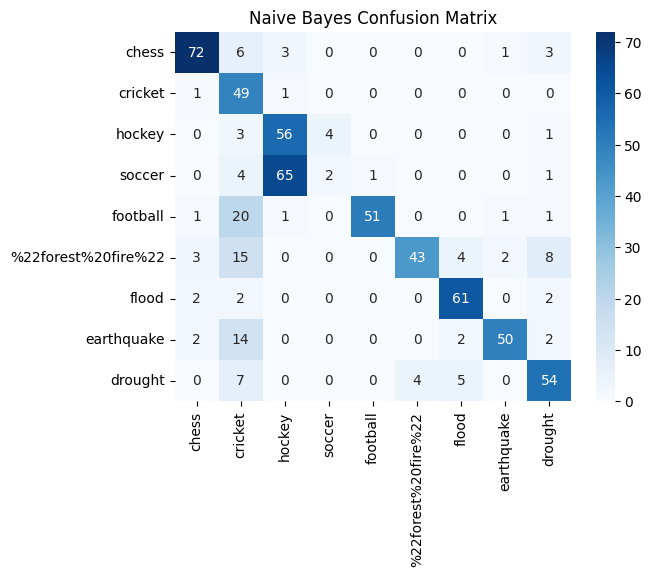

+-----------------------------------------------------------------------------------------------+
|                               Naive Bayes Classification Report:                              |
+---------------------+--------------------+--------------------+---------------------+---------+
|        Class        |     precision      |       recall       |       f1-score      | support |
+---------------------+--------------------+--------------------+---------------------+---------+
|        chess        | 0.8888888888888888 | 0.8470588235294118 |  0.8674698795180723 |    85   |
|       cricket       | 0.4083333333333333 | 0.9607843137254902 |  0.5730994152046783 |    51   |
|        hockey       | 0.4444444444444444 |       0.875        |  0.5894736842105263 |    64   |
|        soccer       | 0.3333333333333333 | 0.0273972602739726 | 0.05063291139240506 |    73   |
|       football      | 0.9807692307692307 |        0.68        |  0.8031496062992126 |    75   |
| %22forest%20fire%2

In [33]:
########## Question 9 - Multiclass Classification - Train and test a Naive Bayes classifier
from sklearn.naive_bayes import MultinomialNB
nb_clf = MultinomialNB()
nb_clf.fit(X_train, y_train)
y_pred_nb = nb_clf.predict(X_test)

# Print Naive Bayes confusion matrix with heatmap
nb_cm = confusion_matrix(y_test, y_pred_nb)
sns.heatmap(nb_cm, annot=True, cmap="Blues", fmt='g', xticklabels=list(map_row_to_class.values()), yticklabels=list(map_row_to_class.values()))
plt.title('Naive Bayes Confusion Matrix')
plt.show()
# Print Naive Bayes classification report with prettytable
nb_cr = classification_report(y_test, y_pred_nb, target_names=list(map_row_to_class.values()), output_dict=True)
nb_pt = PrettyTable()
nb_pt.field_names = ["Class"] + list(nb_cr[list(map_row_to_class.values())[0]].keys())
for label in map_row_to_class.values():
    nb_pt.add_row([label] + list(nb_cr[label].values()))
nb_pt.title = "Naive Bayes Classification Report:"
print(nb_pt)

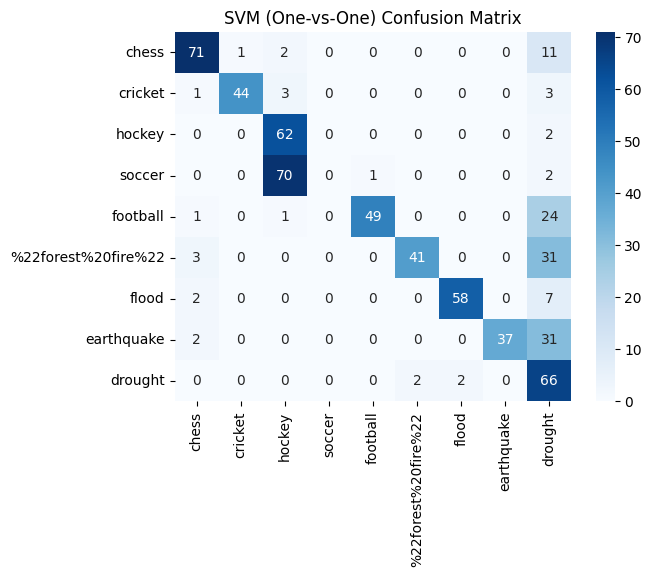

+----------------------------------------------------------------------------------------------+
|                           SVM (One-vs-One) Classification Report:                            |
+---------------------+--------------------+--------------------+--------------------+---------+
|        Class        |     precision      |       recall       |      f1-score      | support |
+---------------------+--------------------+--------------------+--------------------+---------+
|        chess        |       0.8875       | 0.8352941176470589 | 0.8606060606060607 |    85   |
|       cricket       | 0.9777777777777777 | 0.8627450980392157 | 0.9166666666666665 |    51   |
|        hockey       | 0.4492753623188406 |      0.96875       | 0.6138613861386139 |    64   |
|        soccer       |        0.0         |        0.0         |        0.0         |    73   |
|       football      |        0.98        | 0.6533333333333333 |       0.784        |    75   |
| %22forest%20fire%22 | 0.9534

/opt/homebrew/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [34]:
########## Question 9 - Multiclass Classification - Train and test a multiclass SVM classifier with one-vs-one approach
from sklearn.svm import SVC
svm_ovo_clf = SVC(kernel='linear', decision_function_shape='ovo')
svm_ovo_clf.fit(X_train, y_train)
y_pred_svm_ovo = svm_ovo_clf.predict(X_test)

# Print SVM (One-vs-One) confusion matrix with heatmap
svm_ovo_cm = confusion_matrix(y_test, y_pred_svm_ovo)
sns.heatmap(svm_ovo_cm, annot=True, cmap="Blues", fmt='g', xticklabels=list(map_row_to_class.values()), yticklabels=list(map_row_to_class.values()))
plt.title('SVM (One-vs-One) Confusion Matrix')
plt.show()

# Print SVM (One-vs-One) classification report with prettytable
svm_ovo_cr = classification_report(y_test, y_pred_svm_ovo, target_names=list(map_row_to_class.values()), output_dict=True)
svm_ovo_pt = PrettyTable()
svm_ovo_pt.field_names = ["Class"] + list(svm_ovo_cr[list(map_row_to_class.values())[0]].keys())
for label in map_row_to_class.values():
    svm_ovo_pt.add_row([label] + list(svm_ovo_cr[label].values()))
svm_ovo_pt.title = "SVM (One-vs-One) Classification Report:"
print(svm_ovo_pt)

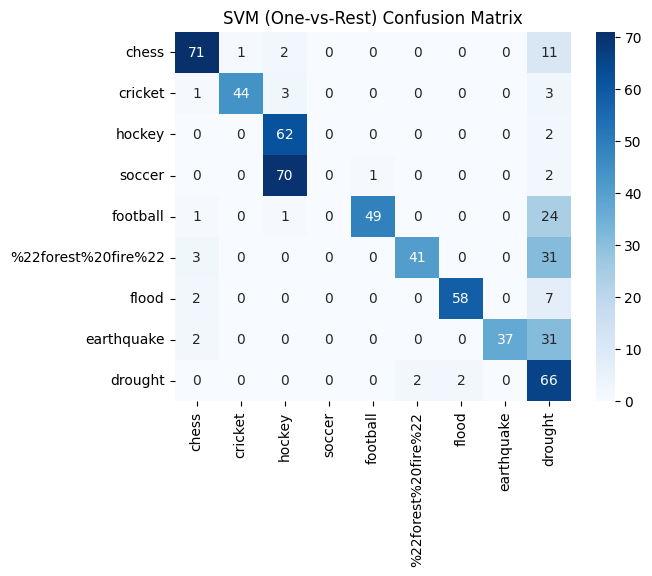

+----------------------------------------------------------------------------------------------+
|                           SVM (One-vs-Rest) Classification Report:                           |
+---------------------+--------------------+--------------------+--------------------+---------+
|        Class        |     precision      |       recall       |      f1-score      | support |
+---------------------+--------------------+--------------------+--------------------+---------+
|        chess        |       0.8875       | 0.8352941176470589 | 0.8606060606060607 |    85   |
|       cricket       | 0.9777777777777777 | 0.8627450980392157 | 0.9166666666666665 |    51   |
|        hockey       | 0.4492753623188406 |      0.96875       | 0.6138613861386139 |    64   |
|        soccer       |        0.0         |        0.0         |        0.0         |    73   |
|       football      |        0.98        | 0.6533333333333333 |       0.784        |    75   |
| %22forest%20fire%22 | 0.9534

/opt/homebrew/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [35]:
########## Question 9 - Multiclass Classification - Train and test a multiclass SVM classifier with one-vs-rest approach
svm_ovr_clf = SVC(kernel='linear', decision_function_shape='ovr')
svm_ovr_clf.fit(X_train, y_train)
y_pred_svm_ovr = svm_ovr_clf.predict(X_test)

# Print SVM (One-vs-Rest) confusion matrix with heatmap
svm_ovr_cm = confusion_matrix(y_test, y_pred_svm_ovr)
sns.heatmap(svm_ovr_cm, annot=True, cmap="Blues", fmt='g', xticklabels=list(map_row_to_class.values()), yticklabels=list(map_row_to_class.values()))
plt.title('SVM (One-vs-Rest) Confusion Matrix')
plt.show()

# Print SVM (One-vs-Rest) classification report with prettytable
svm_ovr_cr = classification_report(y_test, y_pred_svm_ovr, target_names=list(map_row_to_class.values()), output_dict=True)
svm_ovr_pt = PrettyTable()
svm_ovr_pt.field_names = ["Class"] + list(svm_ovr_cr[list(map_row_to_class.values())[0]].keys())
for label in map_row_to_class.values():
    svm_ovr_pt.add_row([label] + list(svm_ovr_cr[label].values()))
svm_ovr_pt.title = "SVM (One-vs-Rest) Classification Report:"
print(svm_ovr_pt)